# Import Packages

In [3]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\Users\richd\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [5]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [6]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


# Functions and Load Data
### EDA Functions

In [7]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [8]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

### Model and Performance Functions

In [9]:
def compile_train_model(model, x_train, y_train, x_valid, y_valid, x_test, y_test, epochs=200):
    timestamp=int(time.time())
  
    # Compile
    model.compile(optimizer='rmsprop',
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

    # Train
    start_time = time.time()
    history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=512,
    validation_data=(x_valid, y_valid),
    #verbose=0,
    callbacks=[    
        tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
        ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
        ]
    )
    end_time = time.time()
    second_elapsed = round(end_time - start_time)

    print(f'Finished model training in {second_elapsed}s')

    print('Model performance with training set')
    train_loss, train_acc = model.evaluate(x_train, y_train)

    print('Evaluating model performance with validation set')
    val_loss, val_acc = model.evaluate(x_valid, y_valid)
    
    test_loss, test_acc = model.evaluate(x_test, y_test)

    result1 = [round(train_loss, 4), round(val_loss, 4), round(test_loss, 4), round(train_acc, 4), 
               round(val_acc, 4), round(test_acc, 4), second_elapsed]
    
    return history, model, result1

In [10]:
def plot_history(history):
    losses = history.history['loss']
    accs = history.history['accuracy']
    val_losses = history.history['val_loss']
    val_accs = history.history['val_accuracy']
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

def display_training_curves(training, validation, title, subplot):
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation'])

In [11]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [12]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

### Loading cifar10 Dataset
- This dataset has 60,000 32x32 color images in 10 classes (6,000 images per class). 
    - 50,000 training and 10,000 test images
    - 5 training and 1 test batch (each with 10,000 images)
        - Test batch has 1,000 randomly selected images from each class
        - Training batch contain the remaining images in random order (but here some images/class are greater than others), but between them the training batches contain exactly 5,000 images from each class

In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# EDA
### EDA Training and Test Datasets
- Imported 50,000 examples for training and 10,000 examples for test
- Imported 50,000 labels for training and 10,000 labels for test

In [14]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t{}'.format(x_test.shape))
print('test_labels:\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:	(10000, 32, 32, 3)
test_labels:	(10000, 1)


- train_image dimensions:
    - 50,000 images
    - 32x32 size in pixels
    - 3 for RGB (red, green, blue)

### Review Labels
- This shows the first ten labels. They need to be converted to describe one of the ten categories

In [15]:
y_train[0:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

### Plot Subset of Examples

In [16]:
x_preview, y_preview = get_three_classes(x_train, y_train)
x_preview, y_preview = get_three_classes(x_test, y_test)

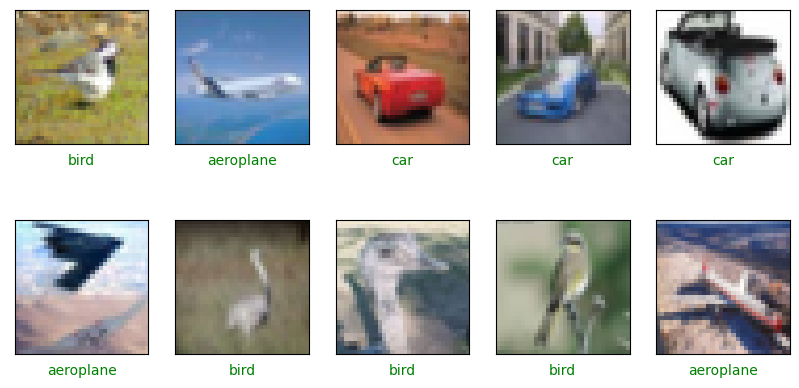

In [17]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

# Preprocess Data and Create Validation Set
### Preprocess Data for Model Development
- Now we'll classify the numerical labels with the categorical name of the label

In [18]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

### Create Validation Data Set

In [19]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

### Confirm Datasets  (Train, Validation, Test)

In [20]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


### Rescale Examples  (Train, Validation, Test)
- Each element in each example is a pixel value
- Pixel values range from 0 to 255    (0 = black, 255 = white)

In [21]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

# Create the Model

# Experiment 1

In [17]:
# Code from Josh Muckensturm DB 3

# parameters to be adjusted 
num_nodes = [64, 128, 192, 256, 320, 384, 448, 512, 576]
nodes = []
train_accuracy = []
val_accuracy = []
test_accuracy = []

for i in num_nodes:
    # build model
    model = Sequential([
        Flatten(input_shape = [32, 32, 3]),
        Dense(units = i, activation = tf.nn.relu),
        Dense(units = i, activation = tf.nn.relu),
        Dense(name = 'output_layer', units = 10, activation = tf.nn.softmax)
    ])
    
    # Compile
    model.compile(optimizer='rmsprop',
                 loss='SparseCategoricalCrossentropy',
                 metrics=['accuracy'])
    
    # Optimize and Fit model
    history = model.fit(
                x_train_norm, y_train_split,
                epochs=200, batch_size=512,
                validation_data=(x_valid_norm, y_valid_split),
                callbacks=[
                    tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False),
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
                ]
        )

    train_accuracy.append(history.history.get('accuracy')[-1])
    val_accuracy.append(history.history.get('val_accuracy')[-1])
    
    preds = model.predict(x_test_norm)
    preds = np.argmax(preds, axis=1)
    test_accuracy.append(accuracy_score(y_test, preds))
    
    nodes.append(i)
    
dict = {'nodes': nodes, 'train_acc': train_accuracy, 'val_acc': val_accuracy, 'test_acc': test_accuracy}

print(pd.DataFrame(dict))

Epoch 1/200
88/88 [==============================] - 1s 8ms/step - loss: 2.1980 - accuracy: 0.2067 - val_loss: 2.1136 - val_accuracy: 0.2344
Epoch 2/200
88/88 [==============================] - 1s 7ms/step - loss: 1.9809 - accuracy: 0.2894 - val_loss: 1.9800 - val_accuracy: 0.2906
Epoch 3/200
88/88 [==============================] - 1s 9ms/step - loss: 1.9043 - accuracy: 0.3194 - val_loss: 1.9434 - val_accuracy: 0.3114
Epoch 4/200
88/88 [==============================] - 1s 6ms/step - loss: 1.8414 - accuracy: 0.3408 - val_loss: 1.7942 - val_accuracy: 0.3676
Epoch 5/200
88/88 [==============================] - 1s 6ms/step - loss: 1.8044 - accuracy: 0.3577 - val_loss: 1.8031 - val_accuracy: 0.3474
Epoch 6/200
88/88 [==============================] - 1s 6ms/step - loss: 1.7704 - accuracy: 0.3710 - val_loss: 1.7313 - val_accuracy: 0.3846
Epoch 7/200
88/88 [==============================] - 1s 7ms/step - loss: 1.7425 - accuracy: 0.3790 - val_loss: 1.8164 - val_accuracy: 0.3514
Epoch 8/200
8

Epoch 5/200
88/88 [==============================] - 1s 16ms/step - loss: 1.7775 - accuracy: 0.3651 - val_loss: 1.7021 - val_accuracy: 0.3952
Epoch 6/200
88/88 [==============================] - 1s 16ms/step - loss: 1.7357 - accuracy: 0.3800 - val_loss: 1.7230 - val_accuracy: 0.3846
Epoch 7/200
88/88 [==============================] - 1s 16ms/step - loss: 1.7028 - accuracy: 0.3905 - val_loss: 1.7358 - val_accuracy: 0.3704
Epoch 8/200
88/88 [==============================] - 1s 16ms/step - loss: 1.6631 - accuracy: 0.4075 - val_loss: 1.6532 - val_accuracy: 0.3960
Epoch 9/200
88/88 [==============================] - 1s 16ms/step - loss: 1.6388 - accuracy: 0.4165 - val_loss: 1.5939 - val_accuracy: 0.4310
Epoch 10/200
88/88 [==============================] - 1s 16ms/step - loss: 1.6168 - accuracy: 0.4255 - val_loss: 1.6528 - val_accuracy: 0.4136
Epoch 11/200
88/88 [==============================] - 1s 17ms/step - loss: 1.5873 - accuracy: 0.4360 - val_loss: 1.5626 - val_accuracy: 0.4416
Epoc

In [21]:
model_1 = Sequential([
    Flatten(input_shape = [32, 32, 3]),
    Dense(units = 512, activation = tf.nn.relu),
    Dense(units = 512, activation = tf.nn.relu),
    Dense(name = 'output_layer', units = 10, activation = tf.nn.softmax)
])

In [22]:
history_1, model_1, results_1 = compile_train_model(model_1,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 6s 36ms/step - loss: 2.7071 - accuracy: 0.1894 - val_loss: 2.0583 - val_accuracy: 0.2480
Epoch 2/200
88/88 [==============================] - 3s 31ms/step - loss: 2.0132 - accuracy: 0.2695 - val_loss: 2.2282 - val_accuracy: 0.2182
Epoch 3/200
88/88 [==============================] - 3s 29ms/step - loss: 1.8943 - accuracy: 0.3167 - val_loss: 2.0116 - val_accuracy: 0.2854
Epoch 4/200
88/88 [==============================] - 3s 29ms/step - loss: 1.8256 - accuracy: 0.3465 - val_loss: 1.8336 - val_accuracy: 0.3500
Epoch 5/200
88/88 [==============================] - 3s 29ms/step - loss: 1.7786 - accuracy: 0.3639 - val_loss: 1.8844 - val_accuracy: 0.3344
Epoch 6/200
88/88 [==============================] - 2s 28ms/step - loss: 1.7323 - accuracy: 0.3825 - val_loss: 1.6600 - val_accuracy: 0.4112
Epoch 7/200
88/88 [==============================] - 2s 28ms/step - loss: 1.6939 - accuracy: 0.3942 - val_loss: 1.6443 - val_accuracy: 0.4124
Epoch 

In [268]:
print(pd.DataFrame([results_1], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      1.2952    1.6194     1.6041     0.5347   0.4448      0.45    94


C:\Users\richd\AppData\Local\Temp\ipykernel_286784\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


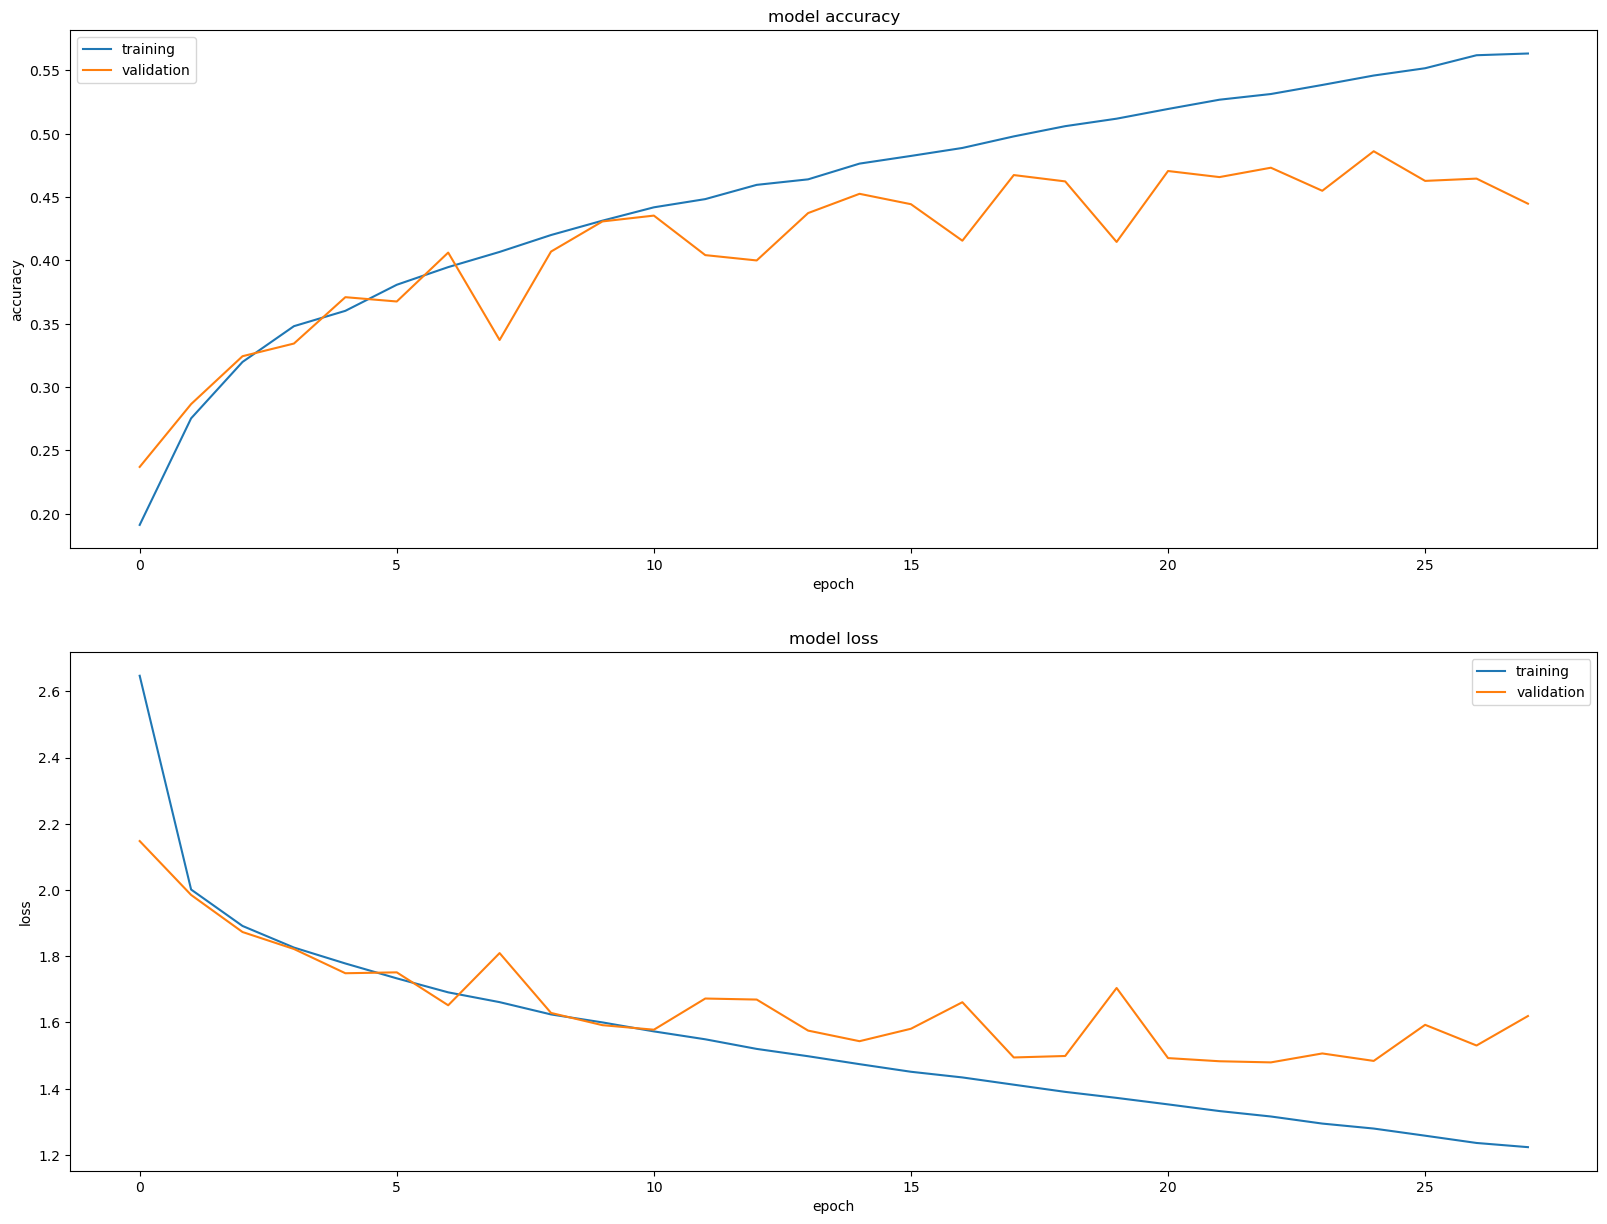

In [269]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_1.history['accuracy'], history_1.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_1.history['loss'], history_1.history['val_loss'], 'loss', 212)

### Confusion Matrix

In [270]:
pred_1 = model_1.predict(x_test_norm)
pred_1 = np.argmax(pred_1, axis=1)

In [271]:
print_validation_report(y_test, pred_1)

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.27      0.39      1000
           1       0.58      0.64      0.61      1000
           2       0.45      0.15      0.23      1000
           3       0.36      0.23      0.28      1000
           4       0.37      0.48      0.42      1000
           5       0.32      0.46      0.38      1000
           6       0.67      0.26      0.38      1000
           7       0.38      0.73      0.50      1000
           8       0.50      0.69      0.58      1000
           9       0.50      0.59      0.54      1000

    accuracy                           0.45     10000
   macro avg       0.49      0.45      0.43     10000
weighted avg       0.49      0.45      0.43     10000

Accuracy Score: 0.45
Root Mean Square Error: 3.300651450850271


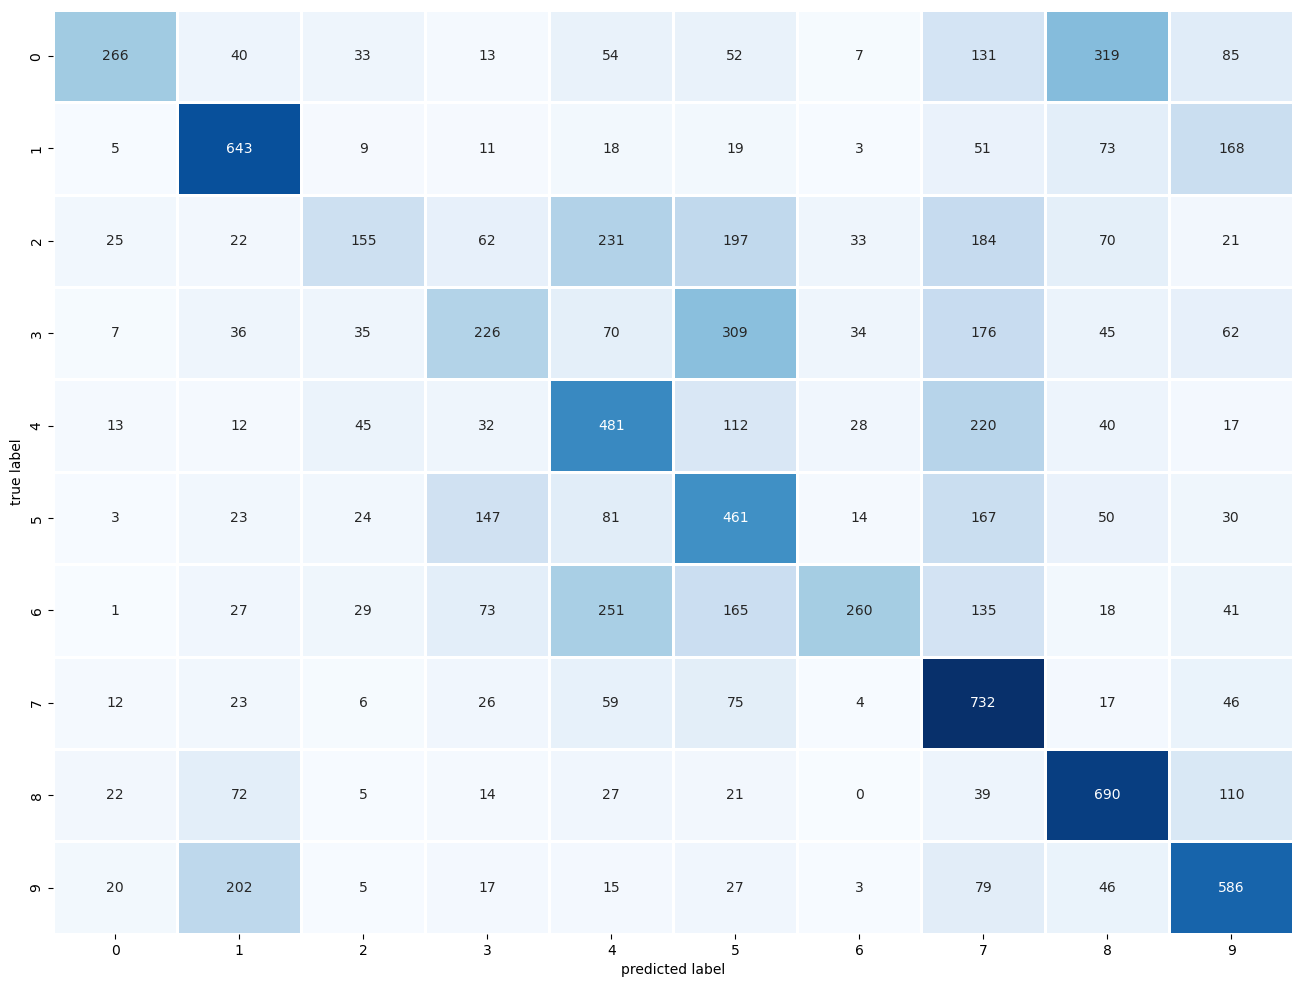

In [272]:
plot_confusion_matrix(y_test, pred_1)

# Experiment 2

In [16]:
# Code from Josh Muckensturm DB 3

# parameters to be adjusted 
num_nodes_3 = [64, 128, 192, 256, 320, 384, 448, 512, 576]
nodes_3 = []
train_accuracy_3 = []
val_accuracy_3 = []
test_accuracy_3 = []

for i in num_nodes_3:
    # build model
    model = Sequential([
        Flatten(input_shape = [32, 32, 3]),
        Dense(units = i, activation = tf.nn.relu),
        Dense(units = i, activation = tf.nn.relu),
        Dense(units = i, activation = tf.nn.relu),
        Dense(name = 'output_layer', units = 10, activation = tf.nn.softmax)
    ])
    
    # Compile
    model.compile(optimizer='rmsprop',
                 loss='SparseCategoricalCrossentropy',
                 metrics=['accuracy'])
    
    # Optimize and Fit model
    history = model.fit(
                x_train_norm, y_train_split,
                epochs=200, batch_size=512,
                validation_data=(x_valid_norm, y_valid_split),
                callbacks=[
                    tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False),
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
                ]
        )

    train_accuracy_3.append(history.history.get('accuracy')[-1])
    val_accuracy_3.append(history.history.get('val_accuracy')[-1])
    
    preds = model.predict(x_test_norm)
    preds = np.argmax(preds, axis=1)
    test_accuracy_3.append(accuracy_score(y_test, preds))
    
    nodes_3.append(i)
    
dict = {'nodes': nodes_3, 'train_acc': train_accuracy_3, 'val_acc': val_accuracy_3, 'test_acc': test_accuracy_3}

print(pd.DataFrame(dict))

Epoch 1/200
88/88 [==============================] - 1s 10ms/step - loss: 2.2239 - accuracy: 0.1841 - val_loss: 2.0538 - val_accuracy: 0.2598
Epoch 2/200
88/88 [==============================] - 1s 6ms/step - loss: 1.9965 - accuracy: 0.2770 - val_loss: 1.9271 - val_accuracy: 0.3146
Epoch 3/200
88/88 [==============================] - 0s 6ms/step - loss: 1.9081 - accuracy: 0.3149 - val_loss: 2.0382 - val_accuracy: 0.2732
Epoch 4/200
88/88 [==============================] - 1s 6ms/step - loss: 1.8564 - accuracy: 0.3336 - val_loss: 1.8997 - val_accuracy: 0.3084
Epoch 5/200
88/88 [==============================] - 1s 6ms/step - loss: 1.8088 - accuracy: 0.3484 - val_loss: 1.8502 - val_accuracy: 0.3304
Epoch 6/200
88/88 [==============================] - 1s 6ms/step - loss: 1.7782 - accuracy: 0.3602 - val_loss: 1.7746 - val_accuracy: 0.3644
Epoch 7/200
88/88 [==============================] - 1s 6ms/step - loss: 1.7525 - accuracy: 0.3716 - val_loss: 1.7637 - val_accuracy: 0.3720
Epoch 8/200


Epoch 12/200
88/88 [==============================] - 1s 12ms/step - loss: 1.5815 - accuracy: 0.4368 - val_loss: 1.5925 - val_accuracy: 0.4320
Epoch 13/200
88/88 [==============================] - 1s 12ms/step - loss: 1.5604 - accuracy: 0.4451 - val_loss: 1.5872 - val_accuracy: 0.4276
Epoch 14/200
88/88 [==============================] - 1s 11ms/step - loss: 1.5443 - accuracy: 0.4527 - val_loss: 1.6416 - val_accuracy: 0.4098
Epoch 15/200
88/88 [==============================] - 1s 11ms/step - loss: 1.5301 - accuracy: 0.4572 - val_loss: 1.5764 - val_accuracy: 0.4310
Epoch 1/200
88/88 [==============================] - 2s 16ms/step - loss: 2.5309 - accuracy: 0.1834 - val_loss: 2.0517 - val_accuracy: 0.2480
Epoch 2/200
88/88 [==============================] - 1s 15ms/step - loss: 2.0089 - accuracy: 0.2676 - val_loss: 1.8854 - val_accuracy: 0.3178
Epoch 3/200
88/88 [==============================] - 1s 15ms/step - loss: 1.8993 - accuracy: 0.3130 - val_loss: 1.8703 - val_accuracy: 0.3360
Ep

In [273]:
model_2 = Sequential([
    Flatten(input_shape = [32, 32, 3]),
    Dense(units = 320, activation = tf.nn.relu),
    Dense(units = 320, activation = tf.nn.relu),
    Dense(units = 320, activation = tf.nn.relu),
    Dense(name = 'output_layer', units = 10, activation = tf.nn.softmax)
])

In [274]:
history_2, model_2, results_2 = compile_train_model(model_2,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 4s 32ms/step - loss: 2.3003 - accuracy: 0.1854 - val_loss: 2.0511 - val_accuracy: 0.2298
Epoch 2/200
88/88 [==============================] - 2s 24ms/step - loss: 1.9964 - accuracy: 0.2724 - val_loss: 1.9756 - val_accuracy: 0.2848
Epoch 3/200
88/88 [==============================] - 2s 24ms/step - loss: 1.8933 - accuracy: 0.3147 - val_loss: 1.9486 - val_accuracy: 0.2906
Epoch 4/200
88/88 [==============================] - 2s 28ms/step - loss: 1.8285 - accuracy: 0.3390 - val_loss: 2.0394 - val_accuracy: 0.2812
Epoch 5/200
88/88 [==============================] - 2s 25ms/step - loss: 1.7759 - accuracy: 0.3574 - val_loss: 1.7486 - val_accuracy: 0.3702
Epoch 6/200
88/88 [==============================] - 2s 22ms/step - loss: 1.7418 - accuracy: 0.3734 - val_loss: 1.8248 - val_accuracy: 0.3474
Epoch 7/200
88/88 [==============================] - 2s 23ms/step - loss: 1.6972 - accuracy: 0.3867 - val_loss: 1.7034 - val_accuracy: 0.3830
Epoch 

In [280]:
print(pd.DataFrame([results_2], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      1.3314    1.5579     1.5277     0.5232   0.4476    0.4573    53


C:\Users\richd\AppData\Local\Temp\ipykernel_286784\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


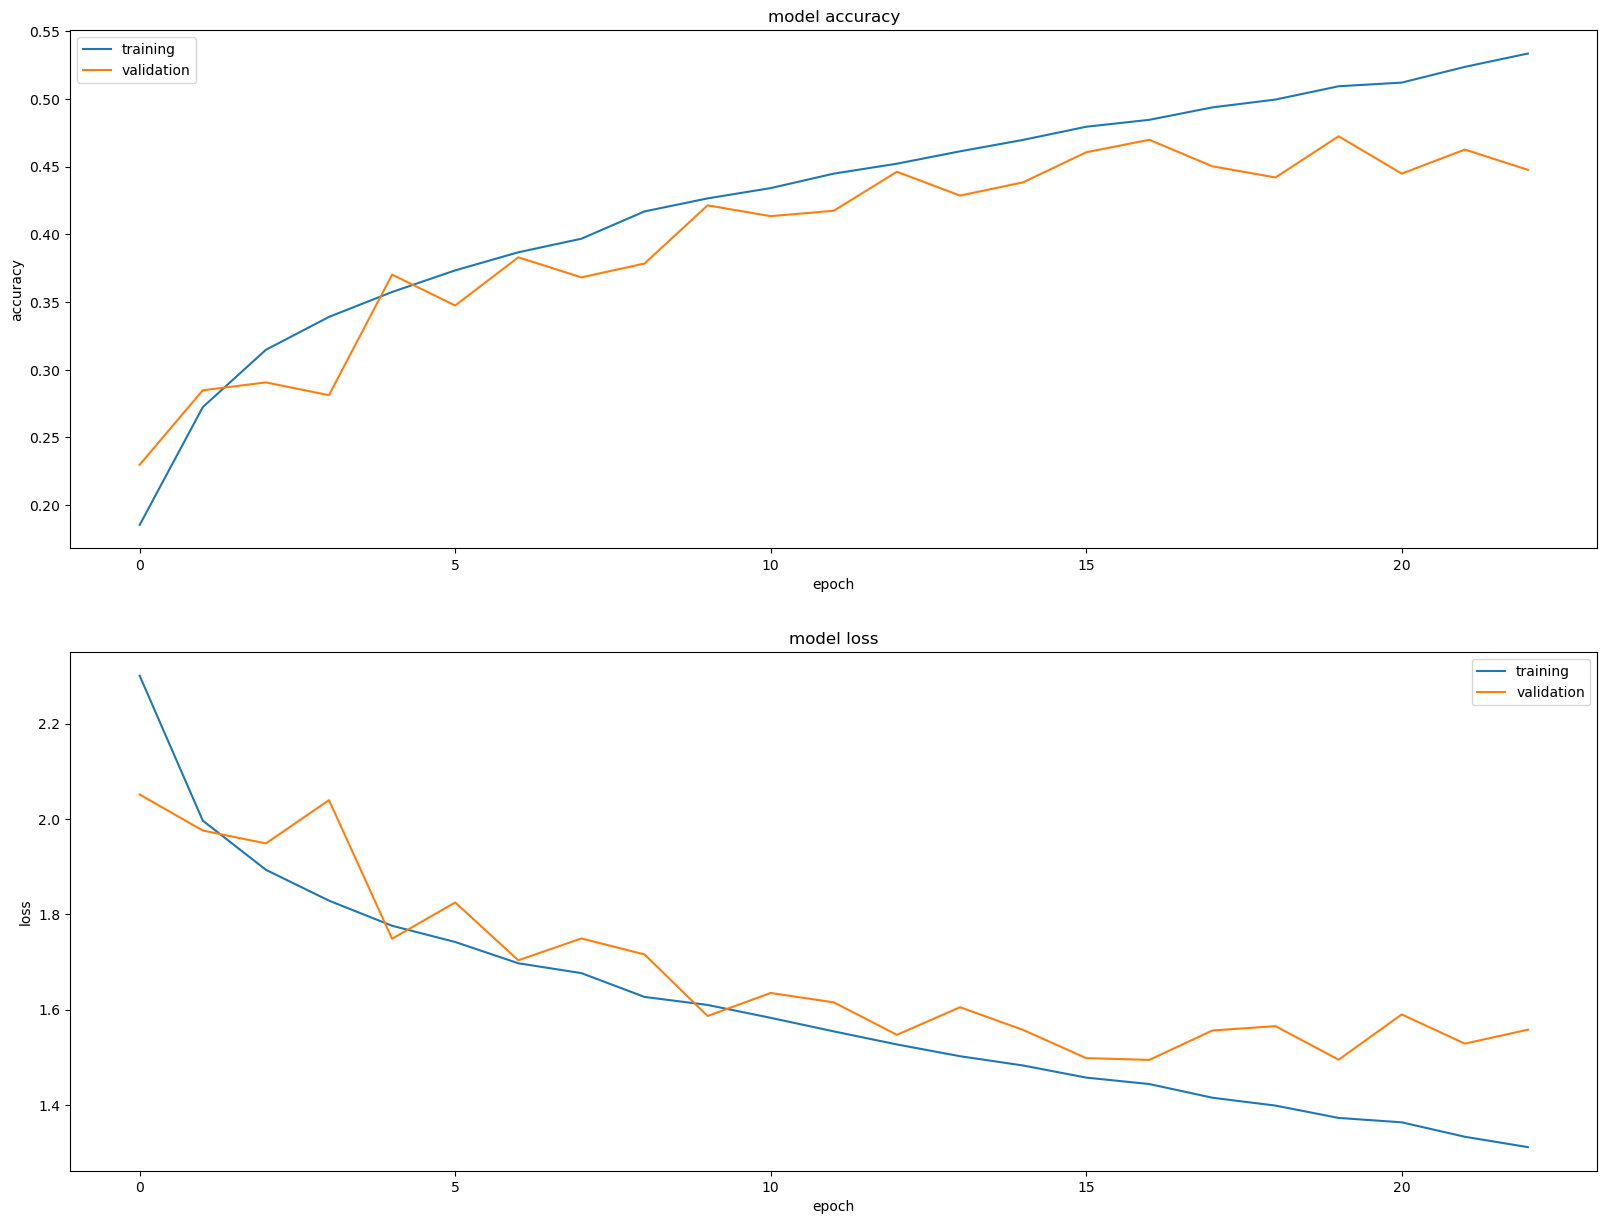

In [281]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_2.history['accuracy'], history_2.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_2.history['loss'], history_2.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 2)

In [277]:
pred_2 = model_2.predict(x_test_norm)
pred_2 = np.argmax(pred_2, axis=1)

In [278]:
print_validation_report(y_test, pred_2)

Classification Report
              precision    recall  f1-score   support

           0       0.47      0.57      0.52      1000
           1       0.79      0.29      0.43      1000
           2       0.39      0.34      0.37      1000
           3       0.30      0.31      0.31      1000
           4       0.46      0.26      0.33      1000
           5       0.42      0.35      0.38      1000
           6       0.45      0.59      0.51      1000
           7       0.53      0.50      0.52      1000
           8       0.51      0.69      0.59      1000
           9       0.44      0.67      0.53      1000

    accuracy                           0.46     10000
   macro avg       0.48      0.46      0.45     10000
weighted avg       0.48      0.46      0.45     10000

Accuracy Score: 0.4573
Root Mean Square Error: 3.3048751867506283


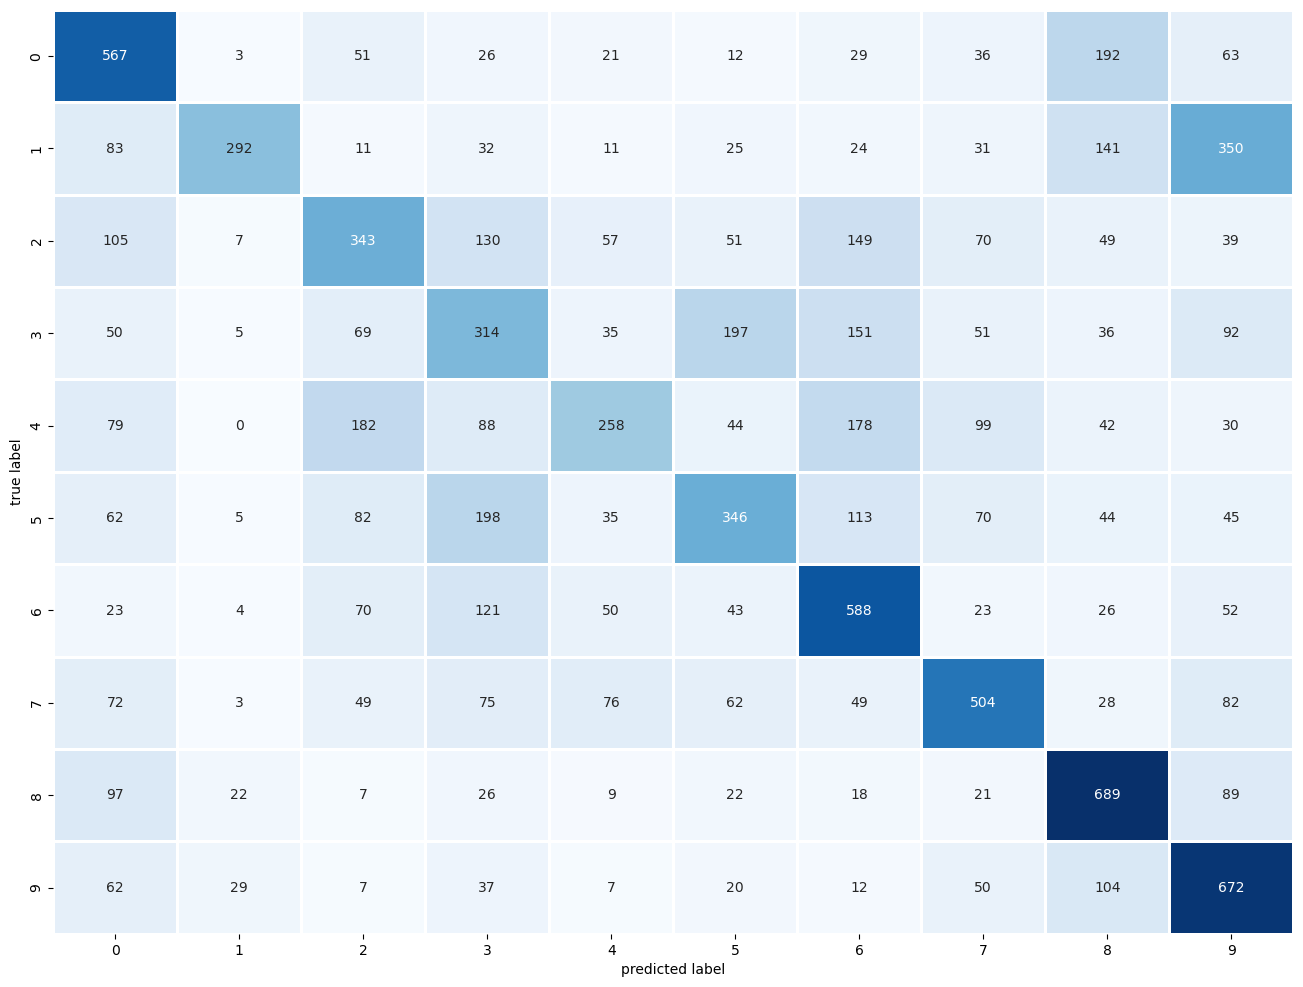

In [279]:
plot_confusion_matrix(y_test, pred_2)

# Experiment 3
### Build CNN Model
- Sequential class defined in Keras
    - First 9 layers handle feature learning   (Conv2D, MaxPooling, Dropout)
    - Last 3 layers handle classification

In [41]:
k.clear_session()
# Code from Josh Muckensturm DB 3

# parameters to be adjusted 
num_filters_c2 = [64, 128, 192, 256]
filters_c2 = []
train_accuracy_c2 = []
val_accuracy_c2 = []
test_accuracy_c2 = []

for i in num_filters_c2:
    # build model
    model = Sequential([
        Conv2D(filters=i, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
        MaxPool2D((2, 2),strides=2),
        Conv2D(filters=(i * 2), kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
        MaxPool2D((2, 2),strides=2),
        Flatten(),
        Dense(units=128,activation=tf.nn.softmax),
        Dense(units=10, activation=tf.nn.softmax)       
    ])
    
    # Compile
    model.compile(optimizer='rmsprop',
                 loss='SparseCategoricalCrossentropy',
                 metrics=['accuracy'])
    
    # Optimize and Fit model
    history = model.fit(
                x_train_norm, y_train_split,
                epochs=200, batch_size=512,
                validation_data=(x_valid_norm, y_valid_split),
                callbacks=[
                    tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False),
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
                ]
        )

    train_accuracy_c2.append(history.history.get('accuracy')[-1])
    val_accuracy_c2.append(history.history.get('val_accuracy')[-1])
    
    preds = model.predict(x_test_norm)
    preds = np.argmax(preds, axis=1)
    test_accuracy_c2.append(accuracy_score(y_test, preds))
    
    filters_c2.append(i)
    
dict = {'nodes': filters_c2, 'train_acc': train_accuracy_c2, 'val_acc': val_accuracy_c2, 'test_acc': test_accuracy_c2}

print(pd.DataFrame(dict))

Epoch 1/200
88/88 [==============================] - 30s 334ms/step - loss: 2.2377 - accuracy: 0.2062 - val_loss: 2.2088 - val_accuracy: 0.2486
Epoch 2/200
88/88 [==============================] - 31s 348ms/step - loss: 2.1616 - accuracy: 0.2891 - val_loss: 2.1460 - val_accuracy: 0.2998
Epoch 3/200
88/88 [==============================] - 30s 345ms/step - loss: 2.0999 - accuracy: 0.3223 - val_loss: 2.0772 - val_accuracy: 0.2970
Epoch 4/200
88/88 [==============================] - 31s 348ms/step - loss: 2.0399 - accuracy: 0.3355 - val_loss: 2.0092 - val_accuracy: 0.3590
Epoch 5/200
88/88 [==============================] - 31s 348ms/step - loss: 1.9808 - accuracy: 0.3679 - val_loss: 1.9667 - val_accuracy: 0.3896
Epoch 6/200
88/88 [==============================] - 30s 346ms/step - loss: 1.9235 - accuracy: 0.3888 - val_loss: 1.9198 - val_accuracy: 0.3970
Epoch 7/200
88/88 [==============================] - 30s 343ms/step - loss: 1.8705 - accuracy: 0.4171 - val_loss: 1.8367 - val_accuracy:

88/88 [==============================] - 277s 3s/step - loss: 1.2339 - accuracy: 0.6558 - val_loss: 1.3267 - val_accuracy: 0.6112
Epoch 18/200
88/88 [==============================] - 272s 3s/step - loss: 1.1838 - accuracy: 0.6721 - val_loss: 1.2434 - val_accuracy: 0.6434
Epoch 19/200
88/88 [==============================] - 267s 3s/step - loss: 1.1254 - accuracy: 0.6882 - val_loss: 1.2197 - val_accuracy: 0.6392
Epoch 20/200
88/88 [==============================] - 281s 3s/step - loss: 1.0761 - accuracy: 0.7009 - val_loss: 1.2543 - val_accuracy: 0.6188
Epoch 21/200
88/88 [==============================] - 280s 3s/step - loss: 1.0308 - accuracy: 0.7144 - val_loss: 1.1809 - val_accuracy: 0.6538
Epoch 22/200
88/88 [==============================] - 275s 3s/step - loss: 0.9786 - accuracy: 0.7296 - val_loss: 1.1566 - val_accuracy: 0.6444
Epoch 23/200
88/88 [==============================] - 281s 3s/step - loss: 0.9347 - accuracy: 0.7403 - val_loss: 1.1179 - val_accuracy: 0.6684
Epoch 24/200

In [45]:
x_train_norm.shape

(45000, 32, 32, 3)

In [283]:
dict = {'filters': filters_c2, 'train_acc': train_accuracy_c2, 'val_acc': val_accuracy_c2, 'test_acc': test_accuracy_c2}

print(pd.DataFrame(dict))

   filters  train_acc  val_acc  test_acc
0       64   0.728667   0.6450    0.6552
1      128   0.787556   0.6542    0.6627
2      192   0.624089   0.5430    0.5499
3      256   0.878467   0.7068    0.7056


In [103]:
k.clear_session()
model_3 = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(),
  Dense(units=128,activation=tf.nn.softmax),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 128)               5

In [104]:
history_3, model_3, results_3 = compile_train_model(model_3,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 33s 350ms/step - loss: 2.2429 - accuracy: 0.2088 - val_loss: 2.1989 - val_accuracy: 0.2538
Epoch 2/200
88/88 [==============================] - 31s 348ms/step - loss: 2.1669 - accuracy: 0.3129 - val_loss: 2.1324 - val_accuracy: 0.3420
Epoch 3/200
88/88 [==============================] - 31s 354ms/step - loss: 2.1039 - accuracy: 0.3440 - val_loss: 2.0985 - val_accuracy: 0.3456
Epoch 4/200
88/88 [==============================] - 31s 357ms/step - loss: 2.0465 - accuracy: 0.3694 - val_loss: 2.0166 - val_accuracy: 0.3906
Epoch 5/200
88/88 [==============================] - 32s 362ms/step - loss: 1.9862 - accuracy: 0.3970 - val_loss: 1.9468 - val_accuracy: 0.4002
Epoch 6/200
88/88 [==============================] - 32s 359ms/step - loss: 1.9270 - accuracy: 0.4151 - val_loss: 1.8946 - val_accuracy: 0.4190
Epoch 7/200
88/88 [==============================] - 31s 353ms/step - loss: 1.8713 - accuracy: 0.4304 - val_loss: 1.8365 - val_accuracy:

In [105]:
print(pd.DataFrame([results_3], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      0.8028    1.0615     1.0706     0.7344   0.6424    0.6498  1208


C:\Users\richd\AppData\Local\Temp\ipykernel_286784\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


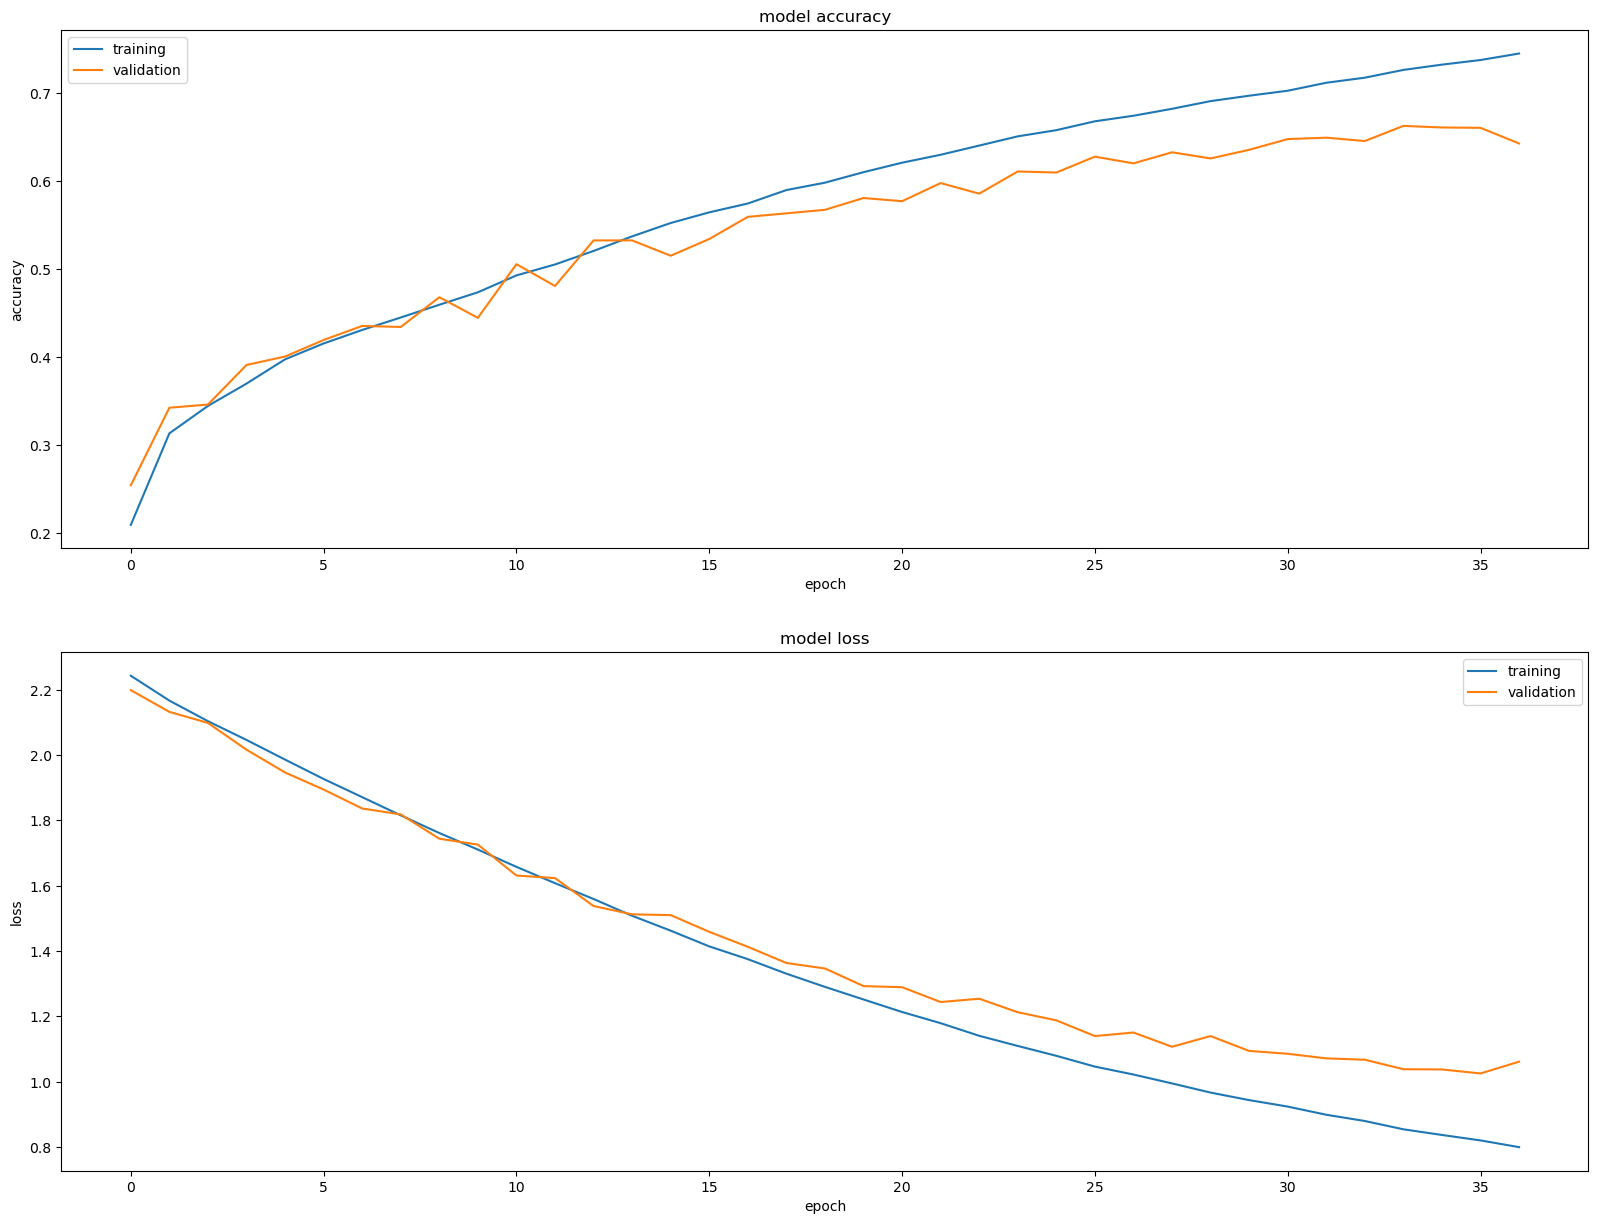

In [106]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_3.history['accuracy'], history_3.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_3.history['loss'], history_3.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 3)

In [107]:
pred_3 = model_3.predict(x_test_norm)
pred_3 = np.argmax(pred_3, axis=1)

In [108]:
print_validation_report(y_test, pred_3)

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1000
           1       0.83      0.79      0.81      1000
           2       0.49      0.65      0.56      1000
           3       0.40      0.28      0.33      1000
           4       0.68      0.46      0.55      1000
           5       0.43      0.74      0.55      1000
           6       0.91      0.56      0.69      1000
           7       0.70      0.74      0.72      1000
           8       0.77      0.82      0.79      1000
           9       0.81      0.74      0.77      1000

    accuracy                           0.65     10000
   macro avg       0.68      0.65      0.65     10000
weighted avg       0.68      0.65      0.65     10000

Accuracy Score: 0.6498
Root Mean Square Error: 2.327981958692979


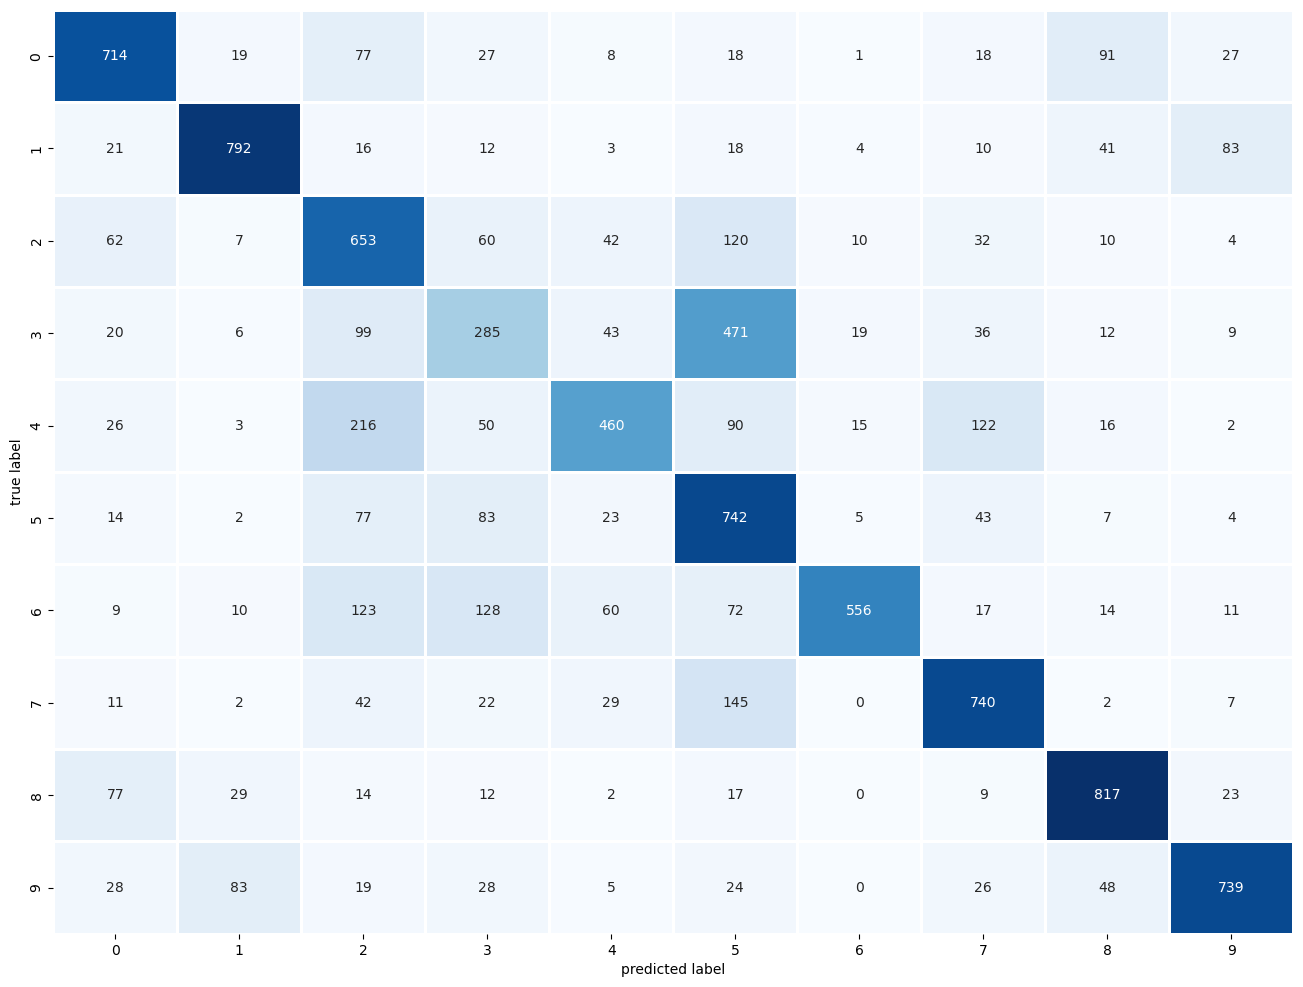

In [109]:
plot_confusion_matrix(y_test, pred_3)

# Experiment 4

In [33]:
k.clear_session()
model_4 = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(),
  Dense(units=128,activation=tf.nn.softmax),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 256)        0

In [34]:
history_4, model_4, results_4 = compile_train_model(model_4,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 38s 423ms/step - loss: 2.2553 - accuracy: 0.1862 - val_loss: 2.2227 - val_accuracy: 0.2352
Epoch 2/200
88/88 [==============================] - 38s 430ms/step - loss: 2.1784 - accuracy: 0.2470 - val_loss: 2.1462 - val_accuracy: 0.2796
Epoch 3/200
88/88 [==============================] - 36s 413ms/step - loss: 2.1170 - accuracy: 0.2872 - val_loss: 2.0784 - val_accuracy: 0.3164
Epoch 4/200
88/88 [==============================] - 37s 415ms/step - loss: 2.0523 - accuracy: 0.3194 - val_loss: 2.1233 - val_accuracy: 0.2486
Epoch 5/200
88/88 [==============================] - 37s 415ms/step - loss: 1.9962 - accuracy: 0.3383 - val_loss: 1.9475 - val_accuracy: 0.3618
Epoch 6/200
88/88 [==============================] - 36s 411ms/step - loss: 1.9358 - accuracy: 0.3592 - val_loss: 1.9415 - val_accuracy: 0.3548
Epoch 7/200
88/88 [==============================] - 36s 414ms/step - loss: 1.8797 - accuracy: 0.3754 - val_loss: 1.8788 - val_accuracy:

In [35]:
print(pd.DataFrame([results_4], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      0.7461    1.0767     1.1026     0.7377   0.6342    0.6282  1268


C:\Users\richd\AppData\Local\Temp\ipykernel_20228\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


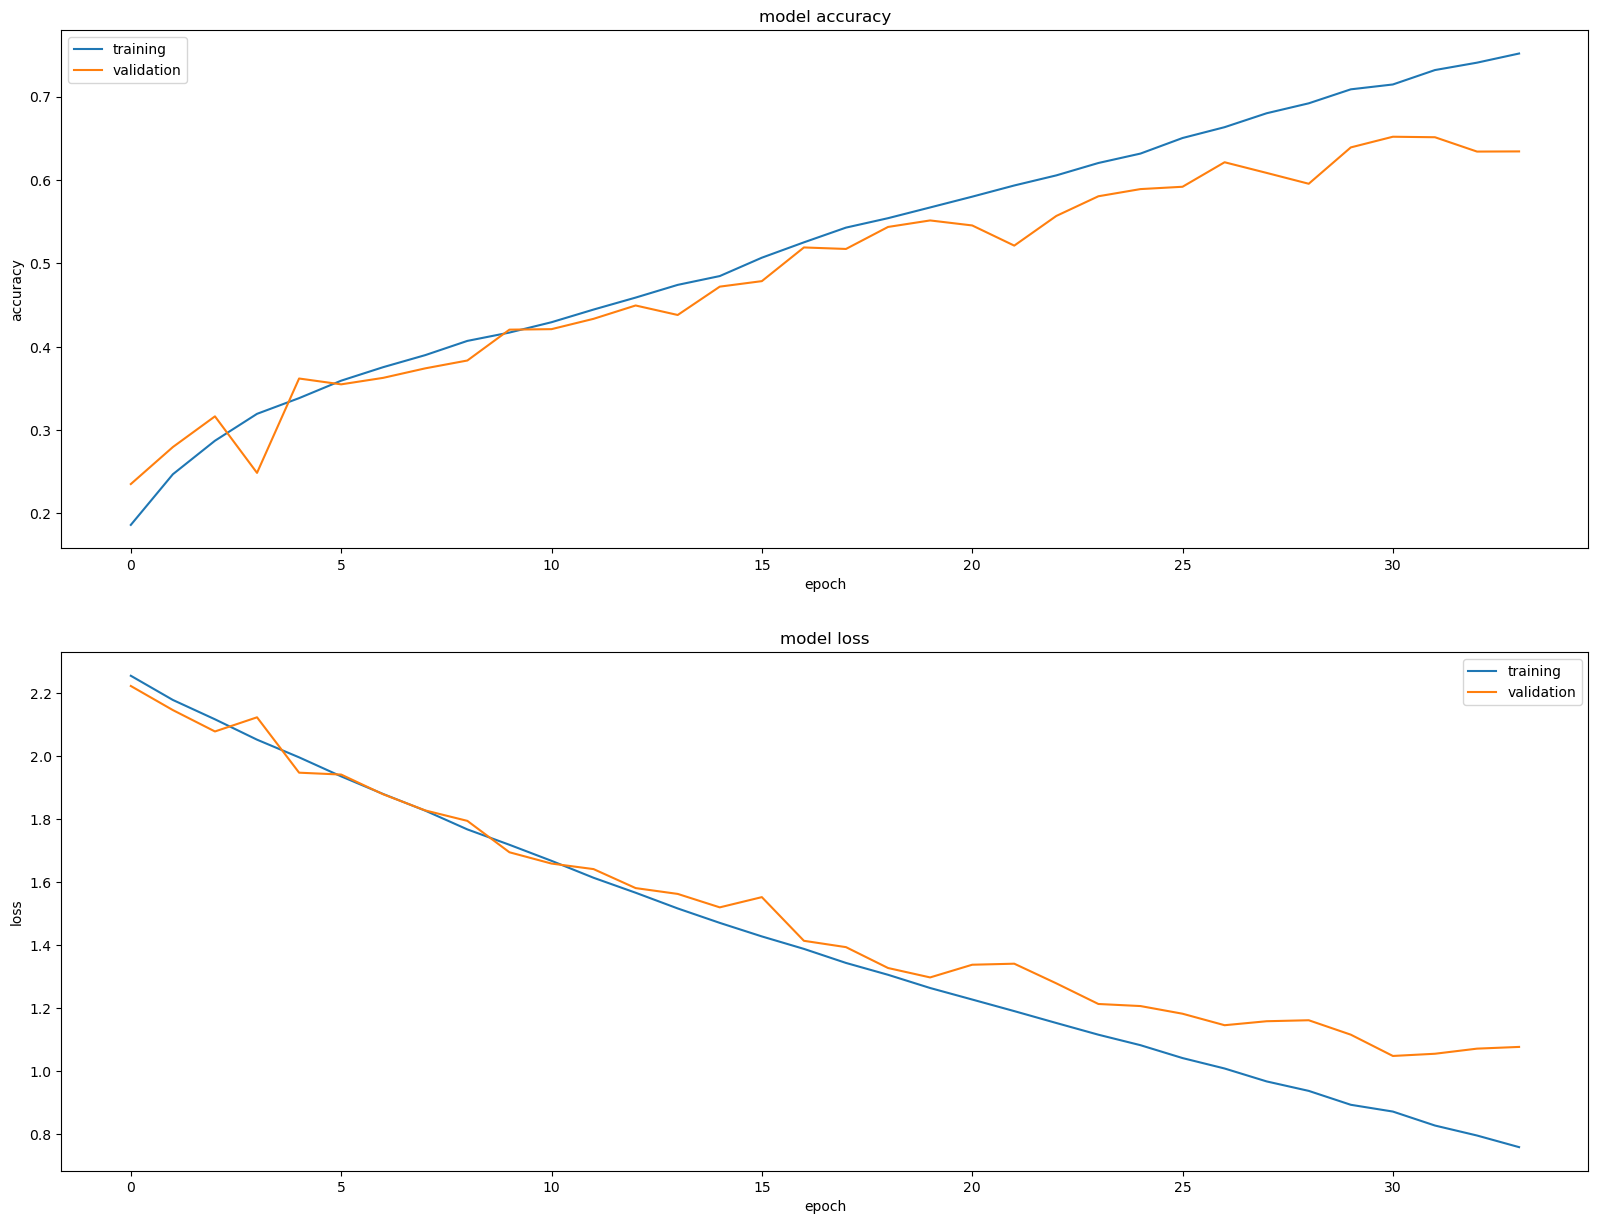

In [36]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_4.history['accuracy'], history_4.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_4.history['loss'], history_4.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 4)

In [37]:
pred_4 = model_4.predict(x_test_norm)
pred_4 = np.argmax(pred_4, axis=1)

In [38]:
print_validation_report(y_test, pred_4)

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.69      0.72      1000
           1       0.57      0.85      0.68      1000
           2       0.47      0.71      0.57      1000
           3       0.44      0.18      0.26      1000
           4       0.61      0.61      0.61      1000
           5       0.50      0.59      0.54      1000
           6       0.76      0.77      0.77      1000
           7       0.82      0.69      0.75      1000
           8       0.69      0.87      0.77      1000
           9       0.89      0.31      0.46      1000

    accuracy                           0.63     10000
   macro avg       0.65      0.63      0.61     10000
weighted avg       0.65      0.63      0.61     10000

Accuracy Score: 0.6282
Root Mean Square Error: 2.7876154684604546


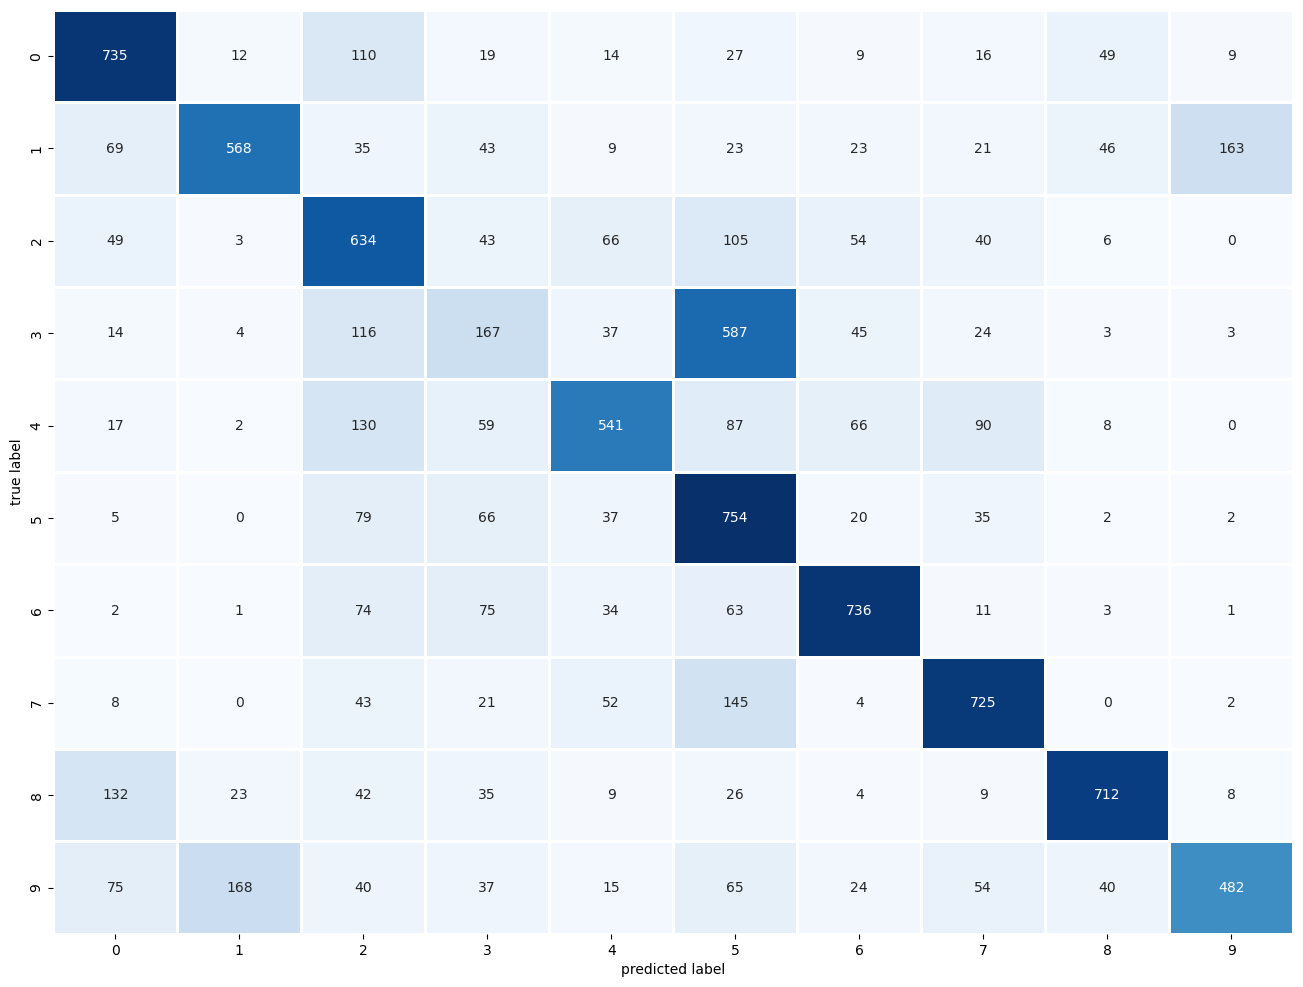

In [116]:
plot_confusion_matrix(y_test, pred_4)

# Experiment 5

In [39]:
# parameters to be adjusted 

dropout_rates = [0, 0.25, 0.5]
l2_reg = [.0001, .0005, .001]

dropouts = []
l2 = []
train_accuracy = []
val_accuracy = []
test_accuracy = []

for i in dropout_rates:
    for j in l2_reg:

        # build model
        model = Sequential([
            Flatten(input_shape = [32, 32, 3]),
            Dense(units = 512, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(j)),
            Dropout(i),
            Dense(units = 512, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(j)),
            Dropout(i),
            Dense(name = 'output_layer', units = 10, activation = tf.nn.softmax)
        ])

        # Compile
        model.compile(optimizer='rmsprop',
                     loss='SparseCategoricalCrossentropy',
                     metrics=['accuracy'])

        # Optimize and Fit model
        history = model.fit(
                    x_train_norm, y_train_split,
                    epochs=200, batch_size=512,
                    validation_data=(x_valid_norm, y_valid_split),
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
                    ]
            )

        train_accuracy.append(history.history.get('accuracy')[-1])
        val_accuracy.append(history.history.get('val_accuracy')[-1])

        preds = model.predict(x_test_norm)
        preds = np.argmax(preds, axis=1)
        test_accuracy.append(accuracy_score(y_test, preds))

        dropouts.append(i)
        l2.append(j)
    
dict = {'Dropout': dropouts, 'L2_reg': l2, 'train_acc': train_accuracy, 'val_acc': val_accuracy, 'test_acc': test_accuracy}

print(pd.DataFrame(dict))

Epoch 1/200
88/88 [==============================] - 4s 38ms/step - loss: 2.8613 - accuracy: 0.1918 - val_loss: 2.1357 - val_accuracy: 0.2624
Epoch 2/200
88/88 [==============================] - 3s 36ms/step - loss: 2.0568 - accuracy: 0.2703 - val_loss: 1.9190 - val_accuracy: 0.3134
Epoch 3/200
88/88 [==============================] - 3s 36ms/step - loss: 1.9178 - accuracy: 0.3166 - val_loss: 1.9131 - val_accuracy: 0.3064
Epoch 4/200
88/88 [==============================] - 3s 36ms/step - loss: 1.8499 - accuracy: 0.3445 - val_loss: 1.8564 - val_accuracy: 0.3356
Epoch 5/200
88/88 [==============================] - 3s 38ms/step - loss: 1.7928 - accuracy: 0.3670 - val_loss: 1.7230 - val_accuracy: 0.3948
Epoch 6/200
88/88 [==============================] - 3s 36ms/step - loss: 1.7561 - accuracy: 0.3797 - val_loss: 1.8452 - val_accuracy: 0.3602
Epoch 7/200
88/88 [==============================] - 3s 36ms/step - loss: 1.7160 - accuracy: 0.3948 - val_loss: 1.8146 - val_accuracy: 0.3538
Epoch 

In [40]:
model_5 = Sequential([
    Flatten(input_shape = [32, 32, 3]),
    Dense(units = 512, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    Dense(units = 512, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    Dense(name = 'output_layer', units = 10, activation = tf.nn.softmax)
])

In [41]:
history_5, model_5, results_5 = compile_train_model(model_5,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 6s 41ms/step - loss: 2.9297 - accuracy: 0.1912 - val_loss: 2.2188 - val_accuracy: 0.1892
Epoch 2/200
88/88 [==============================] - 3s 36ms/step - loss: 2.0452 - accuracy: 0.2727 - val_loss: 1.9499 - val_accuracy: 0.3014
Epoch 3/200
88/88 [==============================] - 3s 36ms/step - loss: 1.9201 - accuracy: 0.3186 - val_loss: 1.8078 - val_accuracy: 0.3518
Epoch 4/200
88/88 [==============================] - 3s 36ms/step - loss: 1.8459 - accuracy: 0.3436 - val_loss: 1.8705 - val_accuracy: 0.3068
Epoch 5/200
88/88 [==============================] - 3s 38ms/step - loss: 1.7904 - accuracy: 0.3675 - val_loss: 1.8737 - val_accuracy: 0.3374
Epoch 6/200
88/88 [==============================] - 3s 37ms/step - loss: 1.7462 - accuracy: 0.3827 - val_loss: 1.8075 - val_accuracy: 0.3640
Epoch 7/200
88/88 [==============================] - 3s 37ms/step - loss: 1.7087 - accuracy: 0.3971 - val_loss: 1.6673 - val_accuracy: 0.4130
Epoch 

In [42]:
print(pd.DataFrame([results_5], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      1.4757    1.5886     1.5611     0.4867   0.4414    0.4524    58


C:\Users\richd\AppData\Local\Temp\ipykernel_20228\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


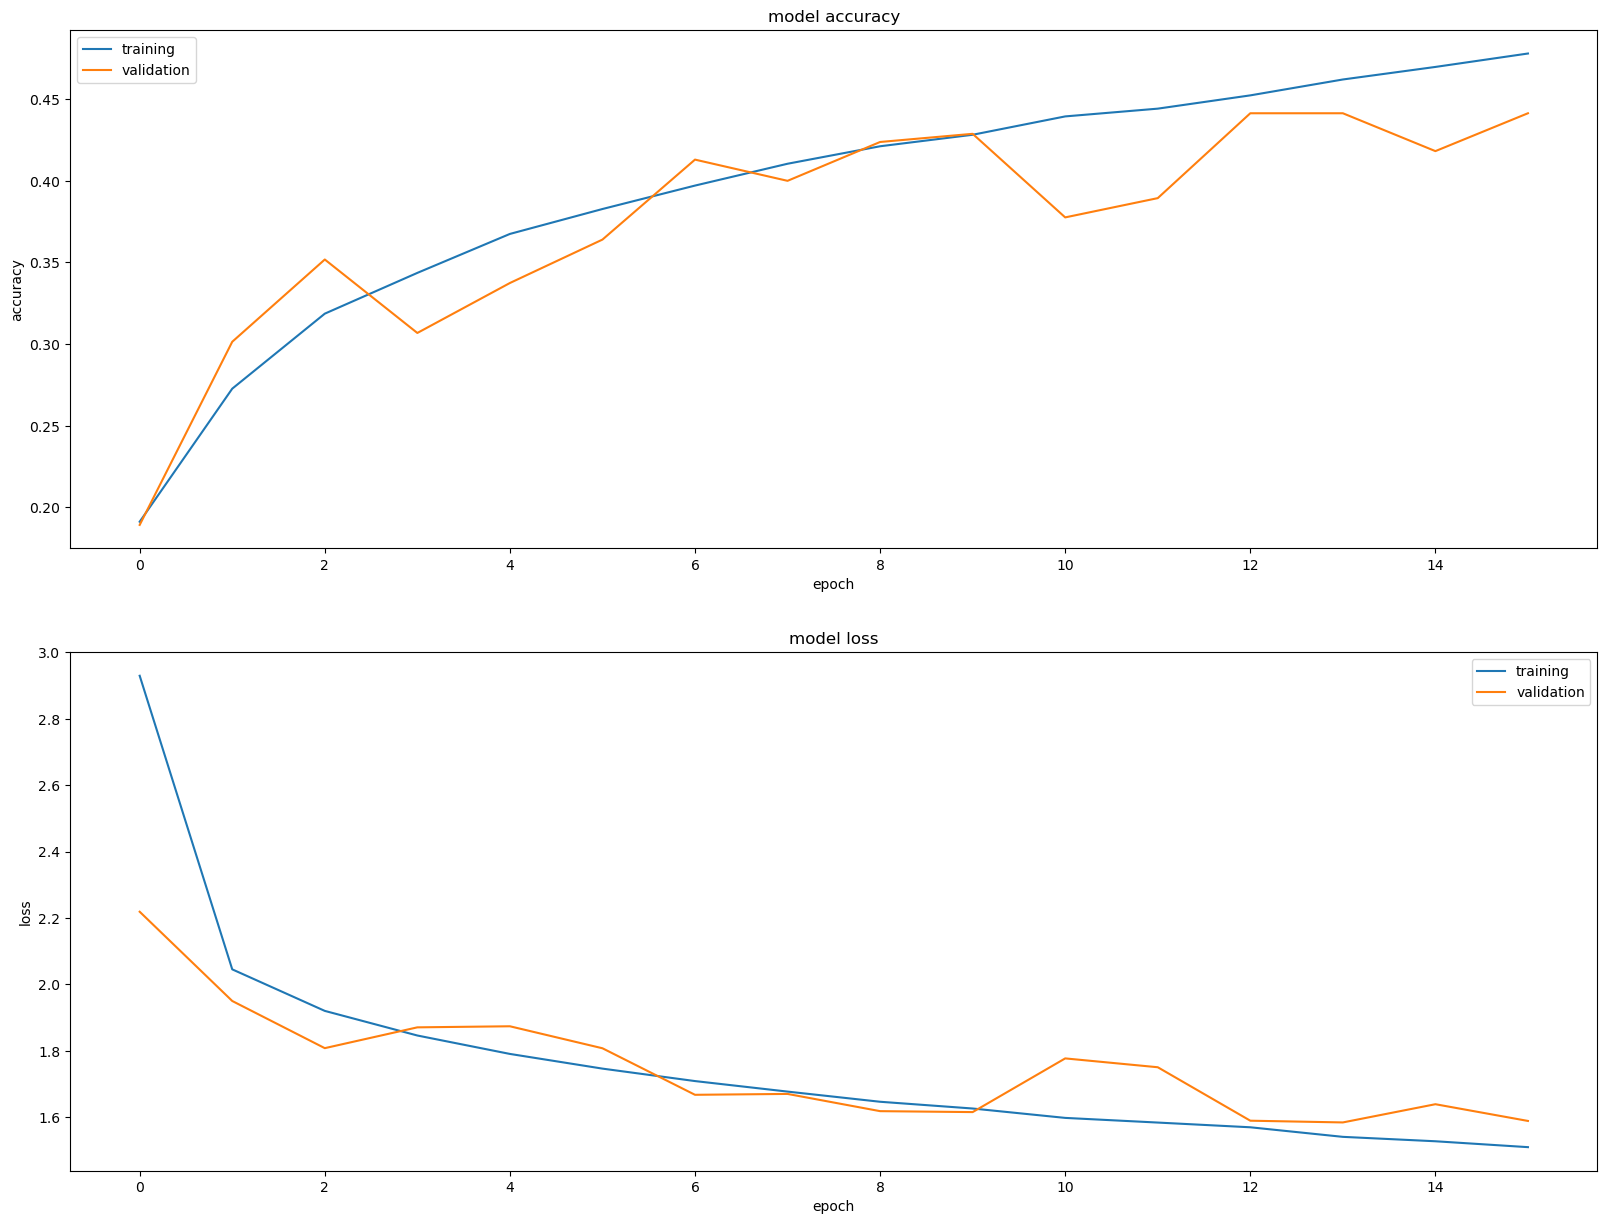

In [43]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_5.history['accuracy'], history_5.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_5.history['loss'], history_5.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 5)

In [44]:
pred_5 = model_5.predict(x_test_norm)
pred_5 = np.argmax(pred_5, axis=1)

In [45]:
print_validation_report(y_test, pred_5)

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.43      0.49      1000
           1       0.57      0.63      0.60      1000
           2       0.39      0.20      0.27      1000
           3       0.39      0.21      0.28      1000
           4       0.32      0.56      0.40      1000
           5       0.47      0.30      0.37      1000
           6       0.42      0.56      0.48      1000
           7       0.46      0.61      0.53      1000
           8       0.46      0.75      0.57      1000
           9       0.72      0.27      0.40      1000

    accuracy                           0.45     10000
   macro avg       0.48      0.45      0.44     10000
weighted avg       0.48      0.45      0.44     10000

Accuracy Score: 0.4524
Root Mean Square Error: 3.1110287687515843


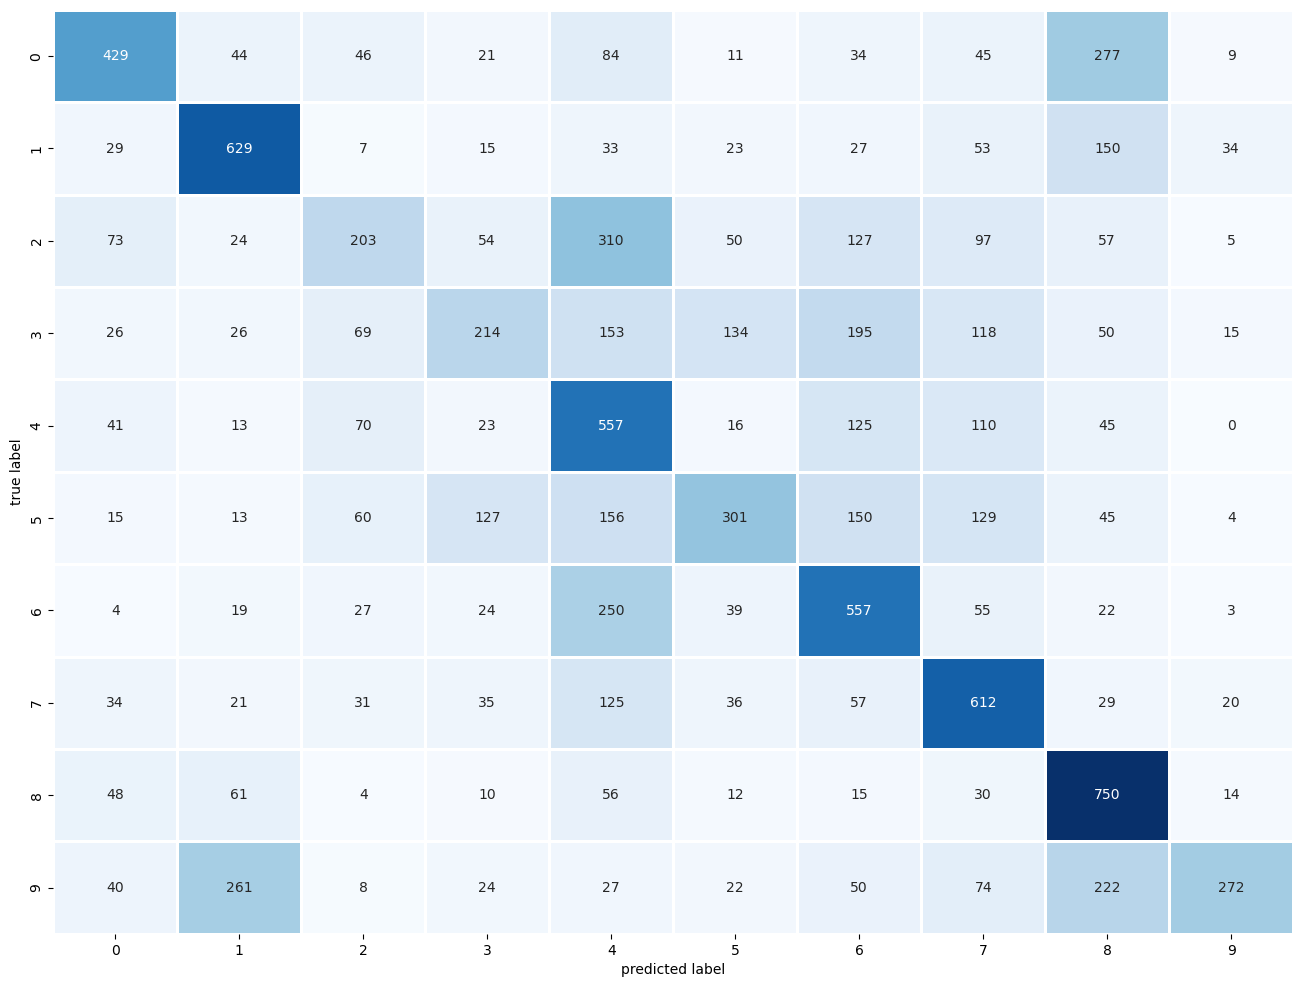

In [46]:
plot_confusion_matrix(y_test, pred_5)

# Experiment 6

In [47]:
# parameters to be adjusted 

dropout_rates = [0, 0.25, 0.5]
l2_reg = [.0001, .00005, .00001]

dropouts = []
l2 = []
train_accuracy = []
val_accuracy = []
test_accuracy = []

for i in dropout_rates:
    for j in l2_reg:

        # build model
        model = Sequential([
            Flatten(input_shape = [32, 32, 3]),
            Dense(units = 320, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(j)),
            Dropout(i),
            Dense(units = 320, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(j)),
            Dropout(i),
            Dense(units = 128, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(j)),
            Dropout(i),
            Dense(name = 'output_layer', units = 10, activation = tf.nn.softmax)
        ])

        # Compile
        model.compile(optimizer='rmsprop',
                     loss='SparseCategoricalCrossentropy',
                     metrics=['accuracy'])

        # Optimize and Fit model
        history = model.fit(
                    x_train_norm, y_train_split,
                    epochs=200, batch_size=512,
                    validation_data=(x_valid_norm, y_valid_split),
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
                    ]
            )

        train_accuracy.append(history.history.get('accuracy')[-1])
        val_accuracy.append(history.history.get('val_accuracy')[-1])

        preds = model.predict(x_test_norm)
        preds = np.argmax(preds, axis=1)
        test_accuracy.append(accuracy_score(y_test, preds))

        dropouts.append(i)
        l2.append(j)
    
dict = {'Dropout': dropouts, 'L2_reg': l2, 'train_acc': train_accuracy, 'val_acc': val_accuracy, 'test_acc': test_accuracy}

print(pd.DataFrame(dict))

Epoch 1/200
88/88 [==============================] - 3s 24ms/step - loss: 2.4463 - accuracy: 0.1769 - val_loss: 2.1136 - val_accuracy: 0.2520
Epoch 2/200
88/88 [==============================] - 2s 23ms/step - loss: 2.0486 - accuracy: 0.2689 - val_loss: 2.0144 - val_accuracy: 0.2604
Epoch 3/200
88/88 [==============================] - 2s 24ms/step - loss: 1.9343 - accuracy: 0.3093 - val_loss: 1.8643 - val_accuracy: 0.3340
Epoch 4/200
88/88 [==============================] - 2s 25ms/step - loss: 1.8646 - accuracy: 0.3371 - val_loss: 1.9767 - val_accuracy: 0.2928
Epoch 5/200
88/88 [==============================] - 2s 24ms/step - loss: 1.8109 - accuracy: 0.3574 - val_loss: 1.7941 - val_accuracy: 0.3584
Epoch 6/200
88/88 [==============================] - 2s 23ms/step - loss: 1.7728 - accuracy: 0.3720 - val_loss: 1.8197 - val_accuracy: 0.3660
Epoch 7/200
88/88 [==============================] - 2s 24ms/step - loss: 1.7419 - accuracy: 0.3872 - val_loss: 1.6834 - val_accuracy: 0.4064
Epoch 

88/88 [==============================] - 2s 28ms/step - loss: 1.9637 - accuracy: 0.2710 - val_loss: 1.9699 - val_accuracy: 0.3210
Epoch 13/200
88/88 [==============================] - 2s 26ms/step - loss: 1.9571 - accuracy: 0.2725 - val_loss: 1.9603 - val_accuracy: 0.3020
Epoch 14/200
88/88 [==============================] - 2s 27ms/step - loss: 1.9536 - accuracy: 0.2780 - val_loss: 1.9777 - val_accuracy: 0.3080
Epoch 15/200
88/88 [==============================] - 2s 26ms/step - loss: 1.9453 - accuracy: 0.2783 - val_loss: 1.9452 - val_accuracy: 0.3184
   Dropout   L2_reg  train_acc  val_acc  test_acc
0     0.00  0.00010   0.420000   0.3722    0.3821
1     0.00  0.00005   0.447222   0.4008    0.4077
2     0.00  0.00001   0.433378   0.3764    0.3927
3     0.25  0.00010   0.398956   0.4004    0.4186
4     0.25  0.00005   0.387622   0.3938    0.4123
5     0.25  0.00001   0.375956   0.4024    0.4192
6     0.50  0.00010   0.266622   0.2886    0.2962
7     0.50  0.00005   0.251356   0.2882  

In [57]:
model_6 = Sequential([
    Flatten(input_shape = [32, 32, 3]),
    Dense(units = 320, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    Dropout(0.25),
    Dense(units = 320, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    Dropout(0.25),
    Dense(units = 320, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    Dropout(0.25),
    Dense(name = 'output_layer', units = 10, activation = tf.nn.softmax)
])

In [58]:
history_6, model_6, results_6 = compile_train_model(model_6,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 3s 27ms/step - loss: 2.2933 - accuracy: 0.1760 - val_loss: 2.0948 - val_accuracy: 0.1968
Epoch 2/200
88/88 [==============================] - 2s 25ms/step - loss: 2.0409 - accuracy: 0.2518 - val_loss: 1.9307 - val_accuracy: 0.3050
Epoch 3/200
88/88 [==============================] - 2s 26ms/step - loss: 1.9672 - accuracy: 0.2864 - val_loss: 1.9314 - val_accuracy: 0.2984
Epoch 4/200
88/88 [==============================] - 2s 26ms/step - loss: 1.9200 - accuracy: 0.3073 - val_loss: 1.8918 - val_accuracy: 0.3190
Epoch 5/200
88/88 [==============================] - 2s 27ms/step - loss: 1.8710 - accuracy: 0.3252 - val_loss: 1.8990 - val_accuracy: 0.3238
Epoch 6/200
88/88 [==============================] - 3s 29ms/step - loss: 1.8443 - accuracy: 0.3416 - val_loss: 1.7922 - val_accuracy: 0.3712
Epoch 7/200
88/88 [==============================] - 2s 28ms/step - loss: 1.8123 - accuracy: 0.3487 - val_loss: 1.7453 - val_accuracy: 0.3802
Epoch 

In [59]:
print(pd.DataFrame([results_6], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      1.6302    1.6705     1.6553     0.4233   0.4044    0.4189    37


C:\Users\richd\AppData\Local\Temp\ipykernel_20228\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


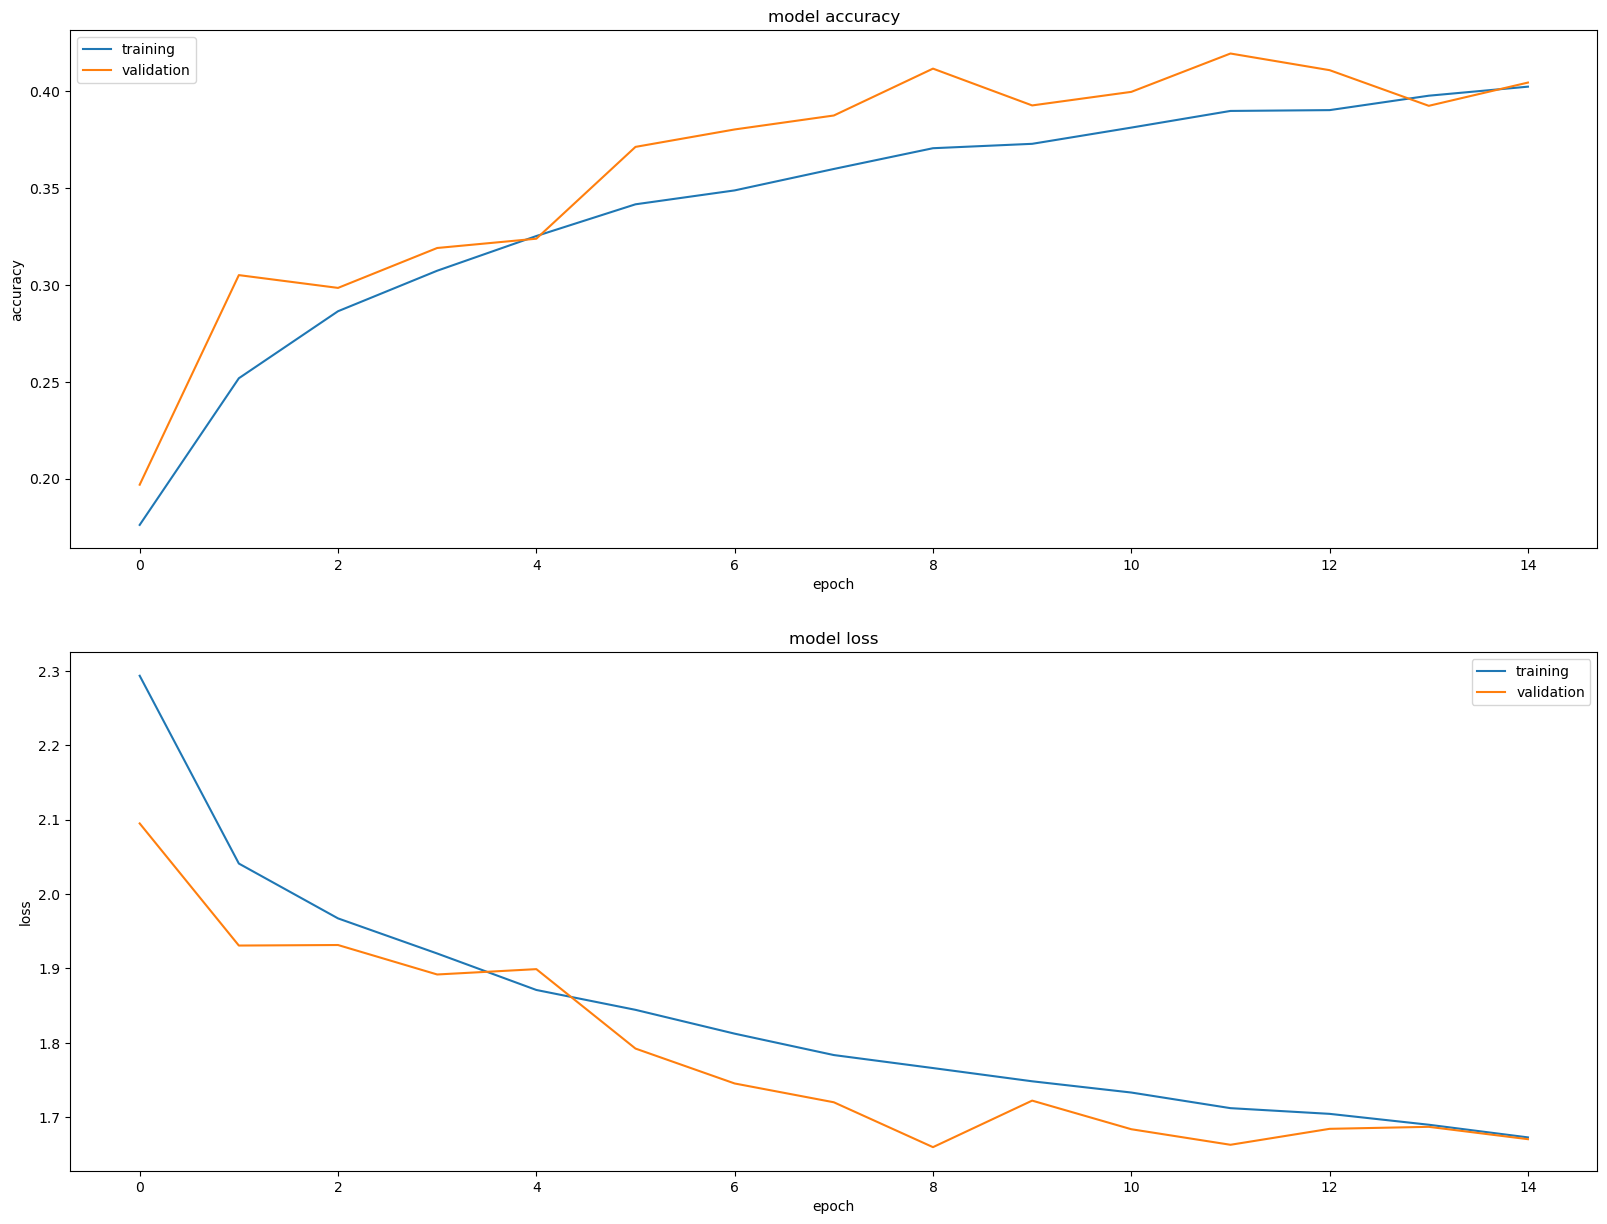

In [60]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_6.history['accuracy'], history_6.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_6.history['loss'], history_6.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 6)

In [61]:
pred_6 = model_6.predict(x_test_norm)
pred_6 = np.argmax(pred_6, axis=1)

In [62]:
print_validation_report(y_test, pred_6)

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.35      0.45      1000
           1       0.42      0.69      0.53      1000
           2       0.46      0.14      0.22      1000
           3       0.29      0.35      0.32      1000
           4       0.42      0.19      0.26      1000
           5       0.45      0.28      0.35      1000
           6       0.32      0.78      0.45      1000
           7       0.71      0.27      0.39      1000
           8       0.52      0.62      0.56      1000
           9       0.44      0.51      0.47      1000

    accuracy                           0.42     10000
   macro avg       0.47      0.42      0.40     10000
weighted avg       0.47      0.42      0.40     10000

Accuracy Score: 0.4189
Root Mean Square Error: 3.3219271515191298


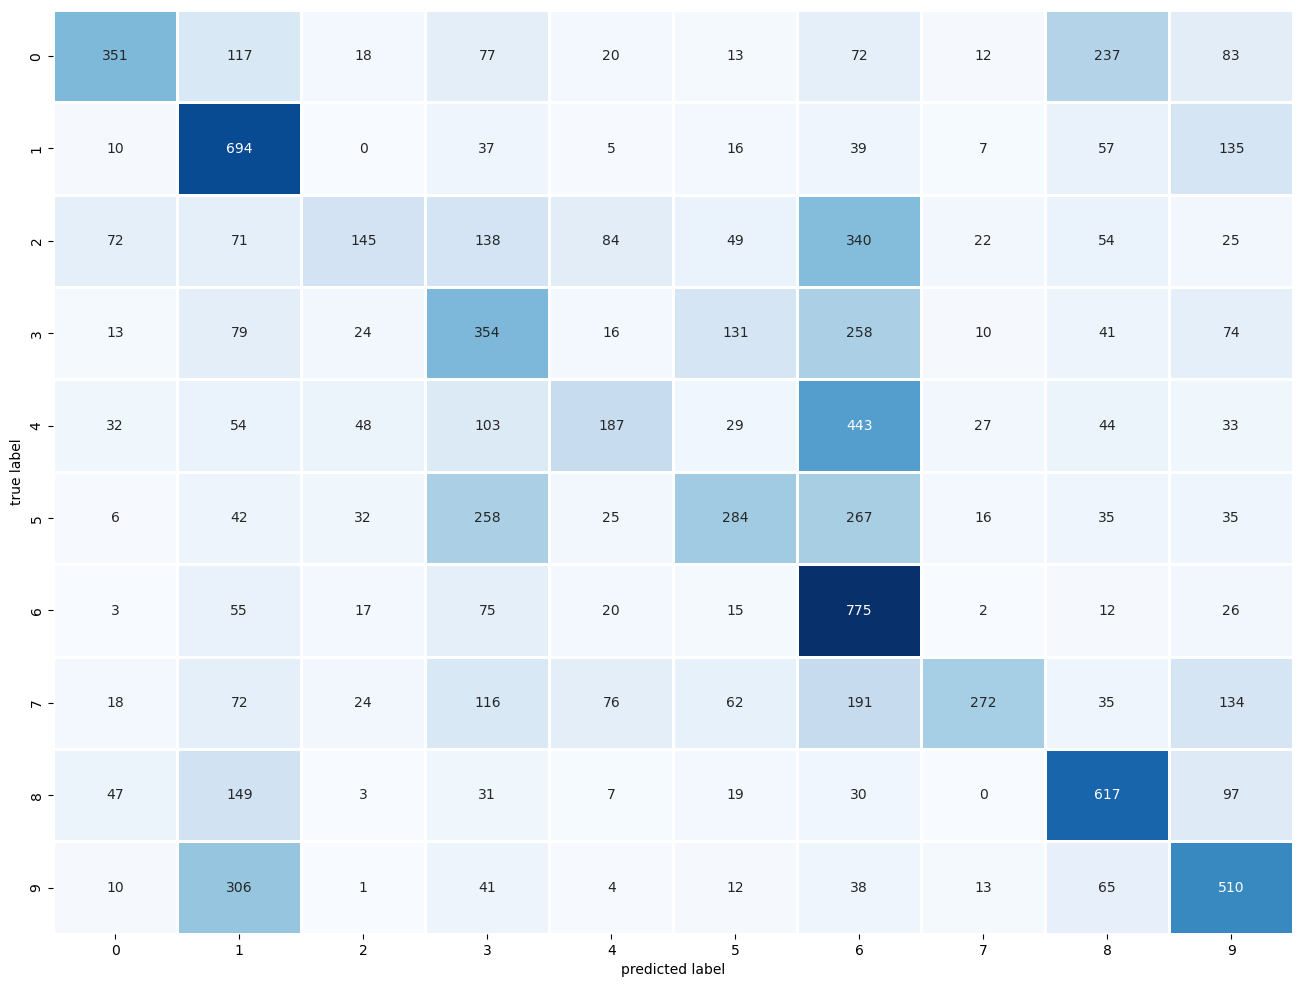

In [63]:
plot_confusion_matrix(y_test, pred_6)

# Experiment 7

In [64]:
dropout_rates = [0, 0.25, 0.5]
l2_reg = [.0001, .00005, .00001]

dropouts = []
l2 = []
train_accuracy = []
val_accuracy = []
test_accuracy = []

for i in dropout_rates:
    for j in l2_reg:

        # build model
        model = Sequential([
            Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
            MaxPool2D((2, 2),strides=2),
            Dropout(i),
            Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
            MaxPool2D((2, 2),strides=2),
            Dropout(i),
            Flatten(),
            Dense(units=128,activation=tf.nn.softmax, kernel_regularizer=tf.keras.regularizers.L2(j)),
            Dropout(i),
            Dense(units=10, activation=tf.nn.softmax)       
        ])

        # Compile
        model.compile(optimizer='rmsprop',
                     loss='SparseCategoricalCrossentropy',
                     metrics=['accuracy'])

        # Optimize and Fit model
        history = model.fit(
                    x_train_norm, y_train_split,
                    epochs=200, batch_size=512,
                    validation_data=(x_valid_norm, y_valid_split),
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
                    ]
            )

        train_accuracy.append(history.history.get('accuracy')[-1])
        val_accuracy.append(history.history.get('val_accuracy')[-1])

        preds = model.predict(x_test_norm)
        preds = np.argmax(preds, axis=1)
        test_accuracy.append(accuracy_score(y_test, preds))

        dropouts.append(i)
        l2.append(j)
    
dict = {'Dropout': dropouts, 'L2_reg': l2, 'train_acc': train_accuracy, 'val_acc': val_accuracy, 'test_acc': test_accuracy}

print(pd.DataFrame(dict))

Epoch 1/200
88/88 [==============================] - 31s 345ms/step - loss: 2.2482 - accuracy: 0.1894 - val_loss: 2.2076 - val_accuracy: 0.2568
Epoch 2/200
88/88 [==============================] - 31s 355ms/step - loss: 2.1716 - accuracy: 0.2637 - val_loss: 2.1445 - val_accuracy: 0.2716
Epoch 3/200
88/88 [==============================] - 31s 357ms/step - loss: 2.1112 - accuracy: 0.2996 - val_loss: 2.0890 - val_accuracy: 0.3098
Epoch 4/200
88/88 [==============================] - 32s 360ms/step - loss: 2.0544 - accuracy: 0.3181 - val_loss: 2.0253 - val_accuracy: 0.3368
Epoch 5/200
88/88 [==============================] - 32s 359ms/step - loss: 2.0001 - accuracy: 0.3436 - val_loss: 1.9916 - val_accuracy: 0.3368
Epoch 6/200
88/88 [==============================] - 32s 359ms/step - loss: 1.9487 - accuracy: 0.3539 - val_loss: 1.9261 - val_accuracy: 0.3506
Epoch 7/200
88/88 [==============================] - 32s 359ms/step - loss: 1.8956 - accuracy: 0.3672 - val_loss: 1.8922 - val_accuracy:

Epoch 15/200
88/88 [==============================] - 33s 376ms/step - loss: 1.4935 - accuracy: 0.4988 - val_loss: 1.4931 - val_accuracy: 0.4922
Epoch 16/200
88/88 [==============================] - 33s 377ms/step - loss: 1.4544 - accuracy: 0.5045 - val_loss: 1.4814 - val_accuracy: 0.4904
Epoch 17/200
88/88 [==============================] - 34s 391ms/step - loss: 1.4132 - accuracy: 0.5165 - val_loss: 1.4626 - val_accuracy: 0.4898
Epoch 18/200
88/88 [==============================] - 36s 411ms/step - loss: 1.3761 - accuracy: 0.5277 - val_loss: 1.3944 - val_accuracy: 0.5148
Epoch 19/200
88/88 [==============================] - 38s 436ms/step - loss: 1.3406 - accuracy: 0.5364 - val_loss: 1.3787 - val_accuracy: 0.5142
Epoch 20/200
88/88 [==============================] - 34s 385ms/step - loss: 1.3091 - accuracy: 0.5507 - val_loss: 1.3530 - val_accuracy: 0.5260
Epoch 21/200
88/88 [==============================] - 34s 383ms/step - loss: 1.2750 - accuracy: 0.5653 - val_loss: 1.3241 - val_ac

Epoch 20/200
88/88 [==============================] - 43s 483ms/step - loss: 1.5463 - accuracy: 0.4548 - val_loss: 1.4015 - val_accuracy: 0.5626
Epoch 21/200
88/88 [==============================] - 38s 435ms/step - loss: 1.5201 - accuracy: 0.4630 - val_loss: 1.4037 - val_accuracy: 0.5522
Epoch 22/200
88/88 [==============================] - 39s 444ms/step - loss: 1.4974 - accuracy: 0.4680 - val_loss: 1.4113 - val_accuracy: 0.5388
Epoch 23/200
88/88 [==============================] - 39s 441ms/step - loss: 1.4826 - accuracy: 0.4719 - val_loss: 1.3203 - val_accuracy: 0.5766
Epoch 24/200
88/88 [==============================] - 39s 445ms/step - loss: 1.4664 - accuracy: 0.4767 - val_loss: 1.3044 - val_accuracy: 0.5834
Epoch 25/200
88/88 [==============================] - 43s 492ms/step - loss: 1.4498 - accuracy: 0.4792 - val_loss: 1.2796 - val_accuracy: 0.5916
Epoch 26/200
88/88 [==============================] - 39s 448ms/step - loss: 1.4317 - accuracy: 0.4837 - val_loss: 1.2612 - val_ac

Epoch 13/200
88/88 [==============================] - 40s 450ms/step - loss: 1.8664 - accuracy: 0.3336 - val_loss: 1.7181 - val_accuracy: 0.4752
Epoch 14/200
88/88 [==============================] - 40s 455ms/step - loss: 1.8464 - accuracy: 0.3394 - val_loss: 1.7043 - val_accuracy: 0.4880
Epoch 15/200
88/88 [==============================] - 40s 452ms/step - loss: 1.8290 - accuracy: 0.3458 - val_loss: 1.6935 - val_accuracy: 0.4770
Epoch 16/200
88/88 [==============================] - 40s 451ms/step - loss: 1.8042 - accuracy: 0.3567 - val_loss: 1.6359 - val_accuracy: 0.5142
Epoch 17/200
88/88 [==============================] - 40s 452ms/step - loss: 1.7961 - accuracy: 0.3614 - val_loss: 1.6500 - val_accuracy: 0.4996
Epoch 18/200
88/88 [==============================] - 38s 430ms/step - loss: 1.7761 - accuracy: 0.3673 - val_loss: 1.6016 - val_accuracy: 0.5106
Epoch 19/200
88/88 [==============================] - 34s 390ms/step - loss: 1.7623 - accuracy: 0.3728 - val_loss: 1.5913 - val_ac

In [65]:
k.clear_session()
model_7 = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Flatten(),
    Dense(units=128,activation=tf.nn.softmax, kernel_regularizer=tf.keras.regularizers.L2(0.00001)),
    Dropout(0.25),
    Dense(units=10, activation=tf.nn.softmax)       
])

model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

In [66]:
history_7, model_7, results_7 = compile_train_model(model_7,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 37s 417ms/step - loss: 2.2476 - accuracy: 0.1959 - val_loss: 2.2008 - val_accuracy: 0.2700
Epoch 2/200
88/88 [==============================] - 42s 476ms/step - loss: 2.1872 - accuracy: 0.2572 - val_loss: 2.1495 - val_accuracy: 0.2930
Epoch 3/200
88/88 [==============================] - 43s 488ms/step - loss: 2.1337 - accuracy: 0.2832 - val_loss: 2.0957 - val_accuracy: 0.3228
Epoch 4/200
88/88 [==============================] - 43s 486ms/step - loss: 2.0833 - accuracy: 0.3052 - val_loss: 2.0422 - val_accuracy: 0.3716
Epoch 5/200
88/88 [==============================] - 54s 618ms/step - loss: 2.0364 - accuracy: 0.3252 - val_loss: 1.9918 - val_accuracy: 0.3938
Epoch 6/200
88/88 [==============================] - 54s 615ms/step - loss: 1.9842 - accuracy: 0.3461 - val_loss: 1.9566 - val_accuracy: 0.4062
Epoch 7/200
88/88 [==============================] - 55s 627ms/step - loss: 1.9396 - accuracy: 0.3606 - val_loss: 1.8870 - val_accuracy:

In [67]:
print(pd.DataFrame([results_7], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      1.1514    1.2246      1.226     0.6548   0.6124    0.6185  1401


C:\Users\richd\AppData\Local\Temp\ipykernel_20228\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


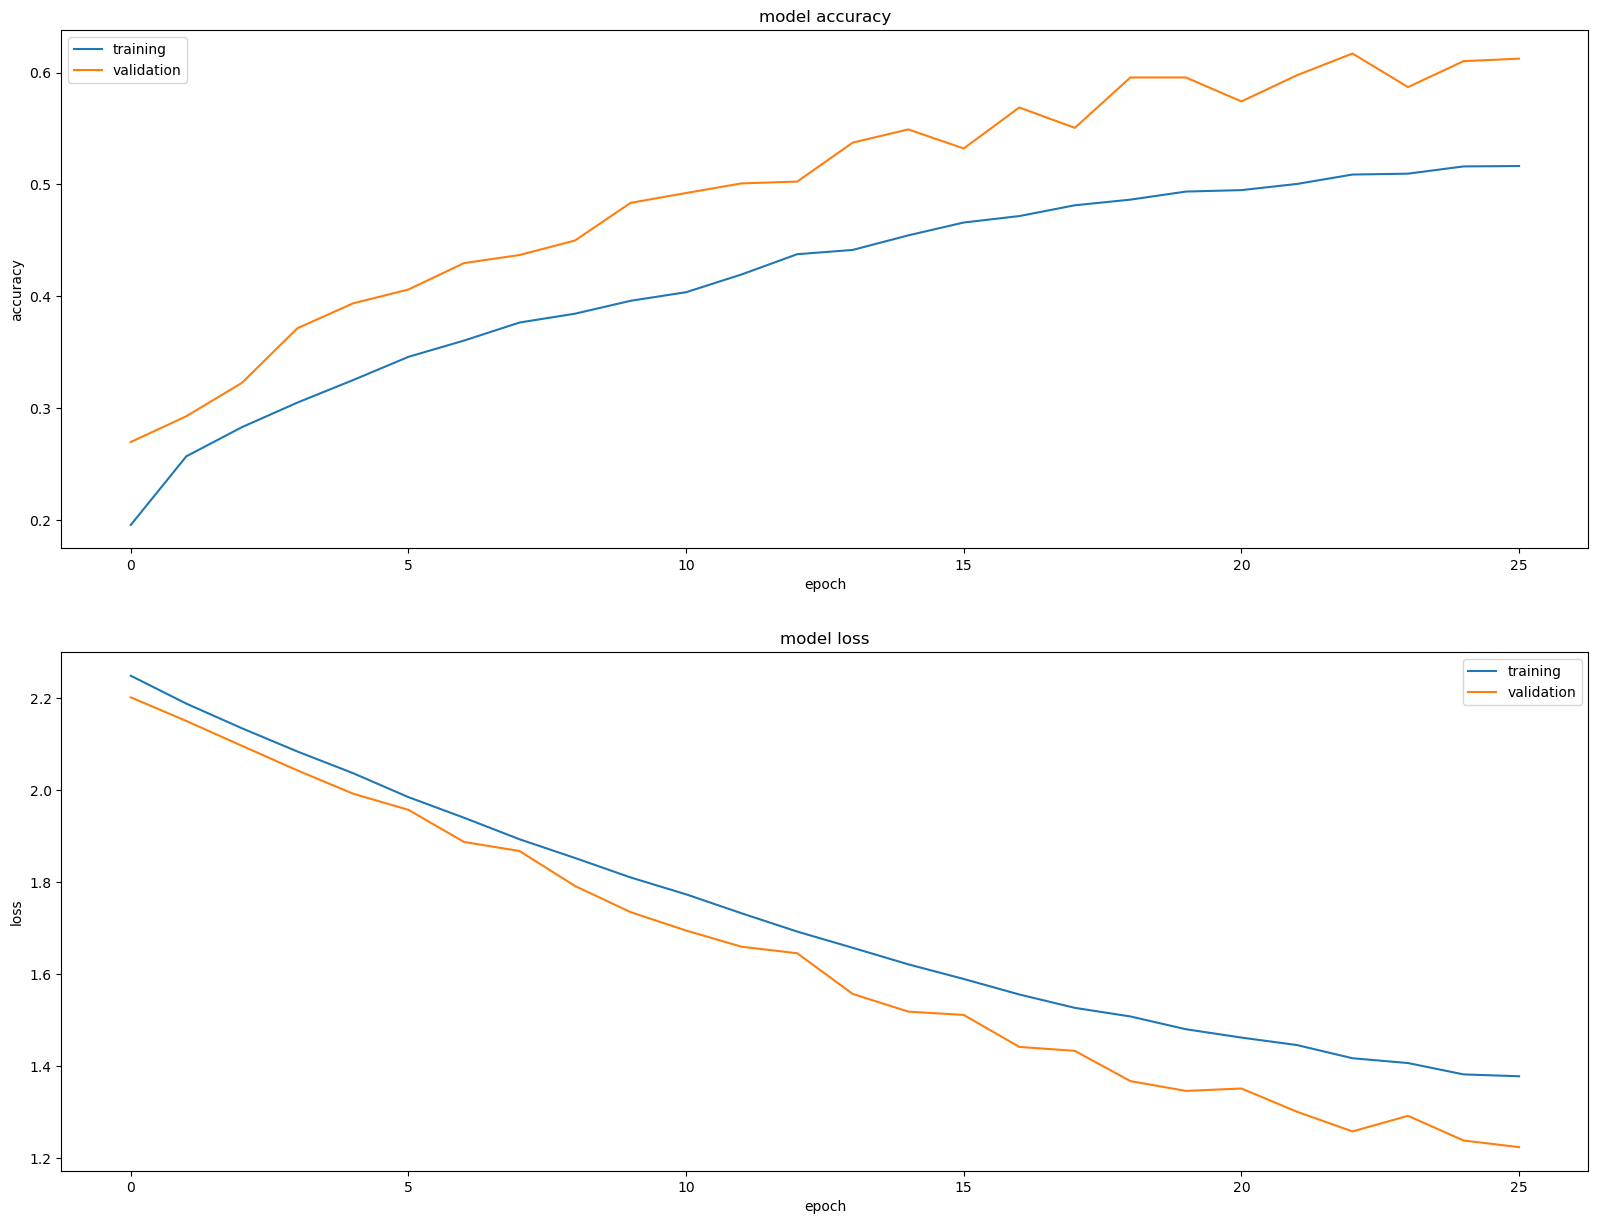

In [68]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_7.history['accuracy'], history_7.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_7.history['loss'], history_7.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 7)

In [69]:
pred_7 = model_7.predict(x_test_norm)
pred_7 = np.argmax(pred_7, axis=1)

In [70]:
print_validation_report(y_test, pred_7)

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.77      0.69      1000
           1       0.83      0.73      0.78      1000
           2       0.51      0.54      0.52      1000
           3       0.28      0.13      0.17      1000
           4       0.67      0.41      0.51      1000
           5       0.38      0.73      0.50      1000
           6       0.84      0.64      0.73      1000
           7       0.65      0.76      0.70      1000
           8       0.77      0.75      0.76      1000
           9       0.74      0.74      0.74      1000

    accuracy                           0.62     10000
   macro avg       0.63      0.62      0.61     10000
weighted avg       0.63      0.62      0.61     10000

Accuracy Score: 0.6185
Root Mean Square Error: 2.5272712557222663


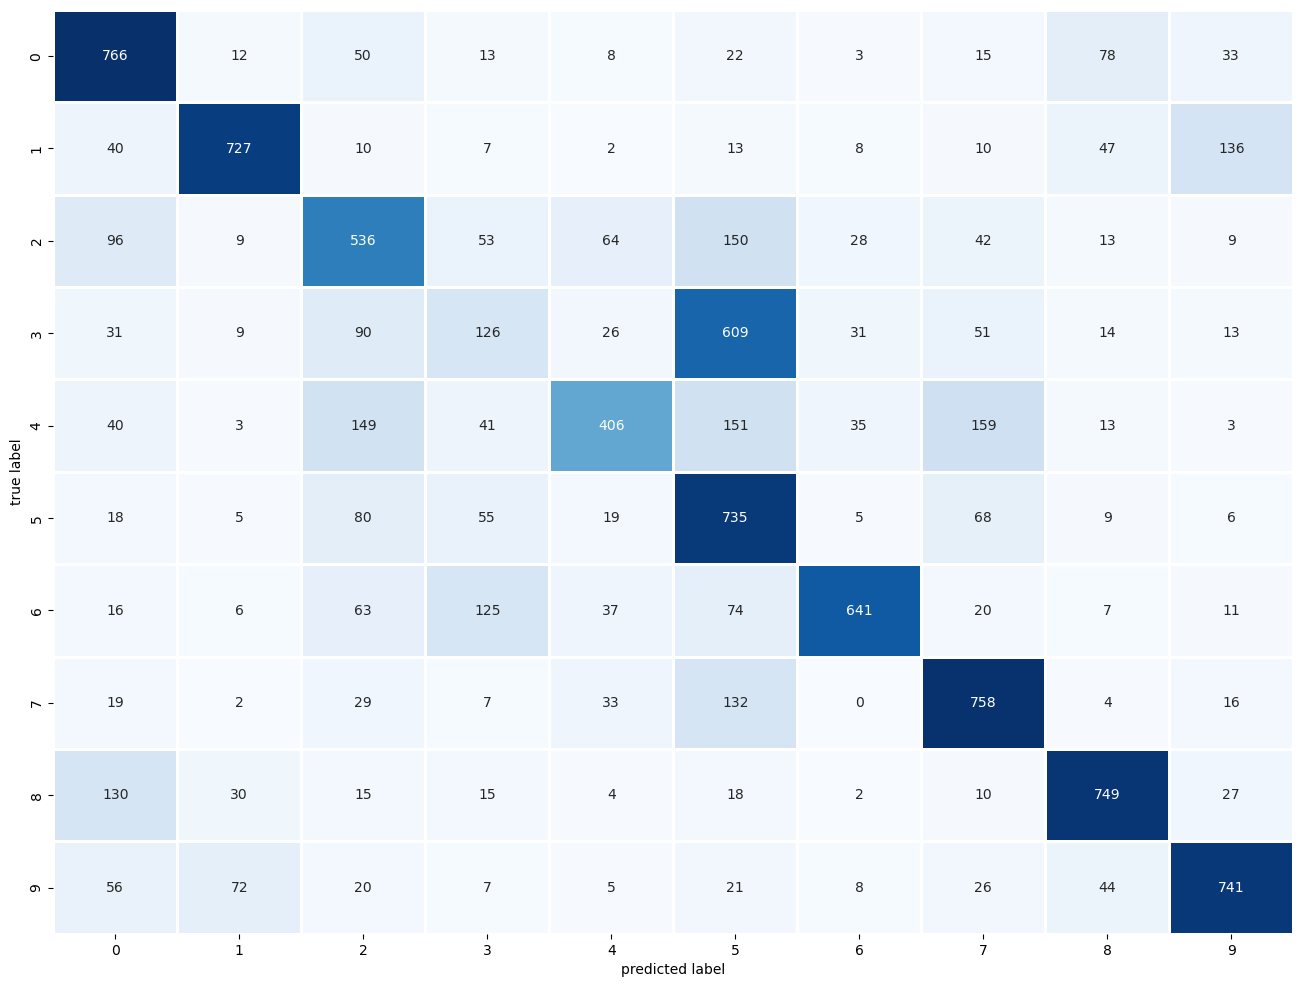

In [71]:
plot_confusion_matrix(y_test, pred_7)

# Experiment 8

In [ ]:
# dropout_rates = [0.25, 0.5]
l2_reg = [.00005, .00001]

dropouts = []
l2 = []
train_accuracy = []
val_accuracy = []
test_accuracy = []

for i in dropout_rates:
    for j in l2_reg:

        # build model
        model = Sequential([
            Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
            MaxPool2D((2, 2),strides=2),
            Dropout(i),
            Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
            MaxPool2D((2, 2),strides=2),
            Dropout(i),
            Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
            MaxPool2D((2, 2),strides=2),
            Dropout(i),
            Flatten(),
            Dense(units=128,activation=tf.nn.softmax, kernel_regularizer=tf.keras.regularizers.L2(j)),
            Dropout(i),
            Dense(units=10, activation=tf.nn.softmax)       
        ])

        # Compile
        model.compile(optimizer='rmsprop',
                     loss='SparseCategoricalCrossentropy',
                     metrics=['accuracy'])

        # Optimize and Fit model
        history = model.fit(
                    x_train_norm, y_train_split,
                    epochs=200, batch_size=512,
                    validation_data=(x_valid_norm, y_valid_split),
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
                    ]
            )

        train_accuracy.append(history.history.get('accuracy')[-1])
        val_accuracy.append(history.history.get('val_accuracy')[-1])

        preds = model.predict(x_test_norm)
        preds = np.argmax(preds, axis=1)
        test_accuracy.append(accuracy_score(y_test, preds))

        dropouts.append(i)
        l2.append(j)
    
dict = {'Dropout': dropouts, 'L2_reg': l2, 'train_acc': train_accuracy, 'val_acc': val_accuracy, 'test_acc': test_accuracy}

print(pd.DataFrame(dict))

In [73]:
print(pd.DataFrame(dict))

   Dropout   L2_reg  train_acc  val_acc  test_acc
0     0.25  0.00005   0.605089   0.6954    0.6887
1     0.25  0.00001   0.699422   0.7482    0.7526
2     0.50  0.00005   0.499711   0.6700    0.6699
3     0.50  0.00001   0.487644   0.6268    0.6283


In [75]:
k.clear_session()
model_8 = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),    
    Flatten(),
    Dense(units=128,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(.00001)),
    Dropout(0.25),
    Dense(units=10, activation=tf.nn.softmax)       
])

model_8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

In [76]:
history_8, model_8, results_8 = compile_train_model(model_8,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 54s 609ms/step - loss: 2.2696 - accuracy: 0.1515 - val_loss: 2.2344 - val_accuracy: 0.2038
Epoch 2/200
88/88 [==============================] - 56s 639ms/step - loss: 2.2060 - accuracy: 0.2168 - val_loss: 2.2186 - val_accuracy: 0.2002
Epoch 3/200
88/88 [==============================] - 56s 638ms/step - loss: 2.1573 - accuracy: 0.2415 - val_loss: 2.1117 - val_accuracy: 0.2882
Epoch 4/200
88/88 [==============================] - 57s 653ms/step - loss: 2.1113 - accuracy: 0.2534 - val_loss: 2.0663 - val_accuracy: 0.3246
Epoch 5/200
88/88 [==============================] - 61s 697ms/step - loss: 2.0700 - accuracy: 0.2632 - val_loss: 2.0393 - val_accuracy: 0.2892
Epoch 6/200
88/88 [==============================] - 66s 752ms/step - loss: 2.0292 - accuracy: 0.2768 - val_loss: 1.9623 - val_accuracy: 0.3570
Epoch 7/200
88/88 [==============================] - 70s 796ms/step - loss: 1.9887 - accuracy: 0.2888 - val_loss: 1.9344 - val_accuracy:

In [77]:
print(pd.DataFrame([results_8], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      1.1369     1.215       1.23     0.6655   0.6198    0.6217  1788


C:\Users\richd\AppData\Local\Temp\ipykernel_20228\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


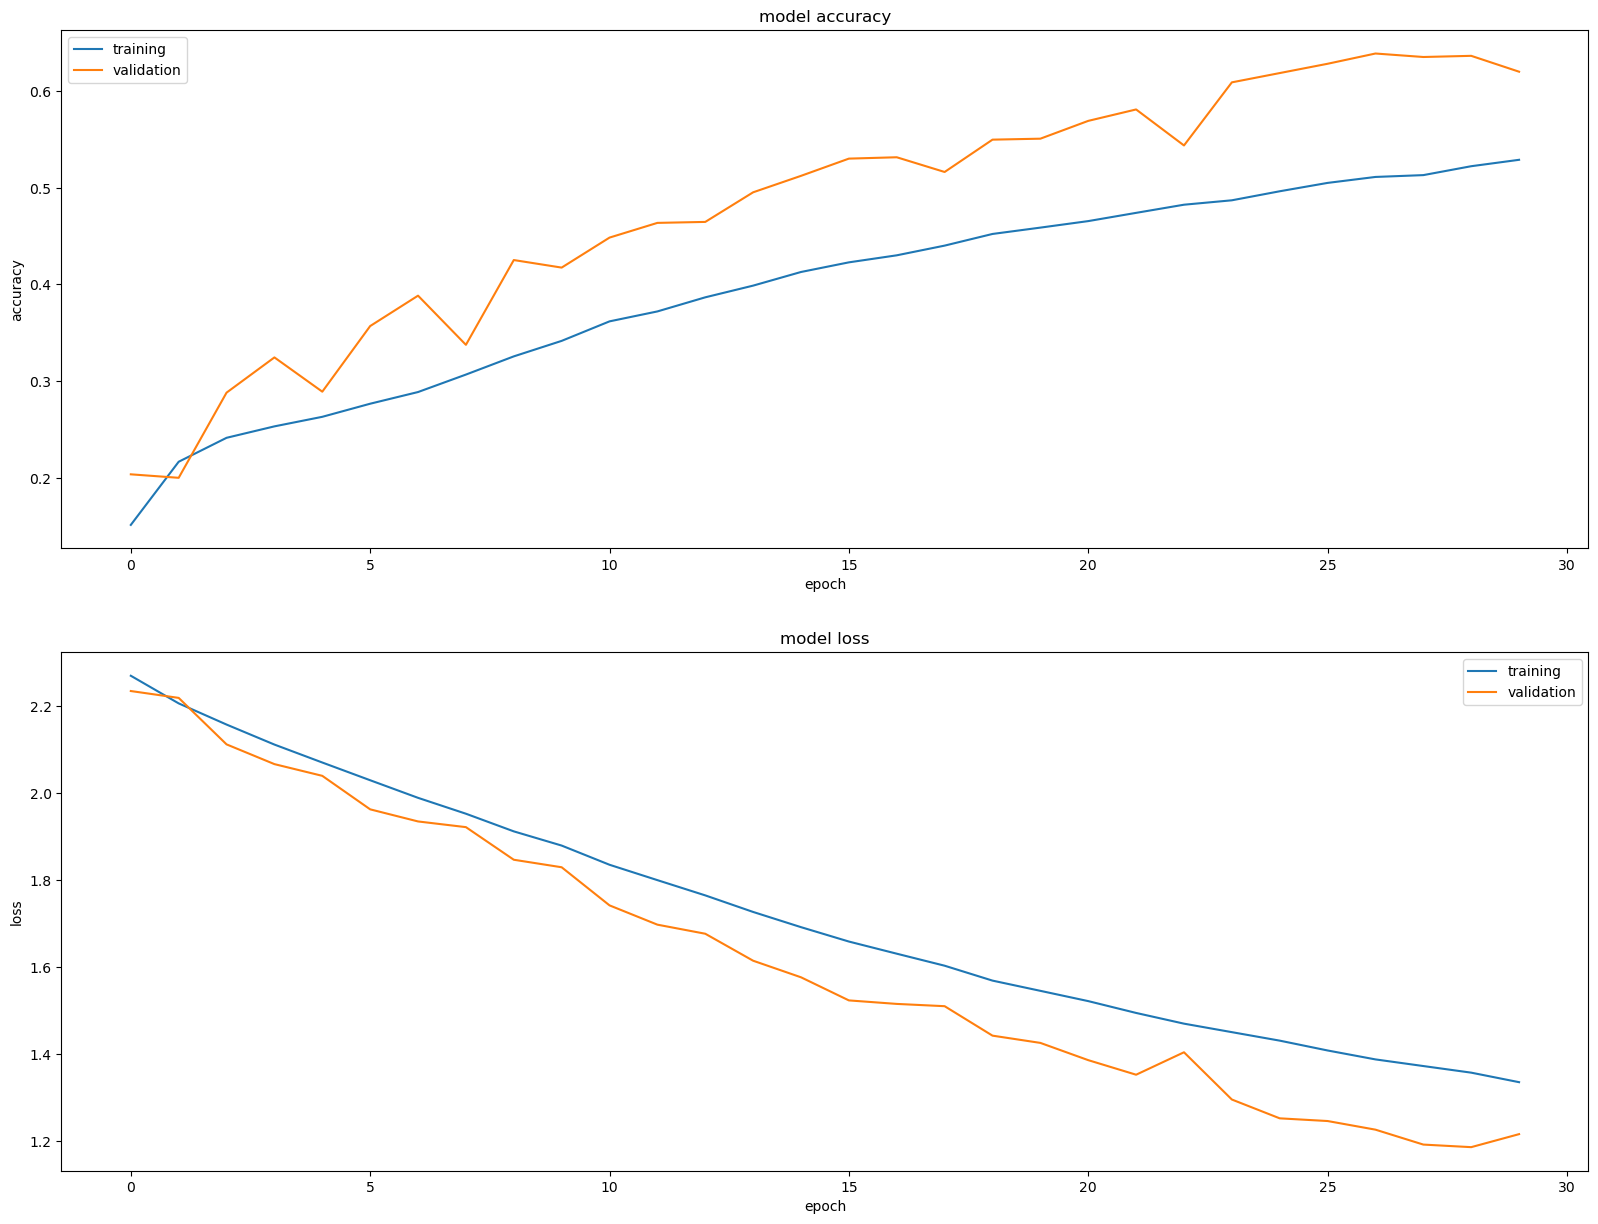

In [78]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_8.history['accuracy'], history_8.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_8.history['loss'], history_8.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 8)

In [79]:
pred_8 = model_8.predict(x_test_norm)
pred_8 = np.argmax(pred_8, axis=1)

In [80]:
print_validation_report(y_test, pred_8)

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.67      0.66      1000
           1       0.90      0.74      0.81      1000
           2       0.52      0.44      0.48      1000
           3       0.36      0.29      0.32      1000
           4       0.53      0.51      0.52      1000
           5       0.42      0.77      0.55      1000
           6       0.89      0.54      0.67      1000
           7       0.64      0.78      0.71      1000
           8       0.81      0.68      0.74      1000
           9       0.77      0.79      0.78      1000

    accuracy                           0.62     10000
   macro avg       0.65      0.62      0.62     10000
weighted avg       0.65      0.62      0.62     10000

Accuracy Score: 0.6217
Root Mean Square Error: 2.4427443582986736


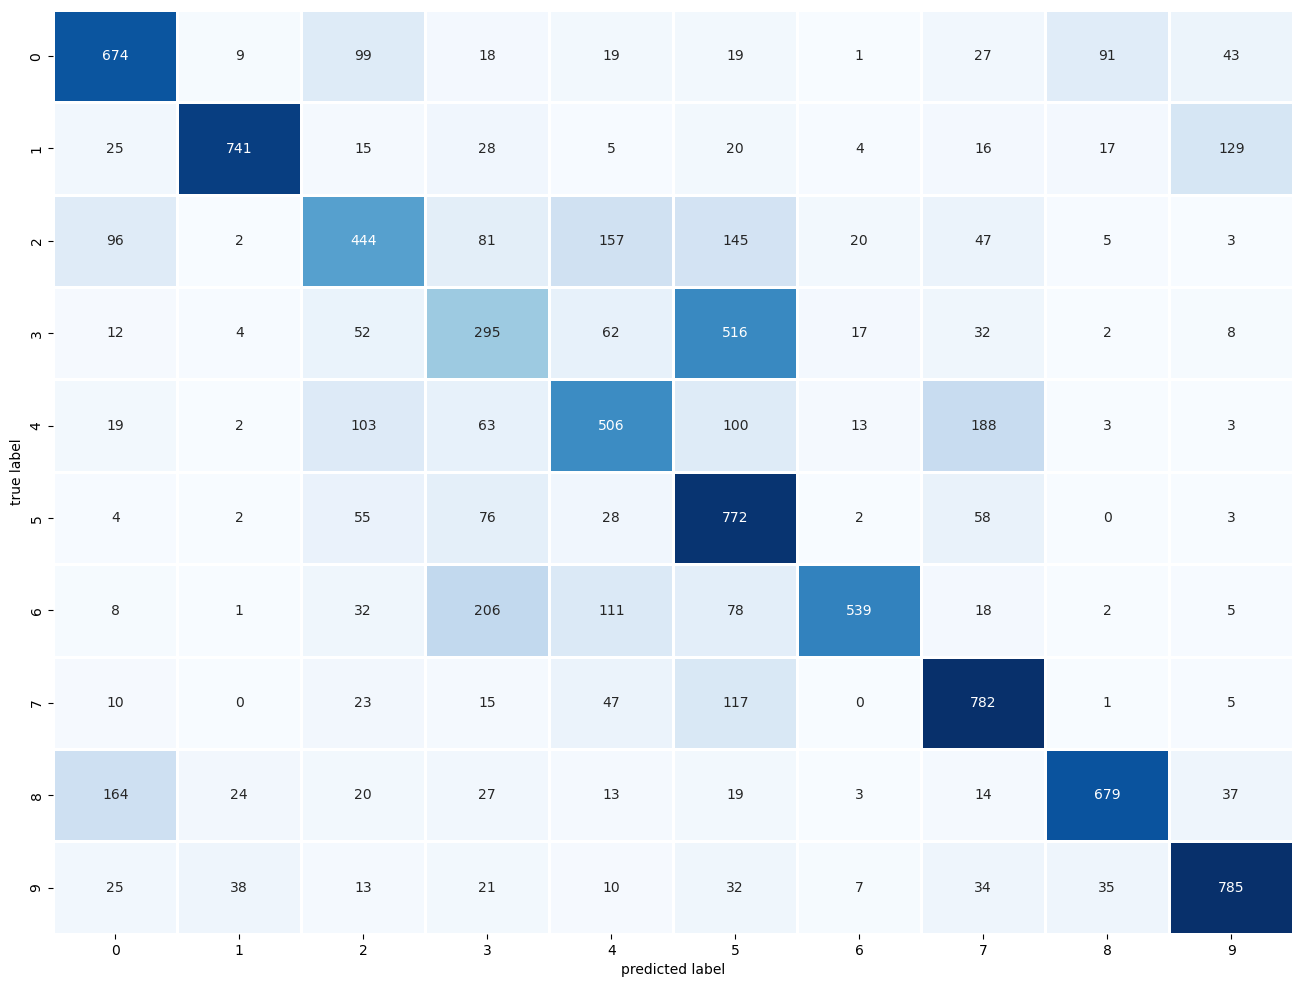

In [81]:
plot_confusion_matrix(y_test, pred_8)

# Experiment 9

In [82]:
# Batch Normalization
k.clear_session()
model_9 = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Flatten(),
    Dense(units=128,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(.00005)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(units=10, activation=tf.nn.softmax)       
])

model_9.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

In [83]:
history_9, model_9, results_9 = compile_train_model(model_9,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 60s 672ms/step - loss: 1.8513 - accuracy: 0.3270 - val_loss: 2.2408 - val_accuracy: 0.1398
Epoch 2/200
88/88 [==============================] - 60s 678ms/step - loss: 1.4969 - accuracy: 0.4648 - val_loss: 2.1960 - val_accuracy: 0.1818
Epoch 3/200
88/88 [==============================] - 57s 646ms/step - loss: 1.3403 - accuracy: 0.5268 - val_loss: 2.0938 - val_accuracy: 0.2582
Epoch 4/200
88/88 [==============================] - 64s 722ms/step - loss: 1.2259 - accuracy: 0.5700 - val_loss: 1.8836 - val_accuracy: 0.4356
Epoch 5/200
88/88 [==============================] - 59s 668ms/step - loss: 1.1405 - accuracy: 0.6034 - val_loss: 1.6380 - val_accuracy: 0.5560
Epoch 6/200
88/88 [==============================] - 57s 647ms/step - loss: 1.0677 - accuracy: 0.6318 - val_loss: 1.3322 - val_accuracy: 0.6296
Epoch 7/200
88/88 [==============================] - 55s 623ms/step - loss: 1.0124 - accuracy: 0.6520 - val_loss: 1.2170 - val_accuracy:

In [84]:
print(pd.DataFrame([results_9], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      0.4068    0.6851     0.7038     0.8754   0.7718    0.7696  1247


C:\Users\richd\AppData\Local\Temp\ipykernel_20228\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


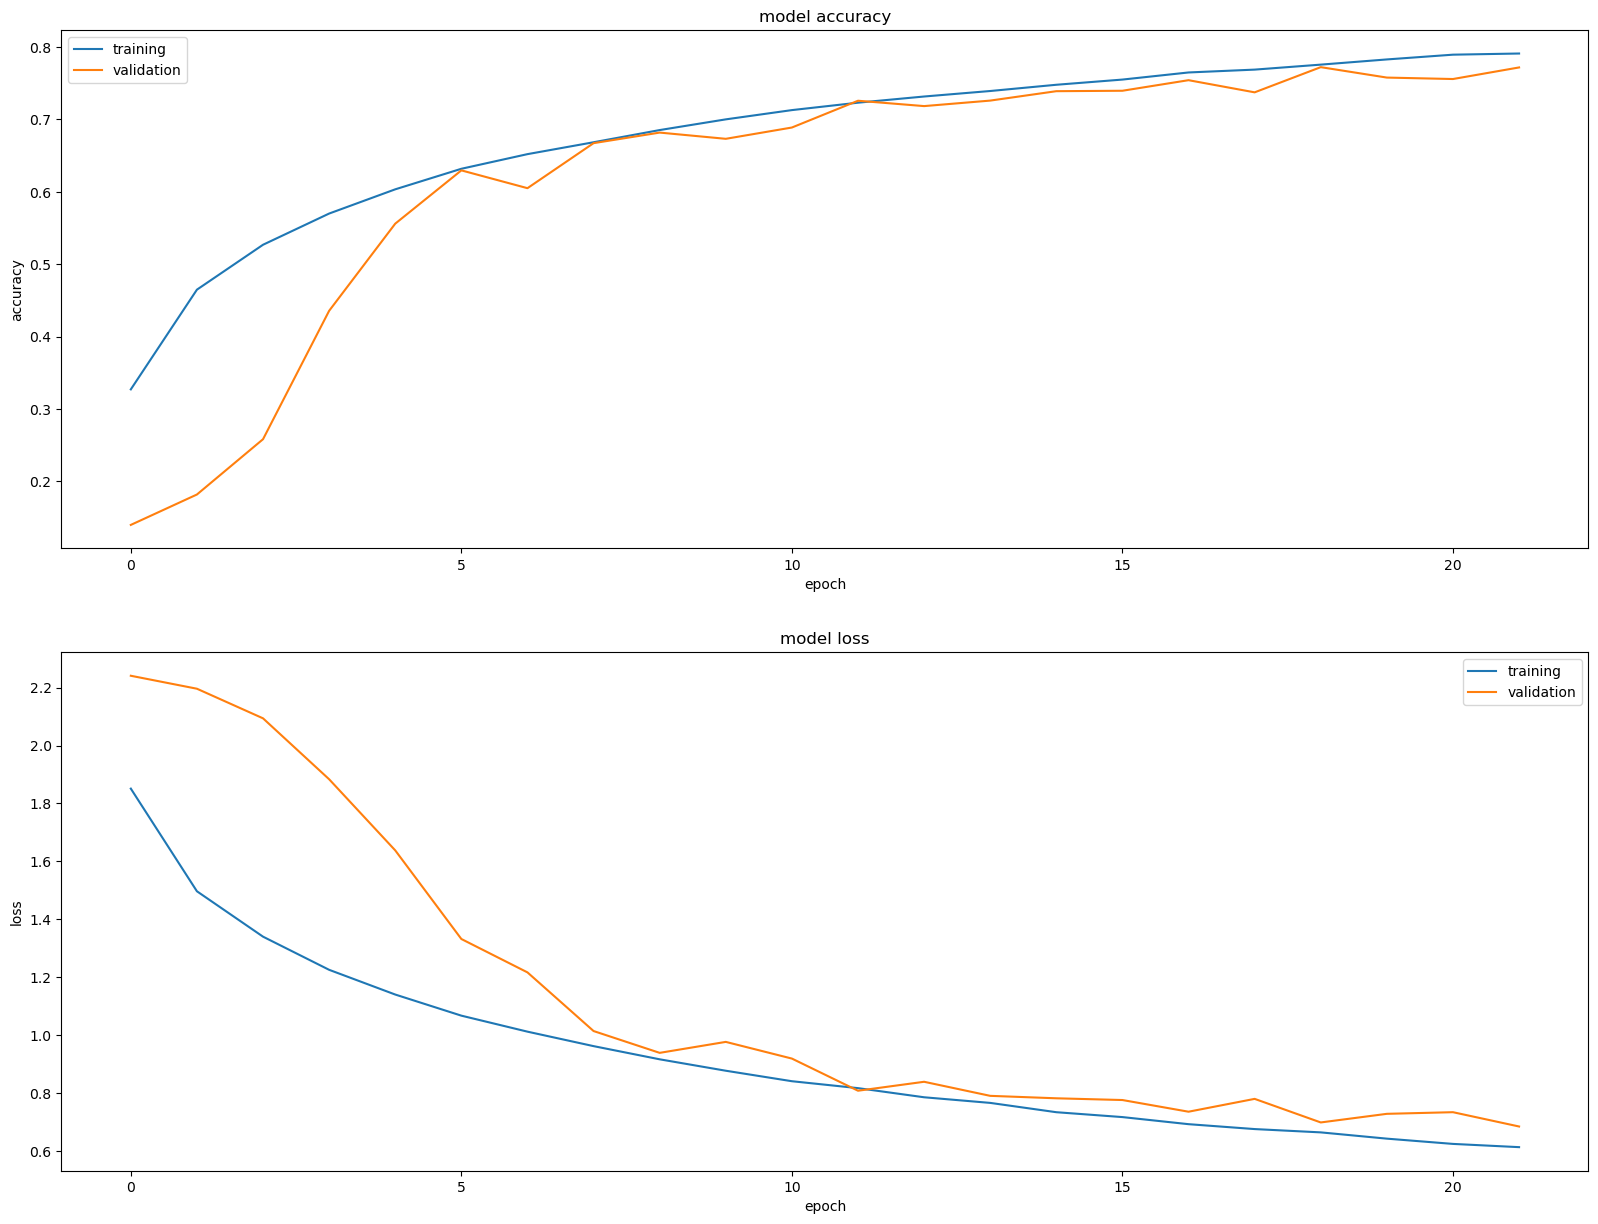

In [85]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_9.history['accuracy'], history_9.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_9.history['loss'], history_9.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 9)

In [86]:
pred_9 = model_9.predict(x_test_norm)
pred_9 = np.argmax(pred_9, axis=1)

In [87]:
print_validation_report(y_test, pred_9)

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1000
           1       0.88      0.88      0.88      1000
           2       0.69      0.66      0.67      1000
           3       0.63      0.55      0.59      1000
           4       0.69      0.78      0.73      1000
           5       0.70      0.69      0.69      1000
           6       0.78      0.85      0.81      1000
           7       0.83      0.79      0.81      1000
           8       0.81      0.90      0.85      1000
           9       0.92      0.76      0.83      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

Accuracy Score: 0.7696
Root Mean Square Error: 1.9549424543960368


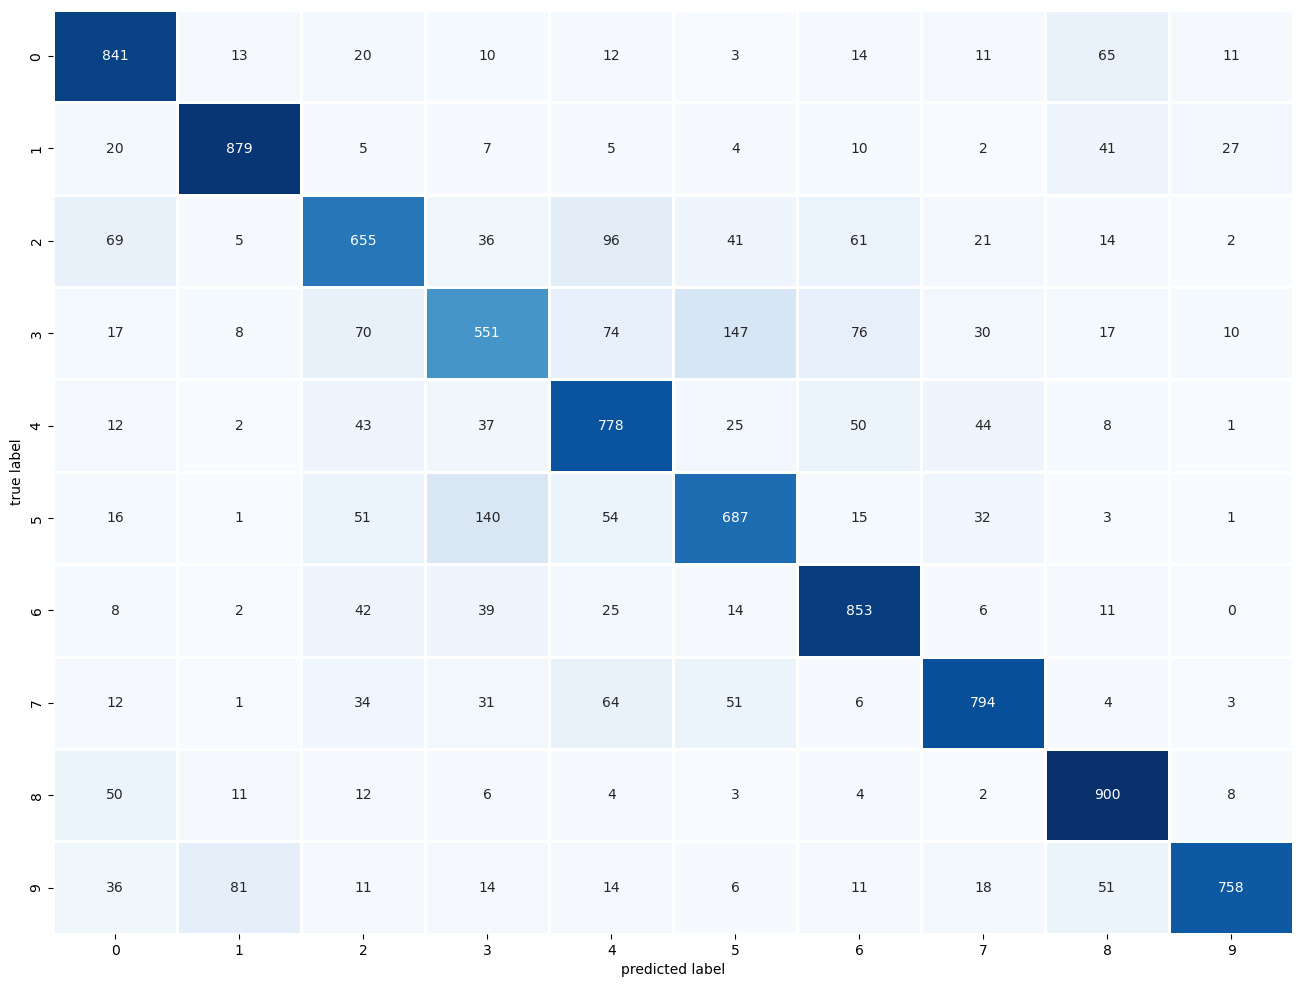

In [88]:
plot_confusion_matrix(y_test, pred_9)

# Experiment 10

In [100]:
# Add Layer                               # was getting error https://stackoverflow.com/questions/41651628/negative-dimension-size-caused-by-subtracting-3-from-1-for-conv2d
# https://stackoverflow.com/questions/56624408/typeerror-and-valueerror-while-training-model-with-keras

k.clear_session()
model_10 = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu,
           input_shape=x_train_norm.shape[1:]),
    MaxPool2D((2, 2),strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Flatten(),
    Dense(units=128,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(.0001)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(units=10, activation=tf.nn.softmax)       
])

model_10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 256)        0

In [101]:
history_10, model_10, results_10 = compile_train_model(model_10,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 146s 2s/step - loss: 1.8420 - accuracy: 0.3306 - val_loss: 2.2287 - val_accuracy: 0.2324
Epoch 2/200
88/88 [==============================] - 161s 2s/step - loss: 1.3987 - accuracy: 0.4996 - val_loss: 2.1504 - val_accuracy: 0.2356
Epoch 3/200
88/88 [==============================] - 160s 2s/step - loss: 1.1739 - accuracy: 0.5890 - val_loss: 2.0195 - val_accuracy: 0.3574
Epoch 4/200
88/88 [==============================] - 146s 2s/step - loss: 1.0281 - accuracy: 0.6464 - val_loss: 1.7518 - val_accuracy: 0.5450
Epoch 5/200
88/88 [==============================] - 165s 2s/step - loss: 0.9069 - accuracy: 0.6914 - val_loss: 1.5644 - val_accuracy: 0.5446
Epoch 6/200
88/88 [==============================] - 166s 2s/step - loss: 0.8236 - accuracy: 0.7237 - val_loss: 1.1549 - val_accuracy: 0.6842
Epoch 7/200
88/88 [==============================] - 171s 2s/step - loss: 0.7454 - accuracy: 0.7522 - val_loss: 0.9369 - val_accuracy: 0.6942
Epoch 

In [102]:
print(pd.DataFrame([results_10], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0       0.095    0.7946     0.8487     0.9864   0.8036    0.7894  3834


C:\Users\richd\AppData\Local\Temp\ipykernel_20228\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


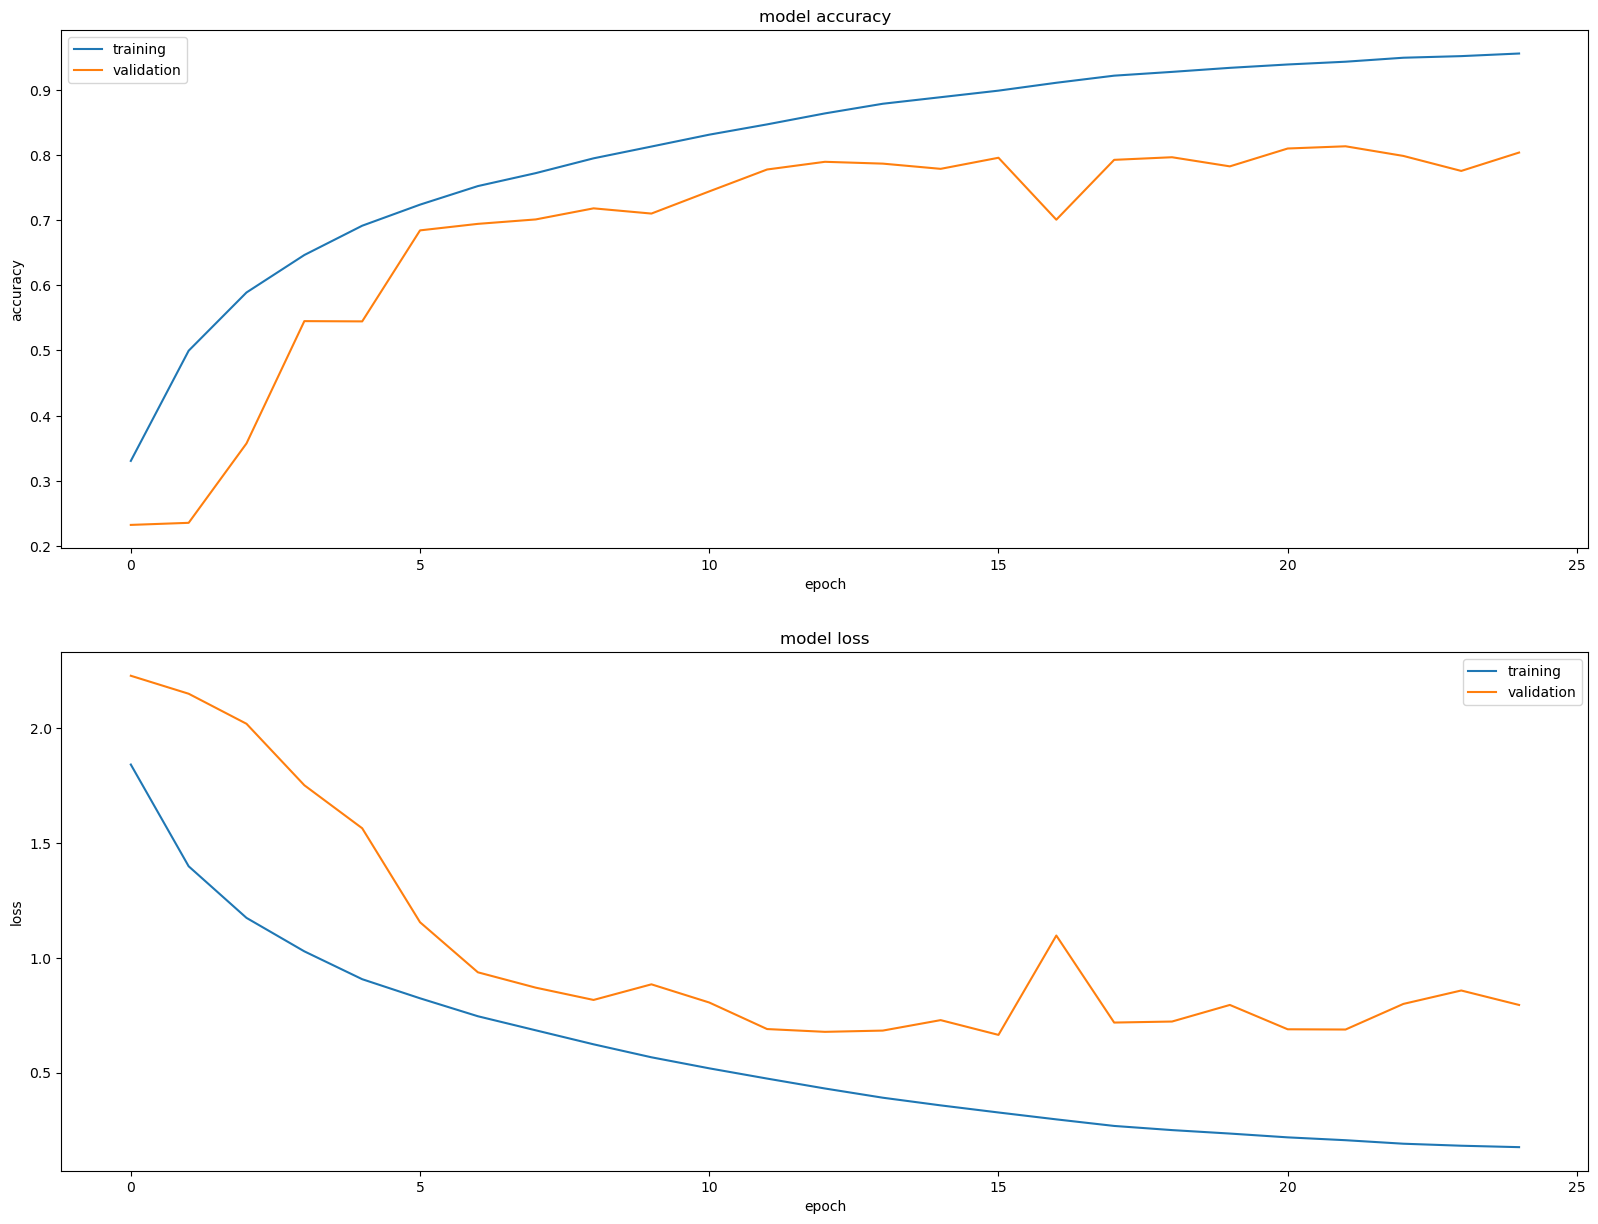

In [103]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_10.history['accuracy'], history_10.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_10.history['loss'], history_10.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 10)

In [104]:
pred_10 = model_10.predict(x_test_norm)
pred_10 = np.argmax(pred_10, axis=1)

In [105]:
print_validation_report(y_test, pred_10)

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1000
           1       0.90      0.90      0.90      1000
           2       0.85      0.58      0.69      1000
           3       0.59      0.68      0.63      1000
           4       0.81      0.72      0.76      1000
           5       0.64      0.77      0.69      1000
           6       0.74      0.92      0.82      1000
           7       0.90      0.77      0.83      1000
           8       0.88      0.89      0.89      1000
           9       0.87      0.85      0.86      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000

Accuracy Score: 0.7894
Root Mean Square Error: 1.8289614539404595


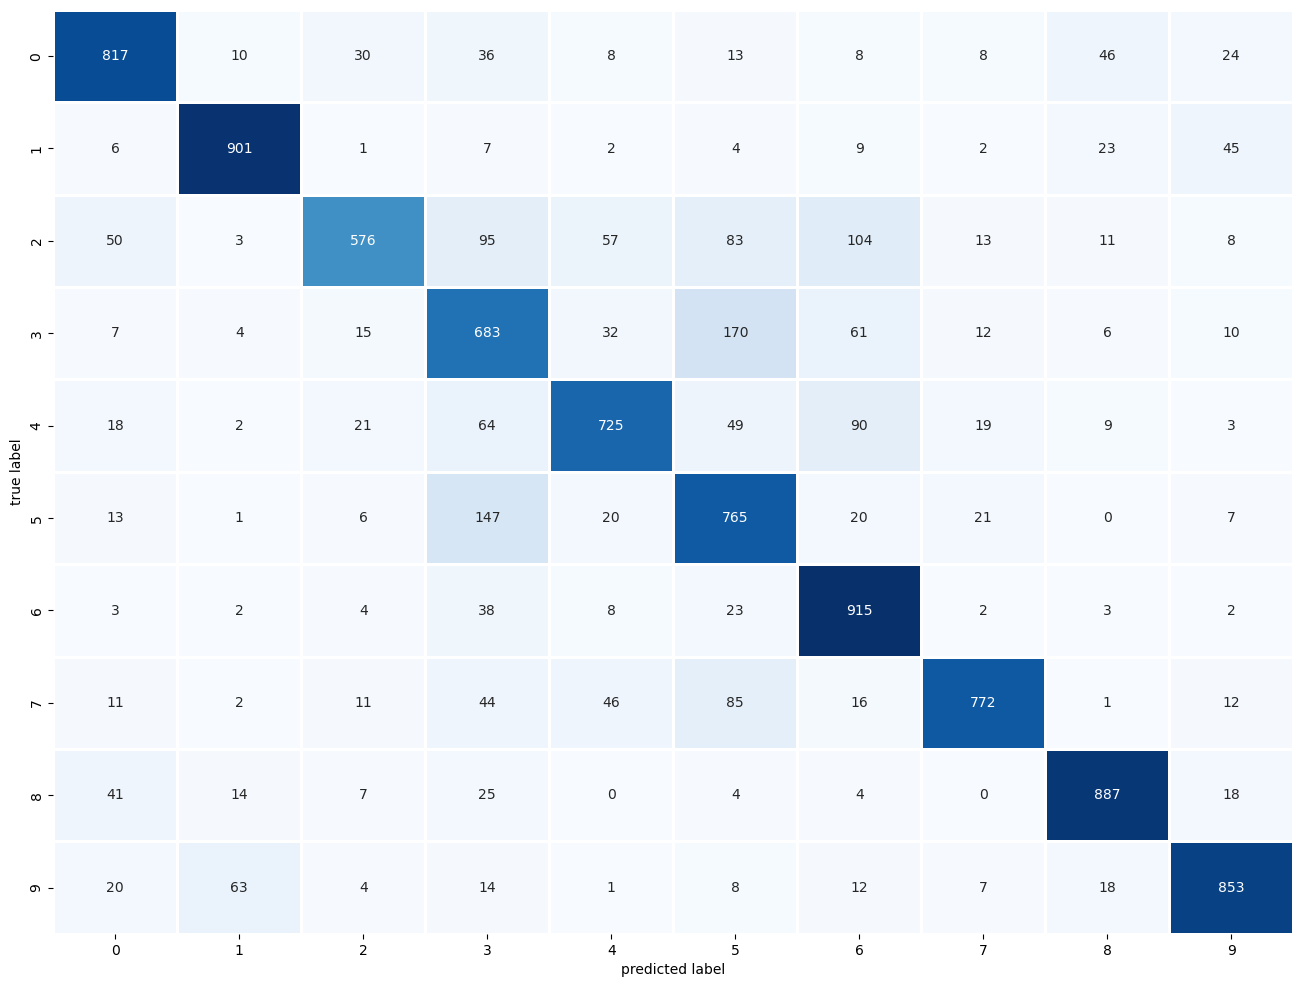

In [106]:
plot_confusion_matrix(y_test, pred_10)

In [107]:
# previous model with the same padding 
k.clear_session()
model_11 = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', 
           activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Flatten(),
    Dense(units=128,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(.00005)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(units=10, activation=tf.nn.softmax)            
])

model_11.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0

In [108]:
history_11, model_11, results_11 = compile_train_model(model_11,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 86s 962ms/step - loss: 1.8133 - accuracy: 0.3518 - val_loss: 2.2428 - val_accuracy: 0.2244
Epoch 2/200
88/88 [==============================] - 87s 990ms/step - loss: 1.4330 - accuracy: 0.4902 - val_loss: 2.1862 - val_accuracy: 0.2140
Epoch 3/200
88/88 [==============================] - 87s 989ms/step - loss: 1.2515 - accuracy: 0.5624 - val_loss: 2.0065 - val_accuracy: 0.3722
Epoch 4/200
88/88 [==============================] - 87s 995ms/step - loss: 1.1218 - accuracy: 0.6121 - val_loss: 1.7896 - val_accuracy: 0.5112
Epoch 5/200
88/88 [==============================] - 89s 1s/step - loss: 1.0290 - accuracy: 0.6483 - val_loss: 1.5028 - val_accuracy: 0.6098
Epoch 6/200
88/88 [==============================] - 88s 1s/step - loss: 0.9532 - accuracy: 0.6757 - val_loss: 1.1893 - val_accuracy: 0.6686
Epoch 7/200
88/88 [==============================] - 88s 1s/step - loss: 0.8900 - accuracy: 0.6997 - val_loss: 0.9494 - val_accuracy: 0.7018
E

In [109]:
print(pd.DataFrame([results_11], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      0.2962    0.7108      0.738     0.9262   0.7862    0.7794  1999


C:\Users\richd\AppData\Local\Temp\ipykernel_20228\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


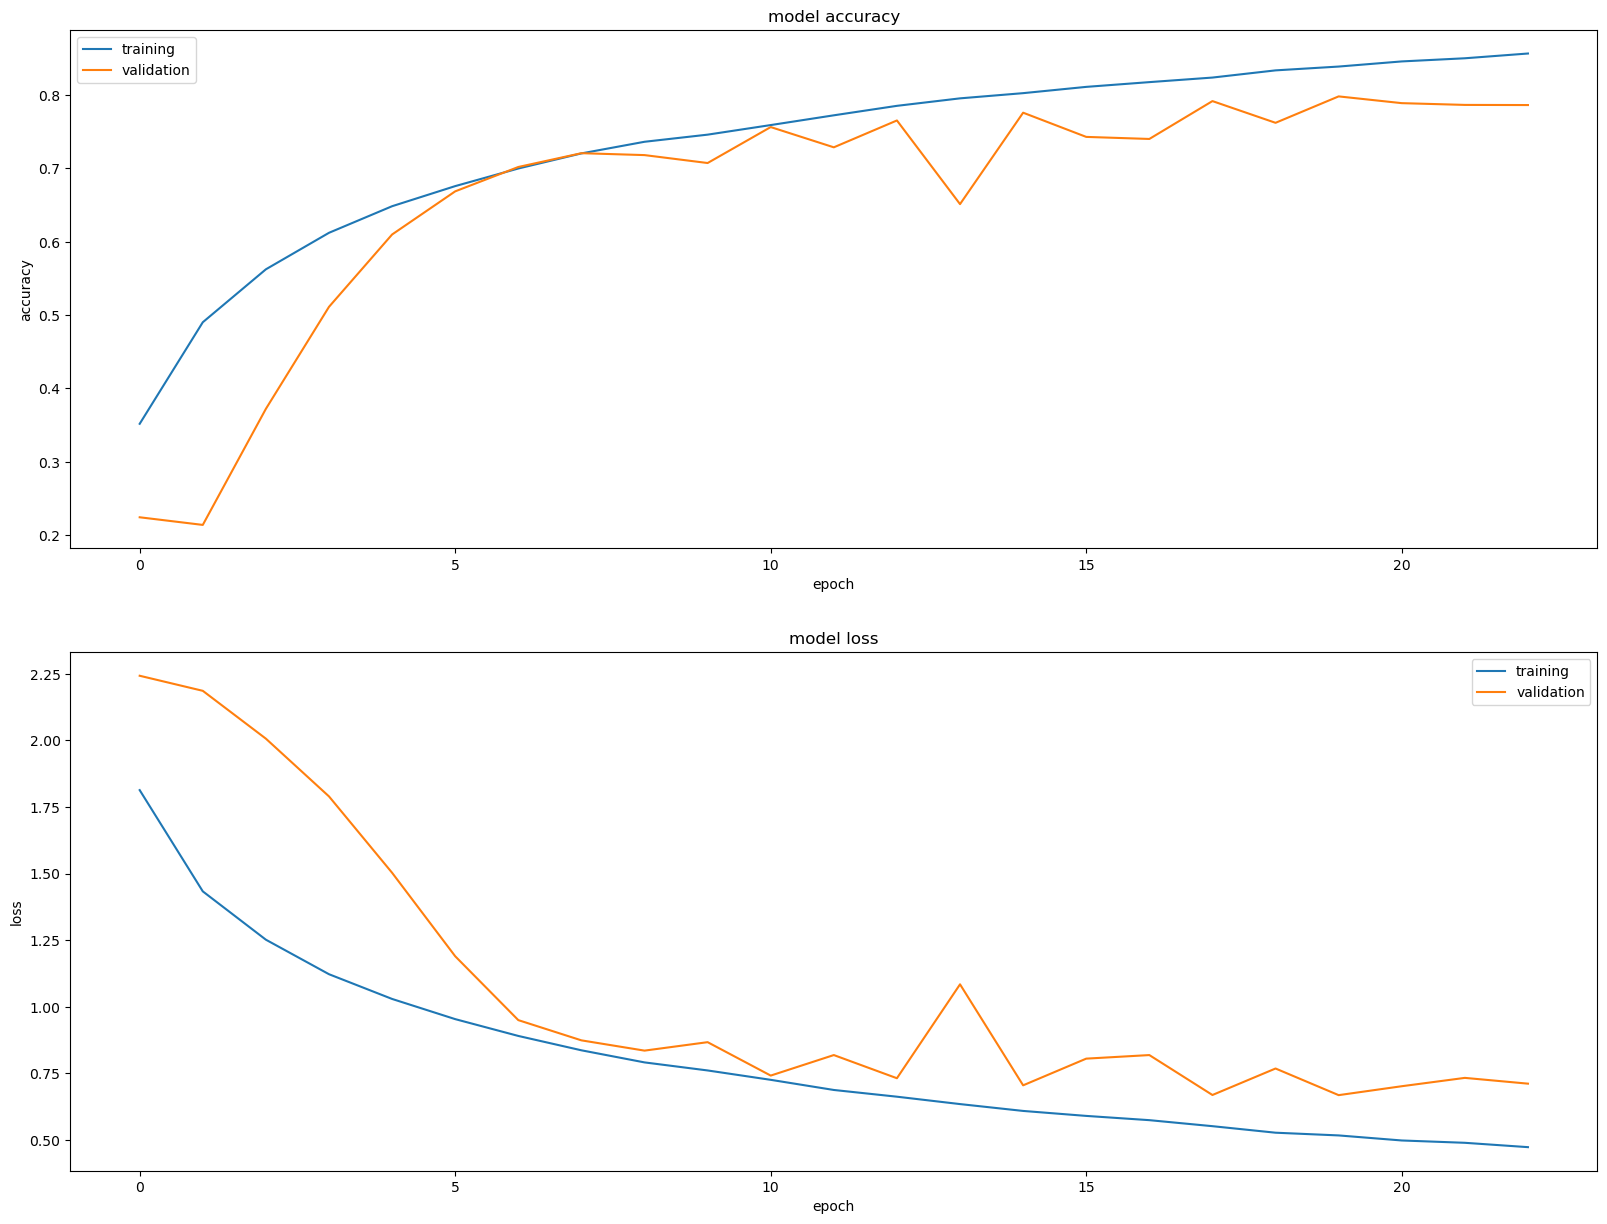

In [110]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_11.history['accuracy'], history_11.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_11.history['loss'], history_11.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 11)

In [111]:
pred_11 = model_11.predict(x_test_norm)
pred_11 = np.argmax(pred_11, axis=1)

In [112]:
print_validation_report(y_test, pred_11)

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1000
           1       0.87      0.91      0.88      1000
           2       0.78      0.65      0.71      1000
           3       0.52      0.69      0.59      1000
           4       0.75      0.78      0.76      1000
           5       0.62      0.72      0.67      1000
           6       0.92      0.74      0.82      1000
           7       0.88      0.80      0.84      1000
           8       0.91      0.86      0.88      1000
           9       0.89      0.82      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000

Accuracy Score: 0.7794
Root Mean Square Error: 1.8517559234413157


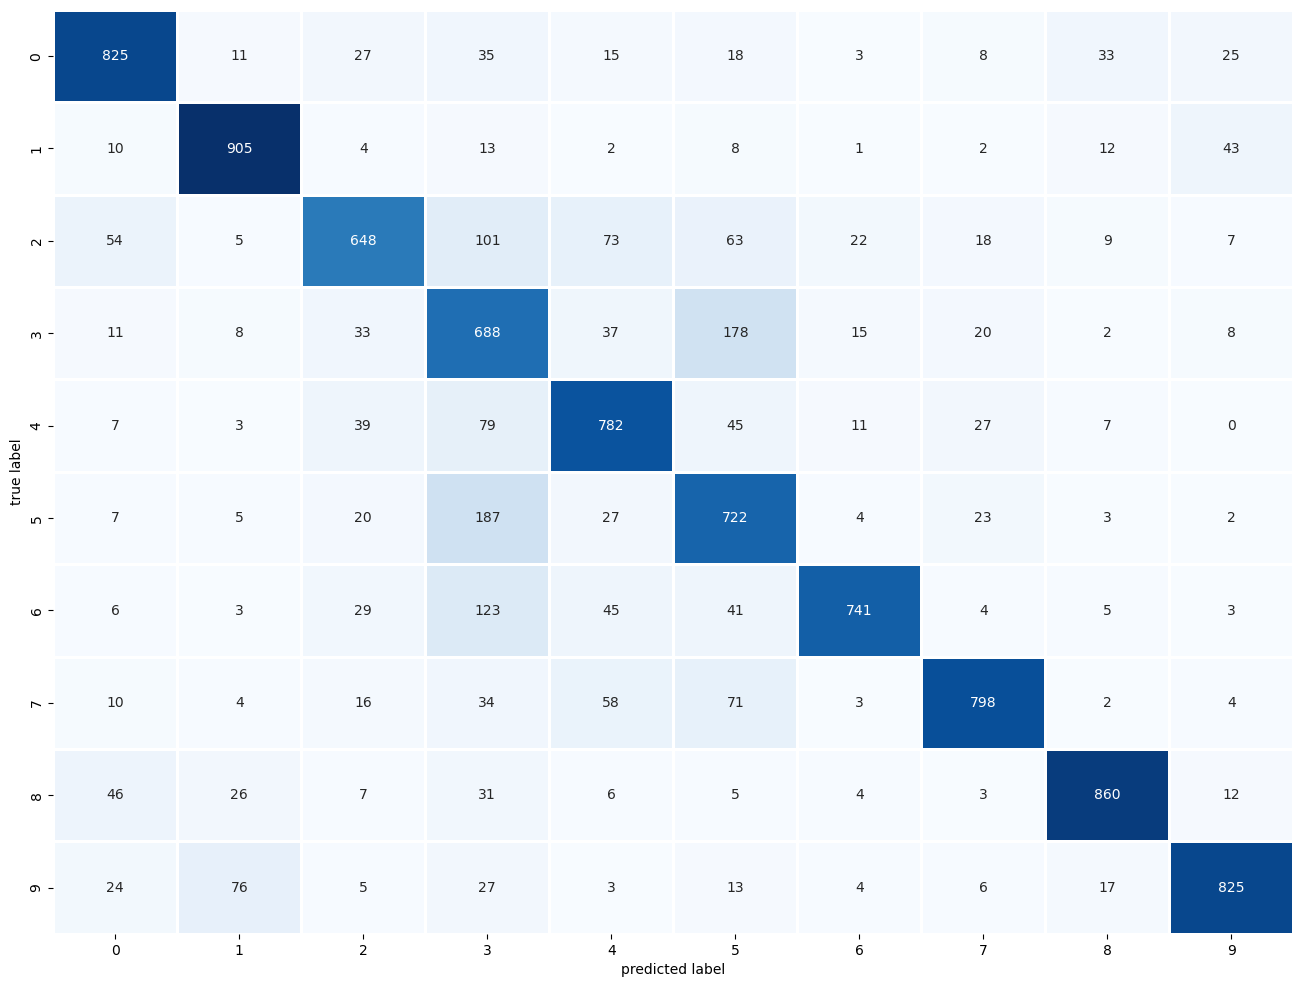

In [113]:
plot_confusion_matrix(y_test, pred_11)

# Experiment 12

In [114]:
# add additional layer
k.clear_session()
model_12 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu,
           input_shape=x_train_norm.shape[1:]),
    MaxPool2D((2, 2),strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Flatten(),
    Dense(units=512,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(.0001)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(units=10, activation=tf.nn.softmax)       
])

model_12.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [115]:
history_12, model_12, results_12 = compile_train_model(model_12,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 113s 1s/step - loss: 2.0295 - accuracy: 0.2456 - val_loss: 2.2642 - val_accuracy: 0.1574
Epoch 2/200
88/88 [==============================] - 99s 1s/step - loss: 1.6186 - accuracy: 0.4070 - val_loss: 2.1885 - val_accuracy: 0.1562
Epoch 3/200
88/88 [==============================] - 86s 981ms/step - loss: 1.4160 - accuracy: 0.4839 - val_loss: 2.0649 - val_accuracy: 0.3230
Epoch 4/200
88/88 [==============================] - 97s 1s/step - loss: 1.2792 - accuracy: 0.5407 - val_loss: 1.8648 - val_accuracy: 0.4548
Epoch 5/200
88/88 [==============================] - 94s 1s/step - loss: 1.1706 - accuracy: 0.5856 - val_loss: 1.7169 - val_accuracy: 0.4992
Epoch 6/200
88/88 [==============================] - 91s 1s/step - loss: 1.0683 - accuracy: 0.6203 - val_loss: 1.4495 - val_accuracy: 0.5610
Epoch 7/200
88/88 [==============================] - 84s 960ms/step - loss: 0.9947 - accuracy: 0.6488 - val_loss: 1.1450 - val_accuracy: 0.6190
Epoch 

In [116]:
print(pd.DataFrame([results_12], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      0.4506    0.7661     0.7895     0.8472   0.7478    0.7444  1577


C:\Users\richd\AppData\Local\Temp\ipykernel_20228\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


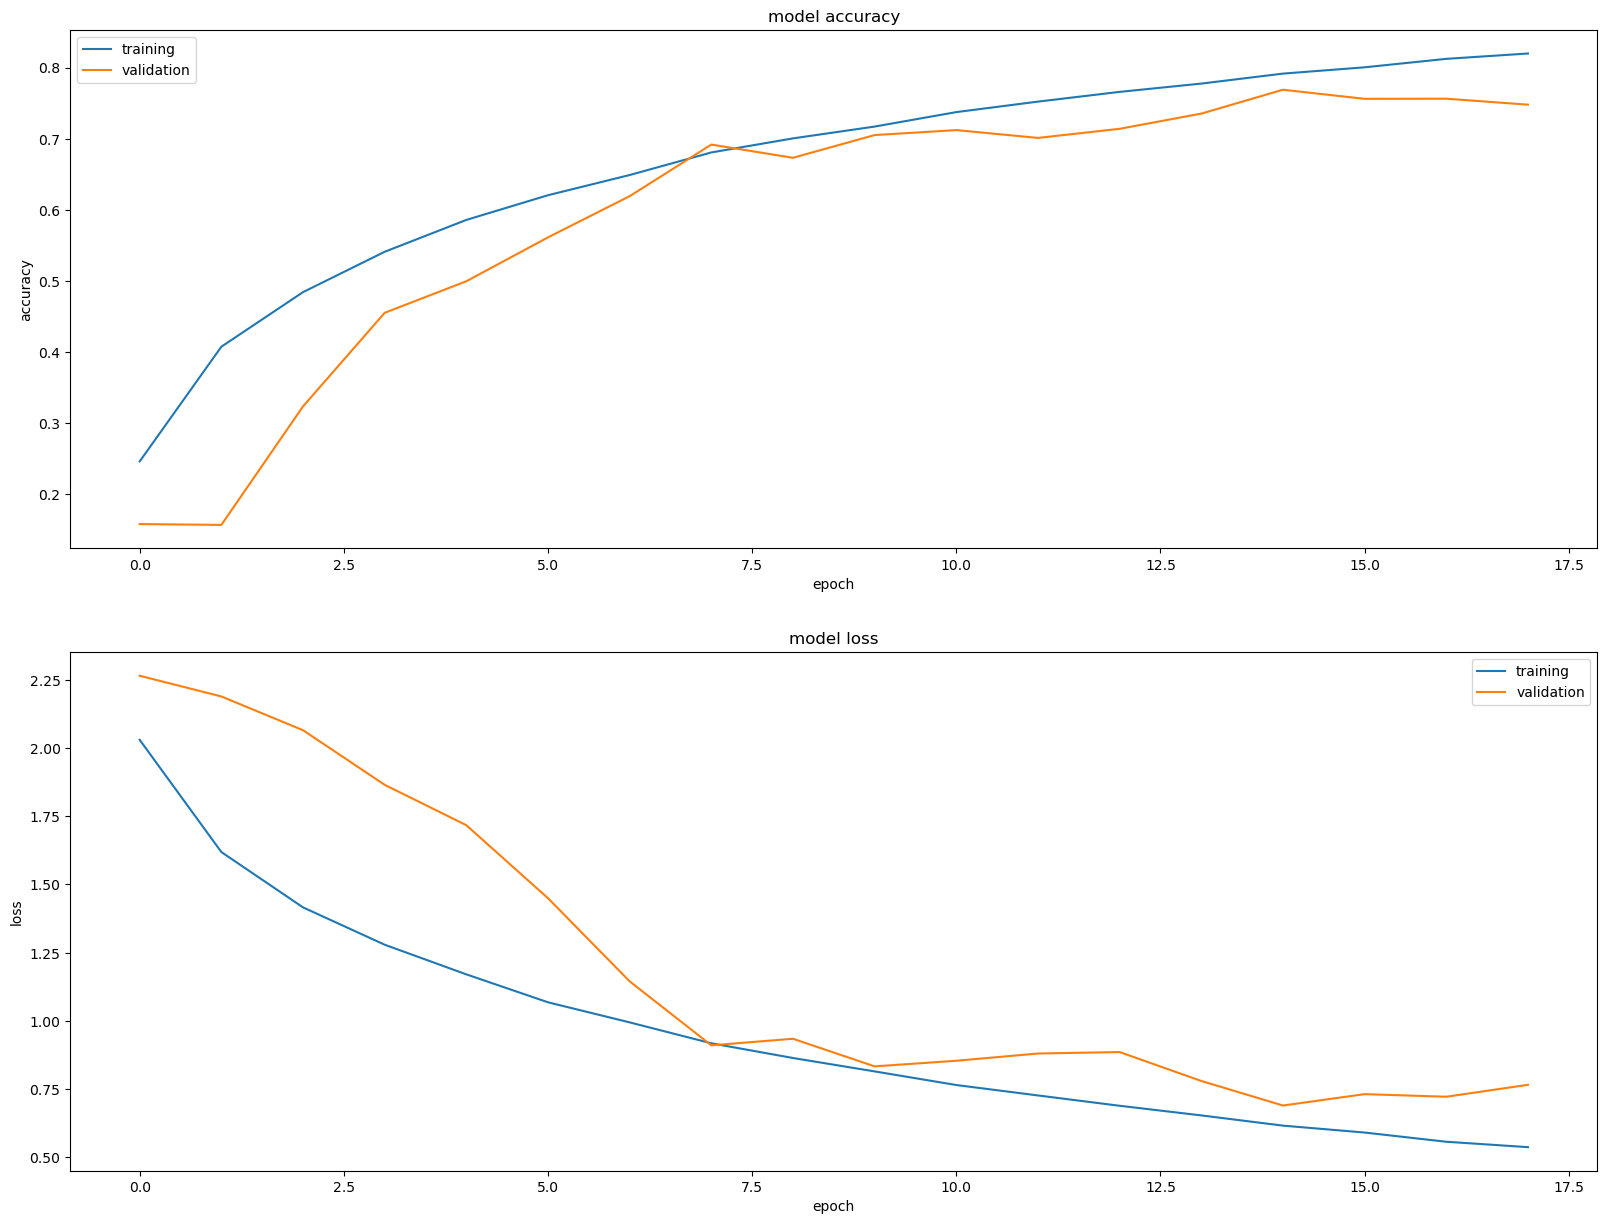

In [117]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_12.history['accuracy'], history_12.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_12.history['loss'], history_12.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 12)

In [118]:
pred_12 = model_12.predict(x_test_norm)
pred_12 = np.argmax(pred_12, axis=1)

In [248]:
print_validation_report(y_test, pred_12)

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.68      0.77      1000
           1       0.97      0.65      0.77      1000
           2       0.75      0.58      0.65      1000
           3       0.62      0.44      0.51      1000
           4       0.54      0.87      0.66      1000
           5       0.59      0.73      0.65      1000
           6       0.78      0.84      0.81      1000
           7       0.78      0.81      0.80      1000
           8       0.89      0.83      0.86      1000
           9       0.74      0.87      0.80      1000

    accuracy                           0.73     10000
   macro avg       0.75      0.73      0.73     10000
weighted avg       0.75      0.73      0.73     10000

Accuracy Score: 0.7292
Root Mean Square Error: 2.137849386650051


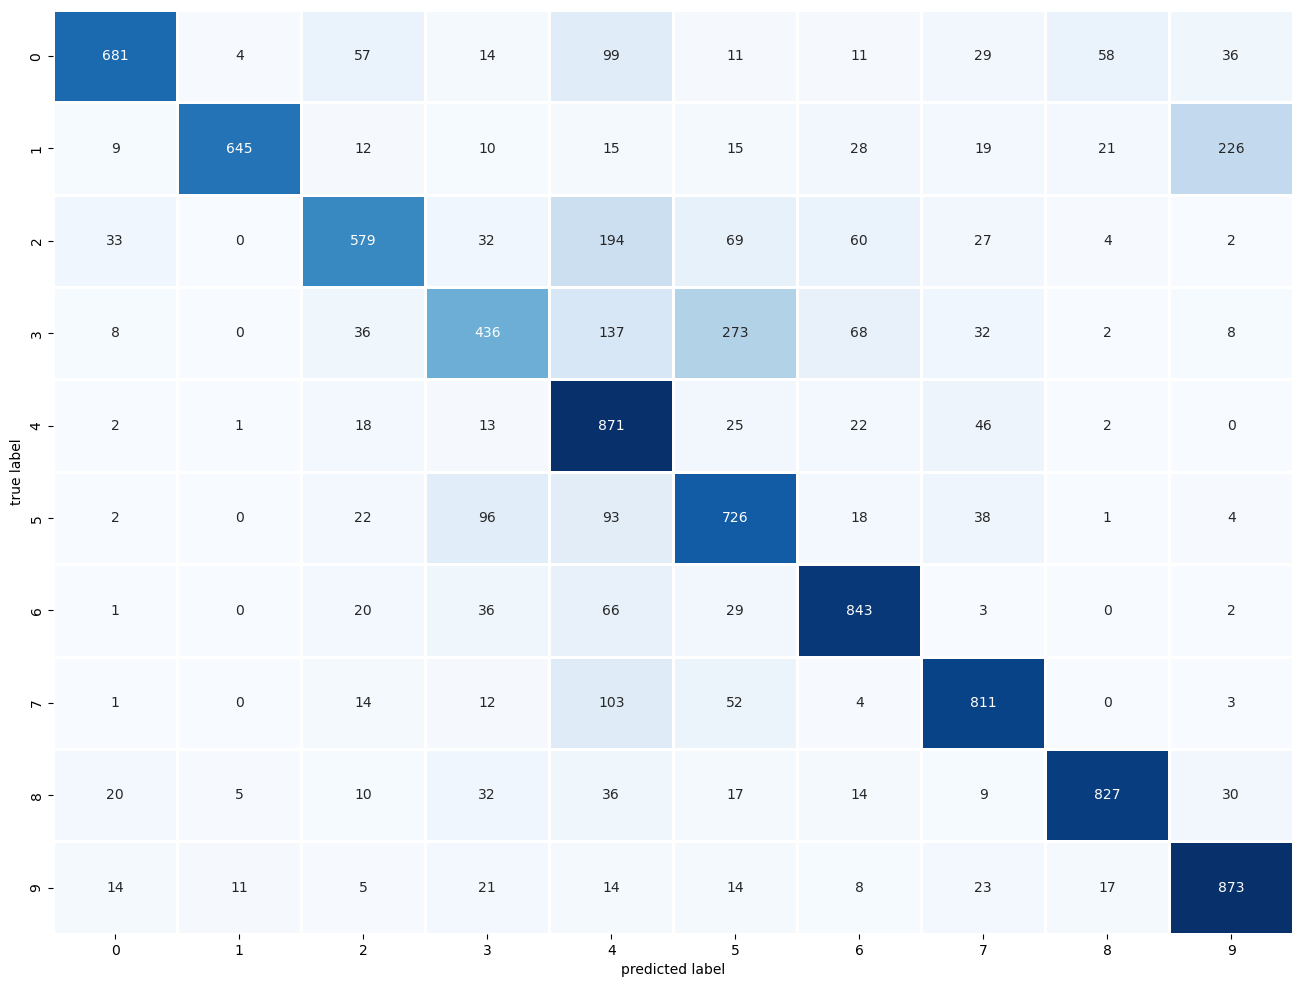

In [249]:
plot_confusion_matrix(y_test, pred_12)

# Experiment 13

In [54]:
# use more filters, similar to model 9
k.clear_session()
model_13 = Sequential([
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,
           input_shape=x_train_norm.shape[1:]),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.25),
    Flatten(),
    Dense(units=512,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(.00005)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(units=10, activation=tf.nn.softmax)       
])

model_13.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

In [55]:
history_13, model_13, results_13 = compile_train_model(model_13,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 152s 2s/step - loss: 2.3134 - accuracy: 0.0981 - val_loss: 2.3038 - val_accuracy: 0.1008
Epoch 2/200
88/88 [==============================] - 155s 2s/step - loss: 2.0995 - accuracy: 0.2224 - val_loss: 2.2362 - val_accuracy: 0.1186
Epoch 3/200
88/88 [==============================] - 156s 2s/step - loss: 1.6207 - accuracy: 0.4170 - val_loss: 2.1042 - val_accuracy: 0.2728
Epoch 4/200
88/88 [==============================] - 169s 2s/step - loss: 1.4051 - accuracy: 0.4982 - val_loss: 1.9332 - val_accuracy: 0.4096
Epoch 5/200
88/88 [==============================] - 158s 2s/step - loss: 1.2563 - accuracy: 0.5576 - val_loss: 1.6940 - val_accuracy: 0.5050
Epoch 6/200
88/88 [==============================] - 147s 2s/step - loss: 1.1460 - accuracy: 0.6001 - val_loss: 1.3703 - val_accuracy: 0.6224
Epoch 7/200
88/88 [==============================] - 143s 2s/step - loss: 1.0494 - accuracy: 0.6363 - val_loss: 1.1280 - val_accuracy: 0.6488
Epoch 

In [56]:
print(pd.DataFrame([results_13], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      0.4696    0.8402       0.87     0.8482   0.7354    0.7341  2727


C:\Users\richd\AppData\Local\Temp\ipykernel_39884\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


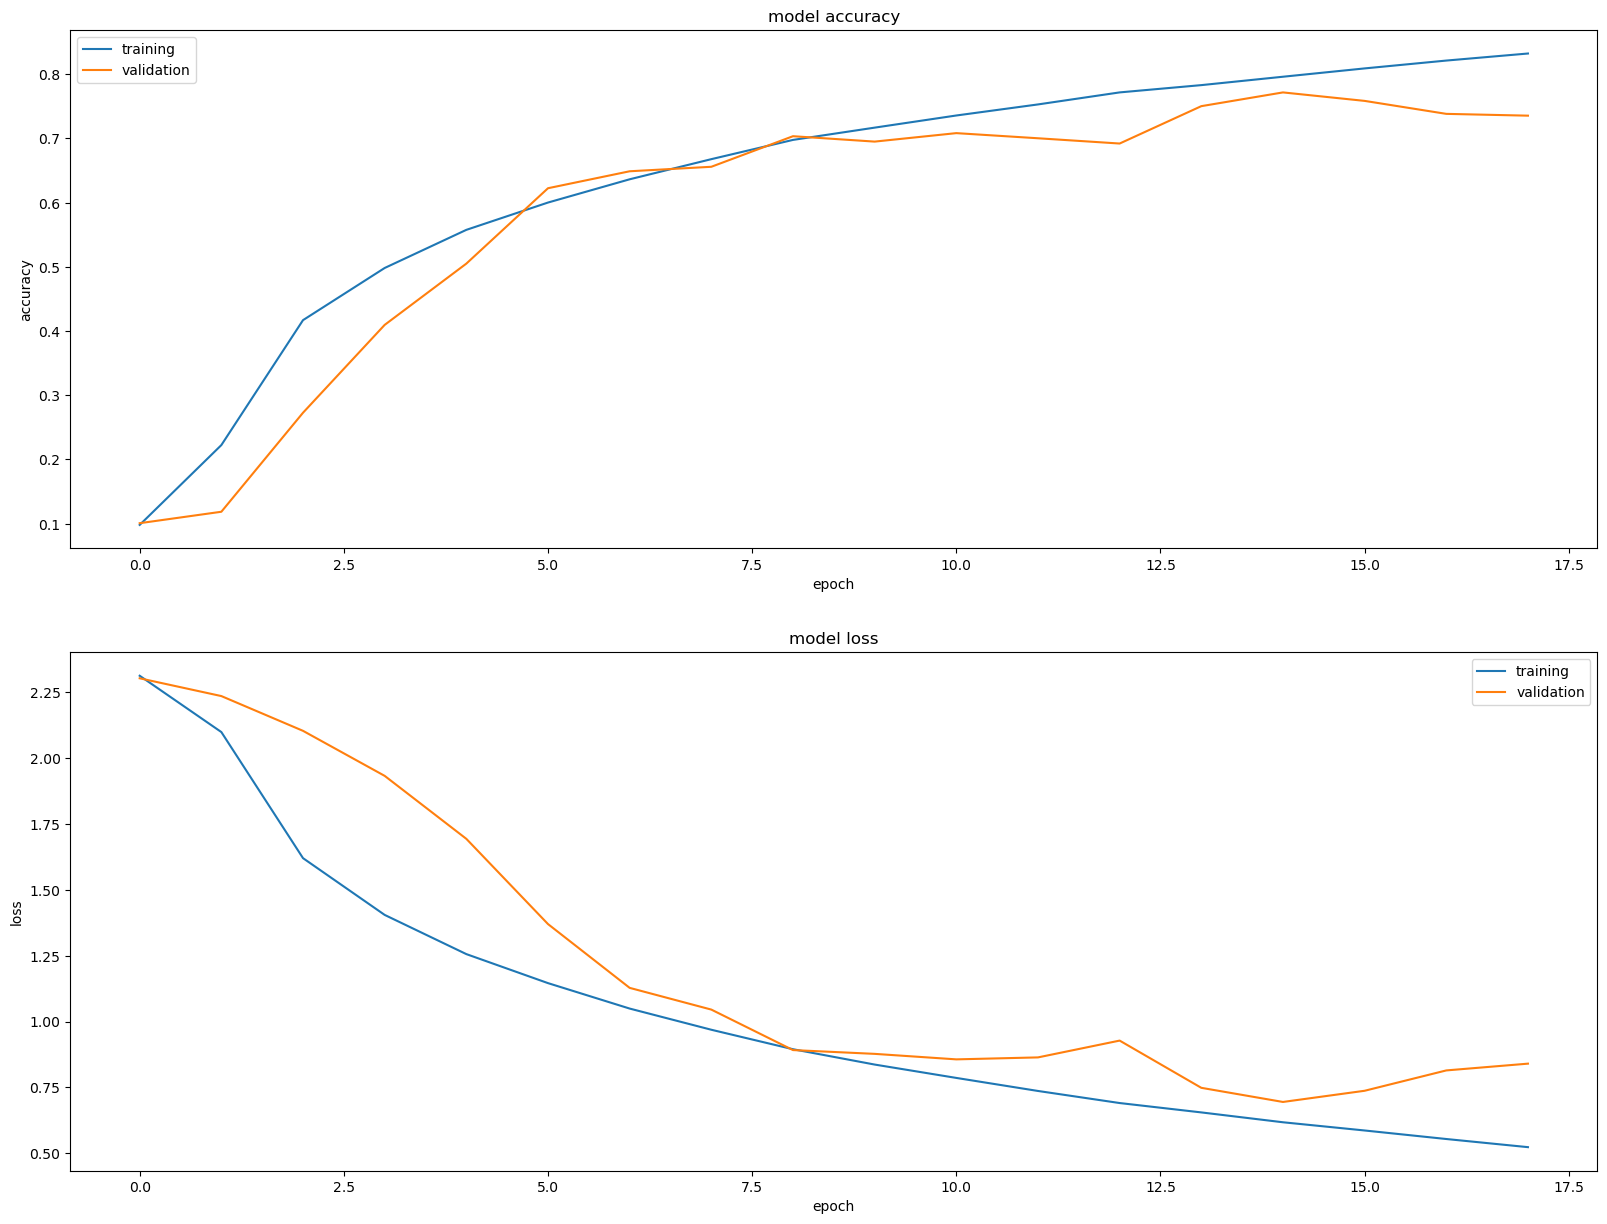

In [57]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_13.history['accuracy'], history_13.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_13.history['loss'], history_13.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 13)

In [58]:
pred_13 = model_13.predict(x_test_norm)
pred_13 = np.argmax(pred_13, axis=1)

In [59]:
print_validation_report(y_test, pred_13)

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1000
           1       0.89      0.88      0.89      1000
           2       0.67      0.65      0.66      1000
           3       0.63      0.52      0.57      1000
           4       0.67      0.76      0.71      1000
           5       0.87      0.38      0.53      1000
           6       0.55      0.94      0.69      1000
           7       0.86      0.72      0.78      1000
           8       0.75      0.92      0.82      1000
           9       0.84      0.85      0.84      1000

    accuracy                           0.73     10000
   macro avg       0.76      0.73      0.73     10000
weighted avg       0.76      0.73      0.73     10000

Accuracy Score: 0.7341
Root Mean Square Error: 2.042425029223839


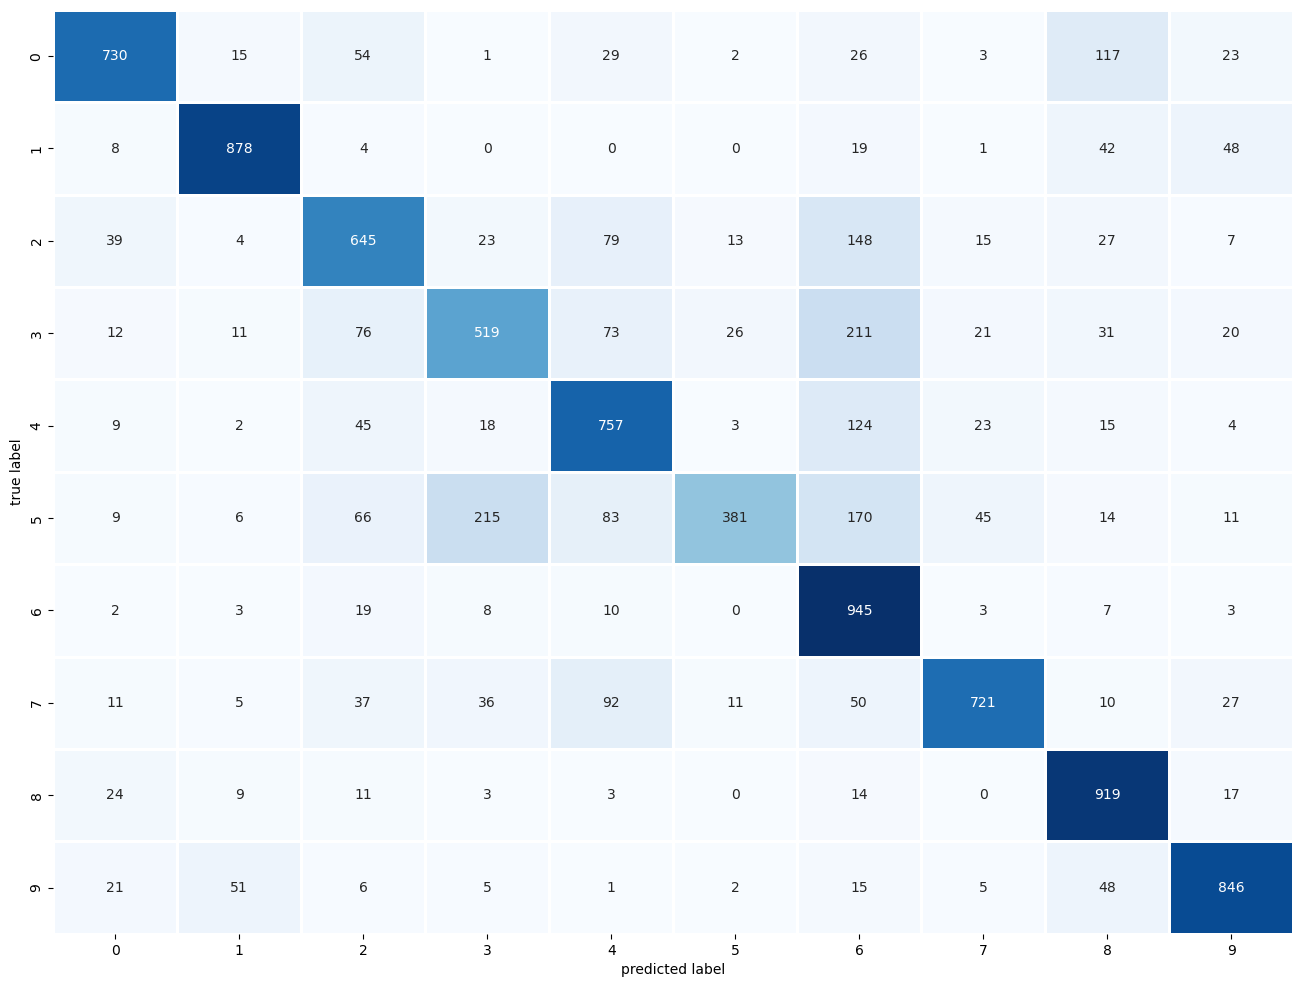

In [60]:
plot_confusion_matrix(y_test, pred_13)

# Experiment 14

In [119]:
# improve of model 10 by increasing filters starting at 128 instead of 64 and final output 512
k.clear_session()
model_14 = Sequential([
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu,
           input_shape=x_train_norm.shape[1:]),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.1),
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.1),
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.5),
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    MaxPool2D((2, 2),strides=2),
    Dropout(0.5),
    Flatten(),
    Dense(units=512,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(.00001)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(units=10, activation=tf.nn.softmax)       
])

model_14.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 256)         0

In [120]:
# Setting up a data augmentation configuration via ImageDataGenerator
history_14, model_14, results_14 = compile_train_model(model_14,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 343s 4s/step - loss: 2.0224 - accuracy: 0.2518 - val_loss: 2.2696 - val_accuracy: 0.1606
Epoch 2/200
88/88 [==============================] - 373s 4s/step - loss: 1.5801 - accuracy: 0.4242 - val_loss: 2.1733 - val_accuracy: 0.1266
Epoch 3/200
88/88 [==============================] - 395s 4s/step - loss: 1.3558 - accuracy: 0.5122 - val_loss: 2.0597 - val_accuracy: 0.3166
Epoch 4/200
88/88 [==============================] - 334s 4s/step - loss: 1.1933 - accuracy: 0.5748 - val_loss: 1.8417 - val_accuracy: 0.5112
Epoch 5/200
88/88 [==============================] - 313s 4s/step - loss: 1.0503 - accuracy: 0.6301 - val_loss: 1.7268 - val_accuracy: 0.4846
Epoch 6/200
88/88 [==============================] - 313s 4s/step - loss: 0.9449 - accuracy: 0.6692 - val_loss: 1.2930 - val_accuracy: 0.6024
Epoch 7/200
88/88 [==============================] - 463s 5s/step - loss: 0.8556 - accuracy: 0.7042 - val_loss: 1.0375 - val_accuracy: 0.6632
Epoch 

In [121]:
print(pd.DataFrame([results_14], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      0.6264    0.8385     0.8768     0.7769   0.7182    0.7133  4081


In [27]:
print(pd.DataFrame([results_14], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      0.2396    0.9636     0.9838     0.9306   0.7622    0.7565  6470


C:\Users\richd\AppData\Local\Temp\ipykernel_20228\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


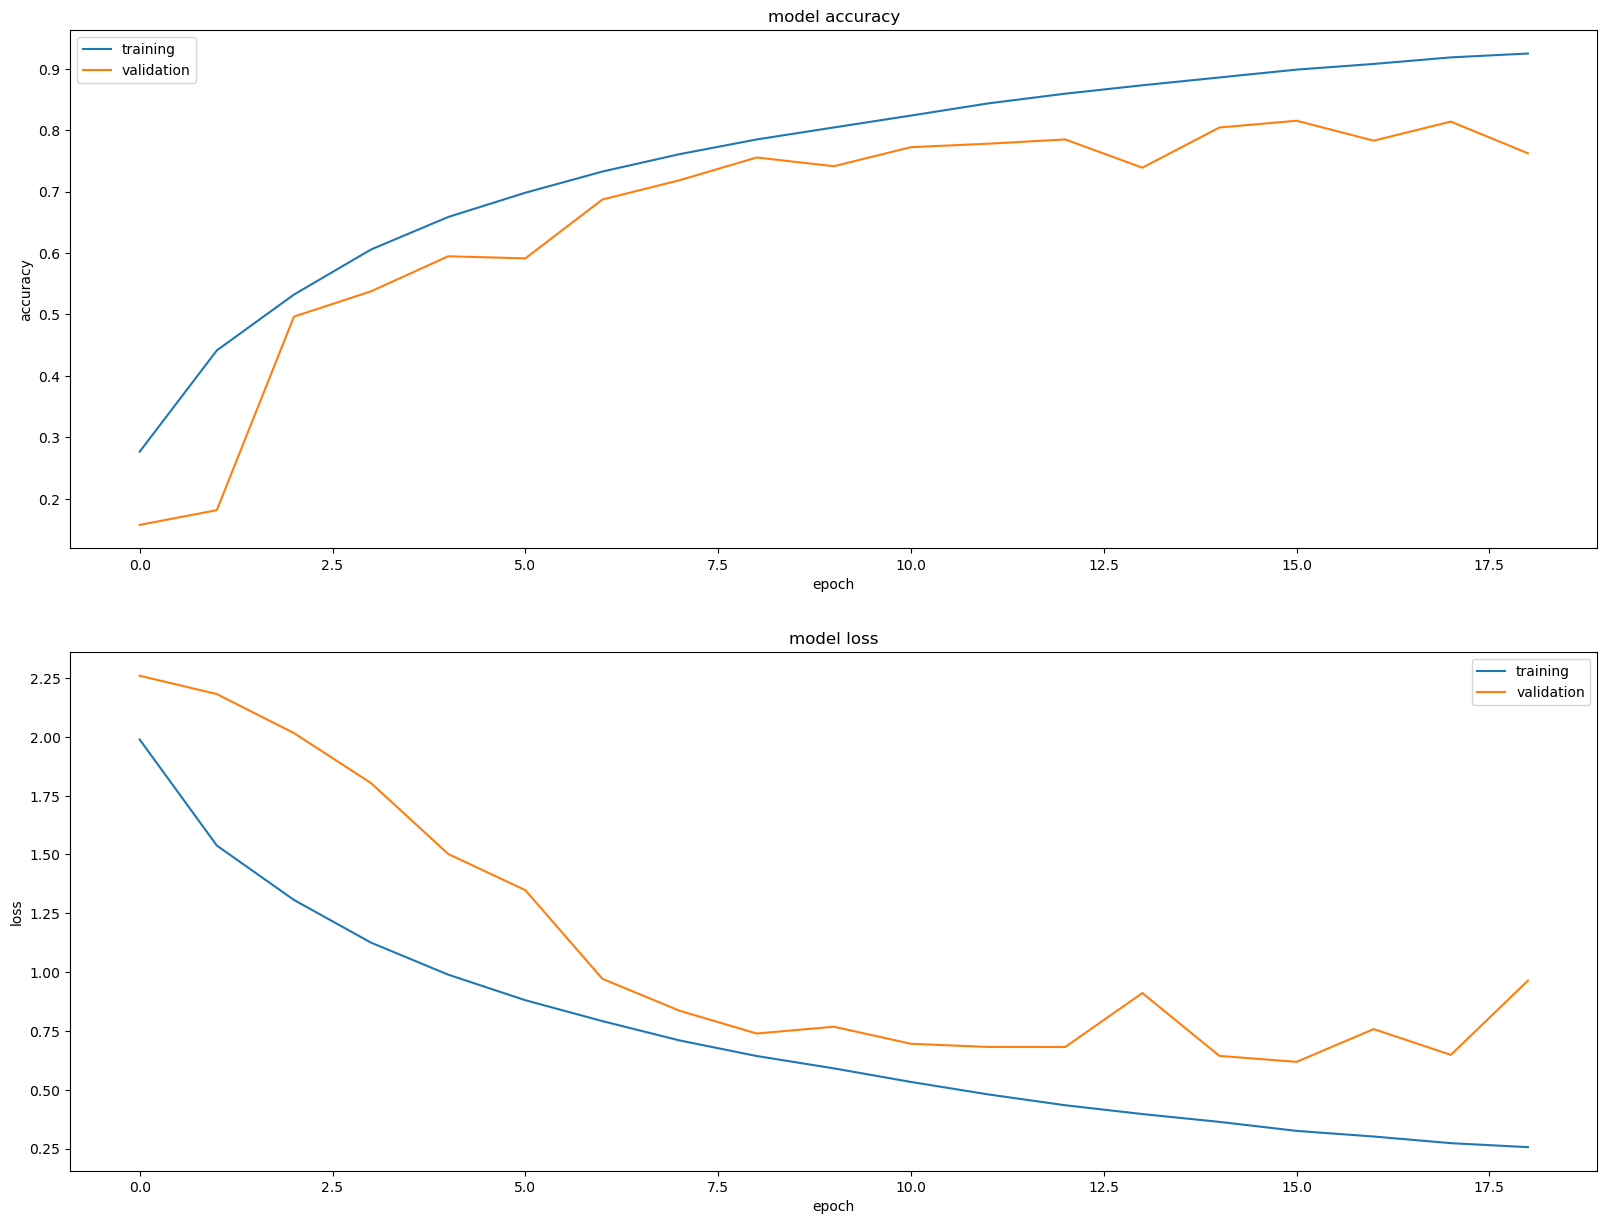

In [28]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_14.history['accuracy'], history_14.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_14.history['loss'], history_14.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 14)

In [29]:
pred_14 = model_14.predict(x_test_norm)
pred_14 = np.argmax(pred_14, axis=1)

In [30]:
print_validation_report(y_test, pred_14)

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1000
           1       0.86      0.94      0.90      1000
           2       0.55      0.79      0.64      1000
           3       0.67      0.51      0.57      1000
           4       0.77      0.69      0.73      1000
           5       0.79      0.53      0.64      1000
           6       0.58      0.95      0.72      1000
           7       0.97      0.65      0.77      1000
           8       0.88      0.90      0.89      1000
           9       0.93      0.79      0.86      1000

    accuracy                           0.76     10000
   macro avg       0.78      0.76      0.76     10000
weighted avg       0.78      0.76      0.76     10000

Accuracy Score: 0.7565
Root Mean Square Error: 1.922966458365824


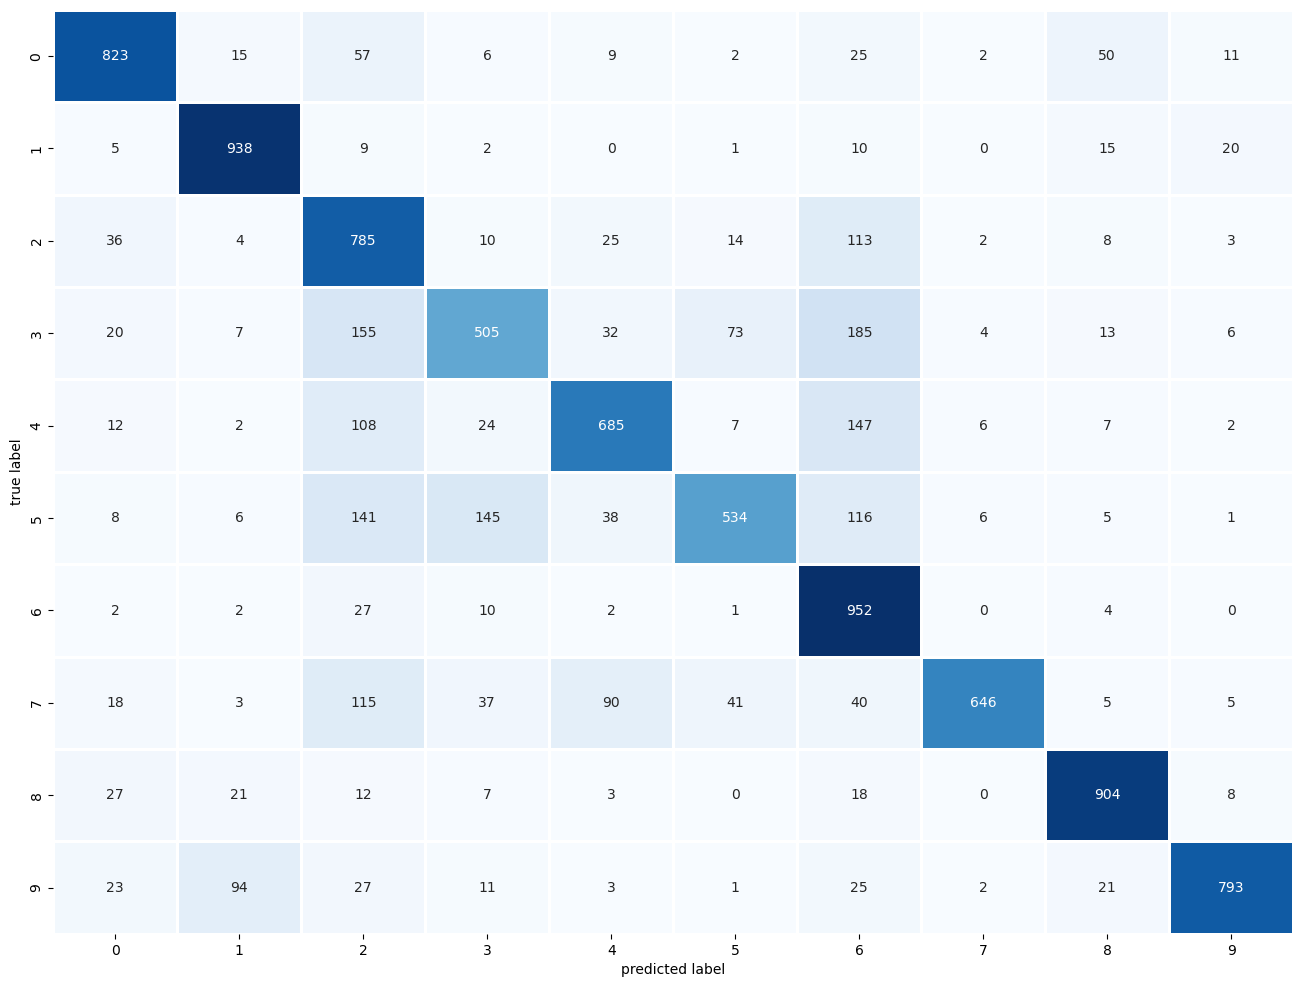

In [31]:
plot_confusion_matrix(y_test, pred_14)

# Experiment 15
- Incorporate Data Augmentation

In [ ]:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

# create data generator 
datagen = ImageDataGenerator(
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True,
                shear_range=0.2,
                zoom_range=0.2
)

In [137]:
# convert labels to categorical
num_classes = 10
y_train_lab = to_categorical(y_train, num_classes)
y_test_lab = to_categorical(y_test, num_classes)
y_train_split, y_valid_split

In [135]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)




# data augmentation
datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

In [22]:
# convert labels to categorical

num_classes = 10
y_train_lab = to_categorical(y_train_split, num_classes)
y_valid_lab = to_categorical(y_valid_split, num_classes)
y_test_lab = to_categorical(y_test, num_classes)

In [23]:
# fit the generator on the training data
datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

datagen.fit(x_train_norm)

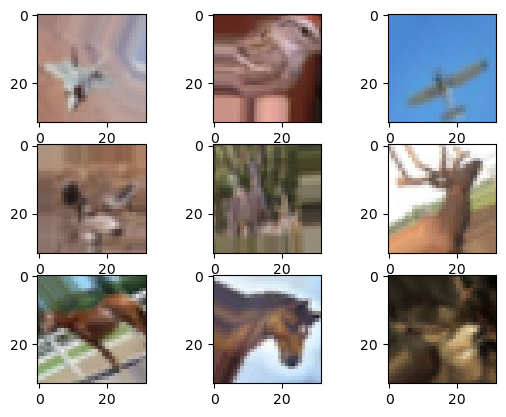

In [24]:
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [39]:
# similar to model 10  and https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb
model_15 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu,
           input_shape=x_train_norm.shape[1:]),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    MaxPool2D((2, 2),strides=2),
    
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    MaxPool2D((2, 2),strides=2),
    
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    MaxPool2D((2, 2),strides=2),

    Flatten(),
    Dense(units=128,activation=tf.nn.relu),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=10, activation=tf.nn.softmax)       
])

model_15.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [40]:
x_train.shape

(50000, 32, 32, 3)

In [41]:
model_15.compile(optimizer='Adam',
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

In [42]:
starting_time = time.time()
history_15 = model_15.fit_generator(datagen.flow(x_train_norm, y_train_lab, batch_size=128),
                                    epochs = 100,
                                    steps_per_epoch = len(x_train_norm) / 128,
                                    validation_data=(x_valid_norm, y_valid_lab),
                                    callbacks=[    
                                    tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,
                                                                       save_weights_only=False),
                                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)
                                                ]
                                   )
ending_time = time.time()
seconds = round(ending_time - starting_time)

Epoch 1/100


C:\Users\richd\AppData\Local\Temp\ipykernel_39884\239769330.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_15 = model_15.fit_generator(datagen.flow(x_train_norm, y_train_lab, batch_size=128),


351/351 [==============================] - 102s 287ms/step - loss: 1.9427 - accuracy: 0.3426 - val_loss: 2.4882 - val_accuracy: 0.2156
Epoch 2/100
351/351 [==============================] - 102s 291ms/step - loss: 1.4771 - accuracy: 0.4712 - val_loss: 1.3072 - val_accuracy: 0.5190
Epoch 3/100
351/351 [==============================] - 104s 295ms/step - loss: 1.2976 - accuracy: 0.5350 - val_loss: 1.4662 - val_accuracy: 0.5256
Epoch 4/100
351/351 [==============================] - 105s 299ms/step - loss: 1.1780 - accuracy: 0.5830 - val_loss: 1.5458 - val_accuracy: 0.5224
Epoch 5/100
351/351 [==============================] - 107s 304ms/step - loss: 1.1078 - accuracy: 0.6093 - val_loss: 1.1965 - val_accuracy: 0.6018
Epoch 6/100
351/351 [==============================] - 109s 309ms/step - loss: 1.0413 - accuracy: 0.6363 - val_loss: 0.9267 - val_accuracy: 0.6760
Epoch 7/100
351/351 [==============================] - 106s 301ms/step - loss: 0.9749 - accuracy: 0.6606 - val_loss: 1.0150 - val_

In [63]:
train_loss_15, train_acc_15 = model_15.evaluate(x_train_norm, y_train_lab)
val_loss_15, val_acc_15 = model_15.evaluate(x_valid_norm, y_valid_lab)
test_loss_15, test_acc_15 = model_15.evaluate(x_test_norm, y_test_lab)

results_15 = [round(train_loss_15, 4), round(val_loss_15, 4), round(test_loss_15, 4), round(train_acc_15, 4), 
               round(val_acc_15, 4), round(test_acc_15, 4), seconds]

print(pd.DataFrame([results_15], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

313/313 [==============================] - 6s 20ms/step - loss: 0.6090 - accuracy: 0.7989
   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      0.5067    0.5809      0.609      0.827   0.8056    0.7989  2947


C:\Users\richd\AppData\Local\Temp\ipykernel_39884\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


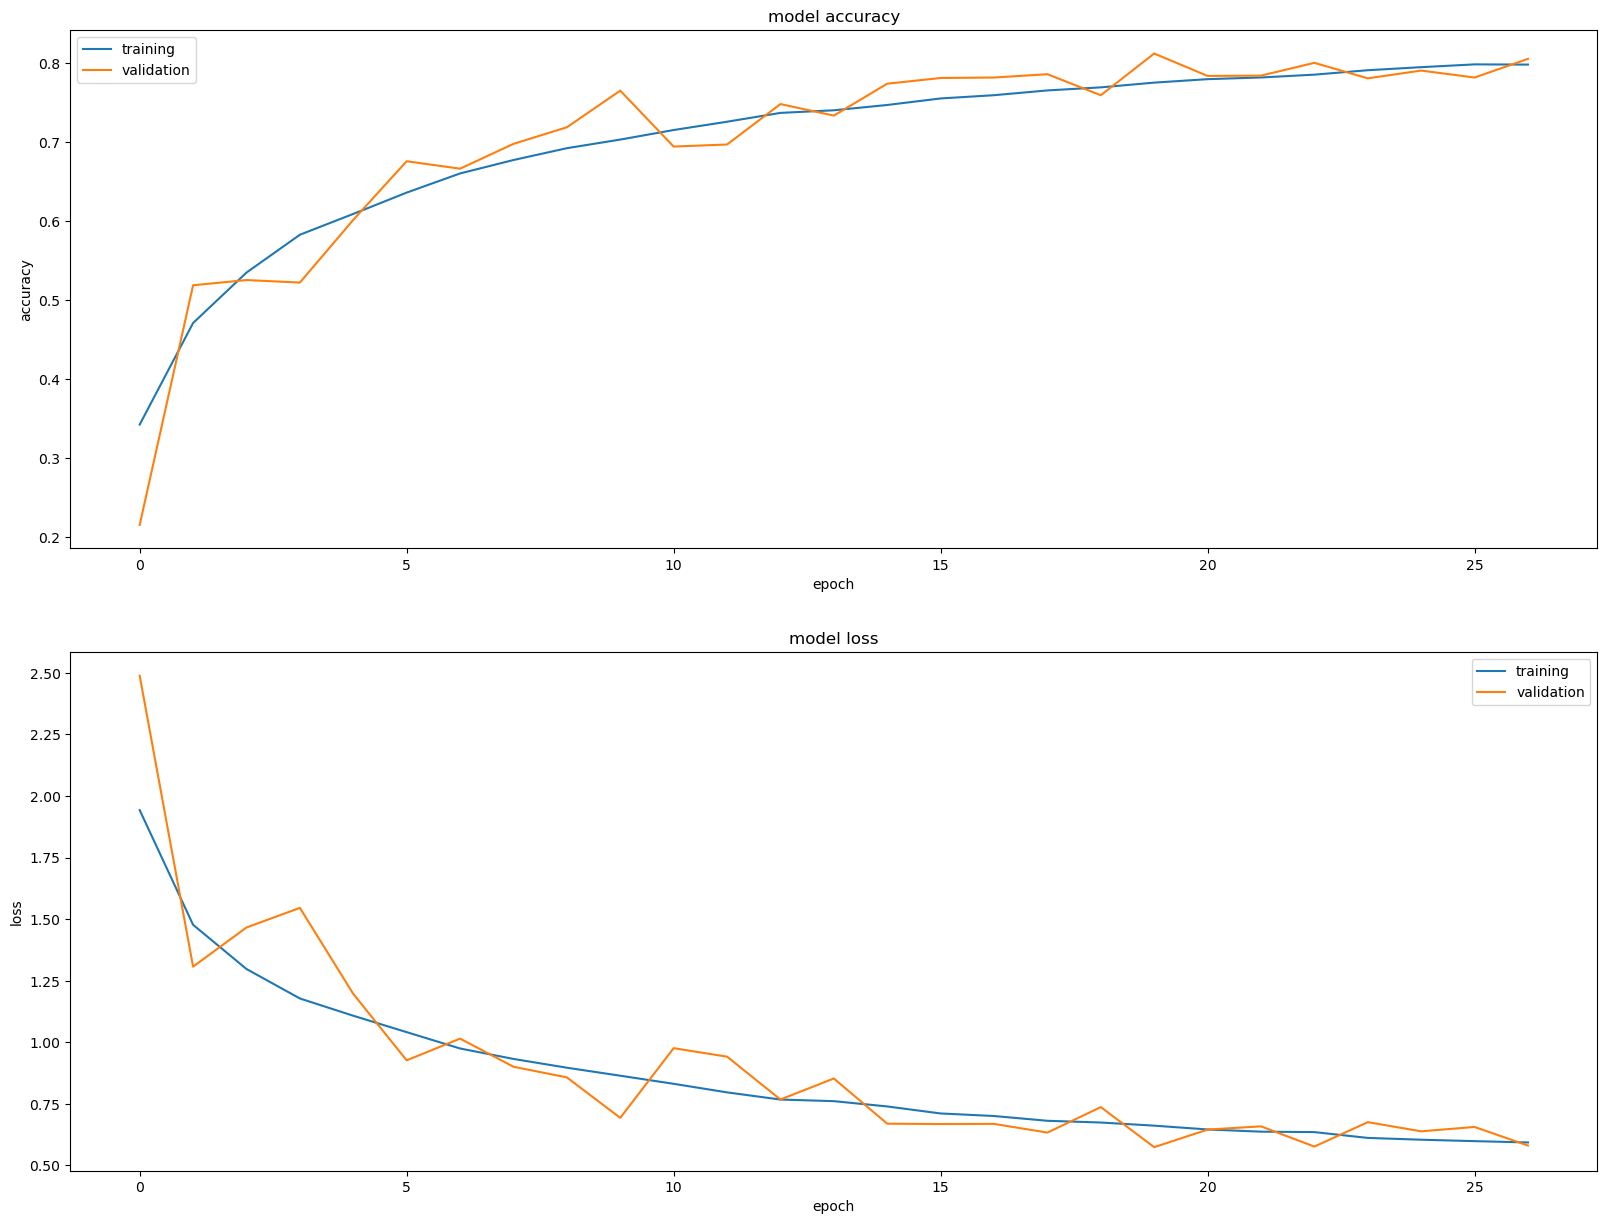

In [44]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_15.history['accuracy'], history_15.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_15.history['loss'], history_15.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 15)

In [45]:
pred_15 = model_15.predict(x_test_norm)
pred_15 = np.argmax(pred_15, axis=1)

In [46]:
print_validation_report(y_test, pred_15)

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1000
           1       0.70      0.98      0.82      1000
           2       0.77      0.74      0.76      1000
           3       0.80      0.59      0.68      1000
           4       0.83      0.75      0.79      1000
           5       0.82      0.73      0.77      1000
           6       0.67      0.94      0.78      1000
           7       0.91      0.81      0.86      1000
           8       0.92      0.84      0.88      1000
           9       0.88      0.79      0.83      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000

Accuracy Score: 0.7989
Root Mean Square Error: 1.9963466632827074


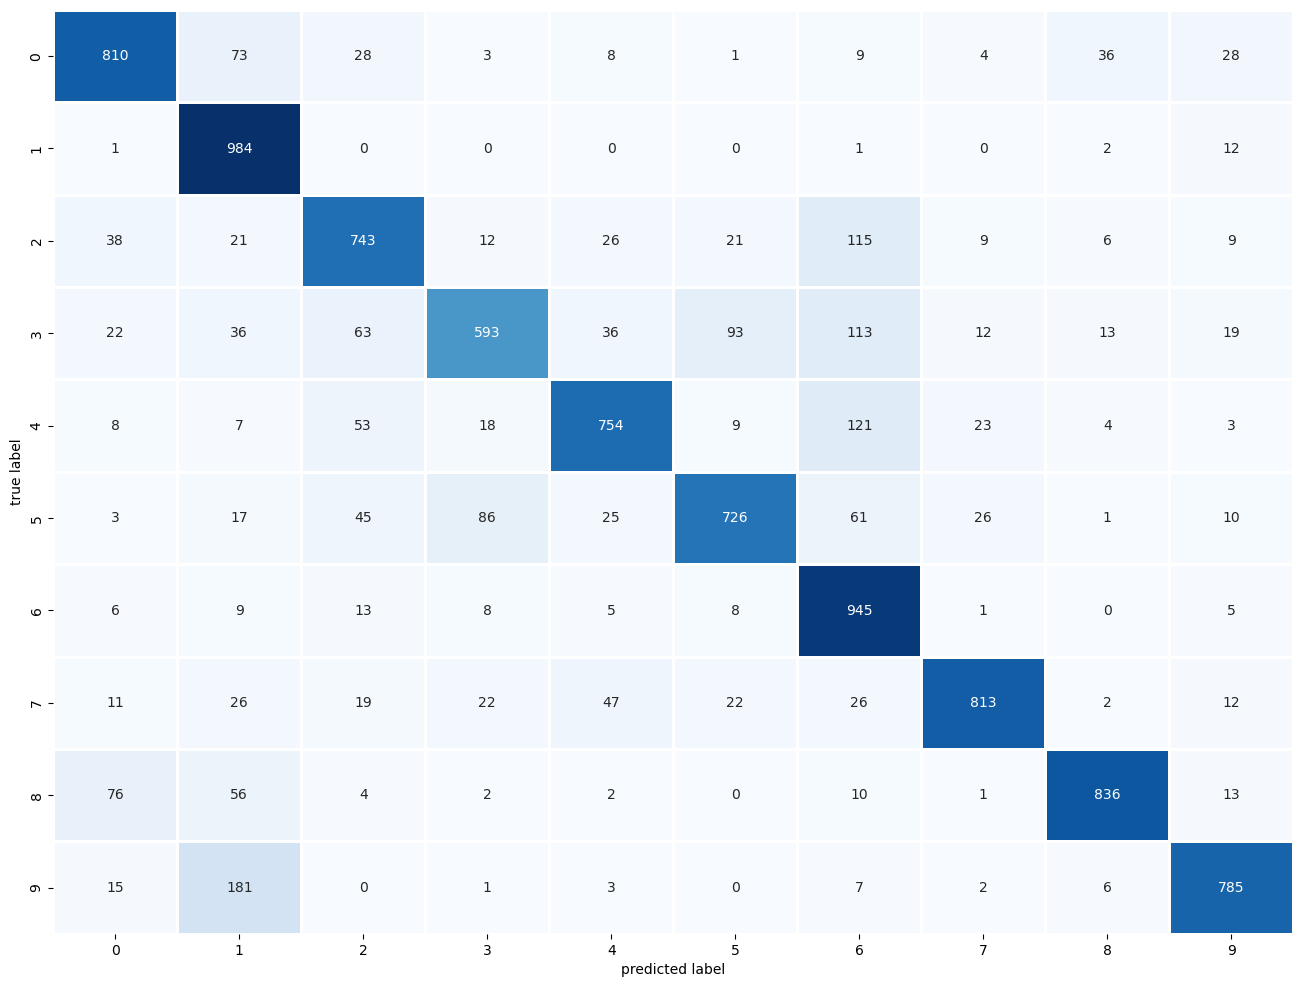

In [48]:
plot_confusion_matrix(y_test, pred_15)

# Experiment 16

In [49]:
# 16
model_16 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu,
           input_shape=x_train_norm.shape[1:]),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    MaxPool2D((2, 2),strides=2),
    
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    MaxPool2D((2, 2),strides=2),
    
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    MaxPool2D((2, 2),strides=2),

    Flatten(),
    Dense(units=128,activation=tf.nn.relu),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=10, activation=tf.nn.softmax)       
])

model_16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_25 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_26 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

In [50]:
history_16, model_16, results_16 = compile_train_model(model_16,
                                                           x_train_norm, y_train_split,
                                                           x_valid_norm, y_valid_split,
                                                           x_test_norm, y_test
                                                   )

Epoch 1/200
88/88 [==============================] - 103s 1s/step - loss: 1.6707 - accuracy: 0.4518 - val_loss: 2.9990 - val_accuracy: 0.1134
Epoch 2/200
88/88 [==============================] - 99s 1s/step - loss: 1.0721 - accuracy: 0.6261 - val_loss: 3.5582 - val_accuracy: 0.1400
Epoch 3/200
88/88 [==============================] - 100s 1s/step - loss: 0.8394 - accuracy: 0.7069 - val_loss: 3.5577 - val_accuracy: 0.2378
Epoch 4/200
88/88 [==============================] - 100s 1s/step - loss: 0.6876 - accuracy: 0.7617 - val_loss: 2.2996 - val_accuracy: 0.3342
Epoch 5/200
88/88 [==============================] - 100s 1s/step - loss: 0.5720 - accuracy: 0.8039 - val_loss: 1.0772 - val_accuracy: 0.6294
Epoch 6/200
88/88 [==============================] - 99s 1s/step - loss: 0.4721 - accuracy: 0.8362 - val_loss: 0.8310 - val_accuracy: 0.7148
Epoch 7/200
88/88 [==============================] - 99s 1s/step - loss: 0.3899 - accuracy: 0.8655 - val_loss: 0.6754 - val_accuracy: 0.7742
Epoch 8/2

In [52]:
print(pd.DataFrame([results_16], columns=['train_loss', 'val_loss', 'test_loss', 'train_acc',
                                        'val_acc', 'test_acc', 'time']))

   train_loss  val_loss  test_loss  train_acc  val_acc  test_acc  time
0      0.1363    0.8697     0.8876     0.9527    0.768    0.7676  1156


C:\Users\richd\AppData\Local\Temp\ipykernel_39884\2022487927.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


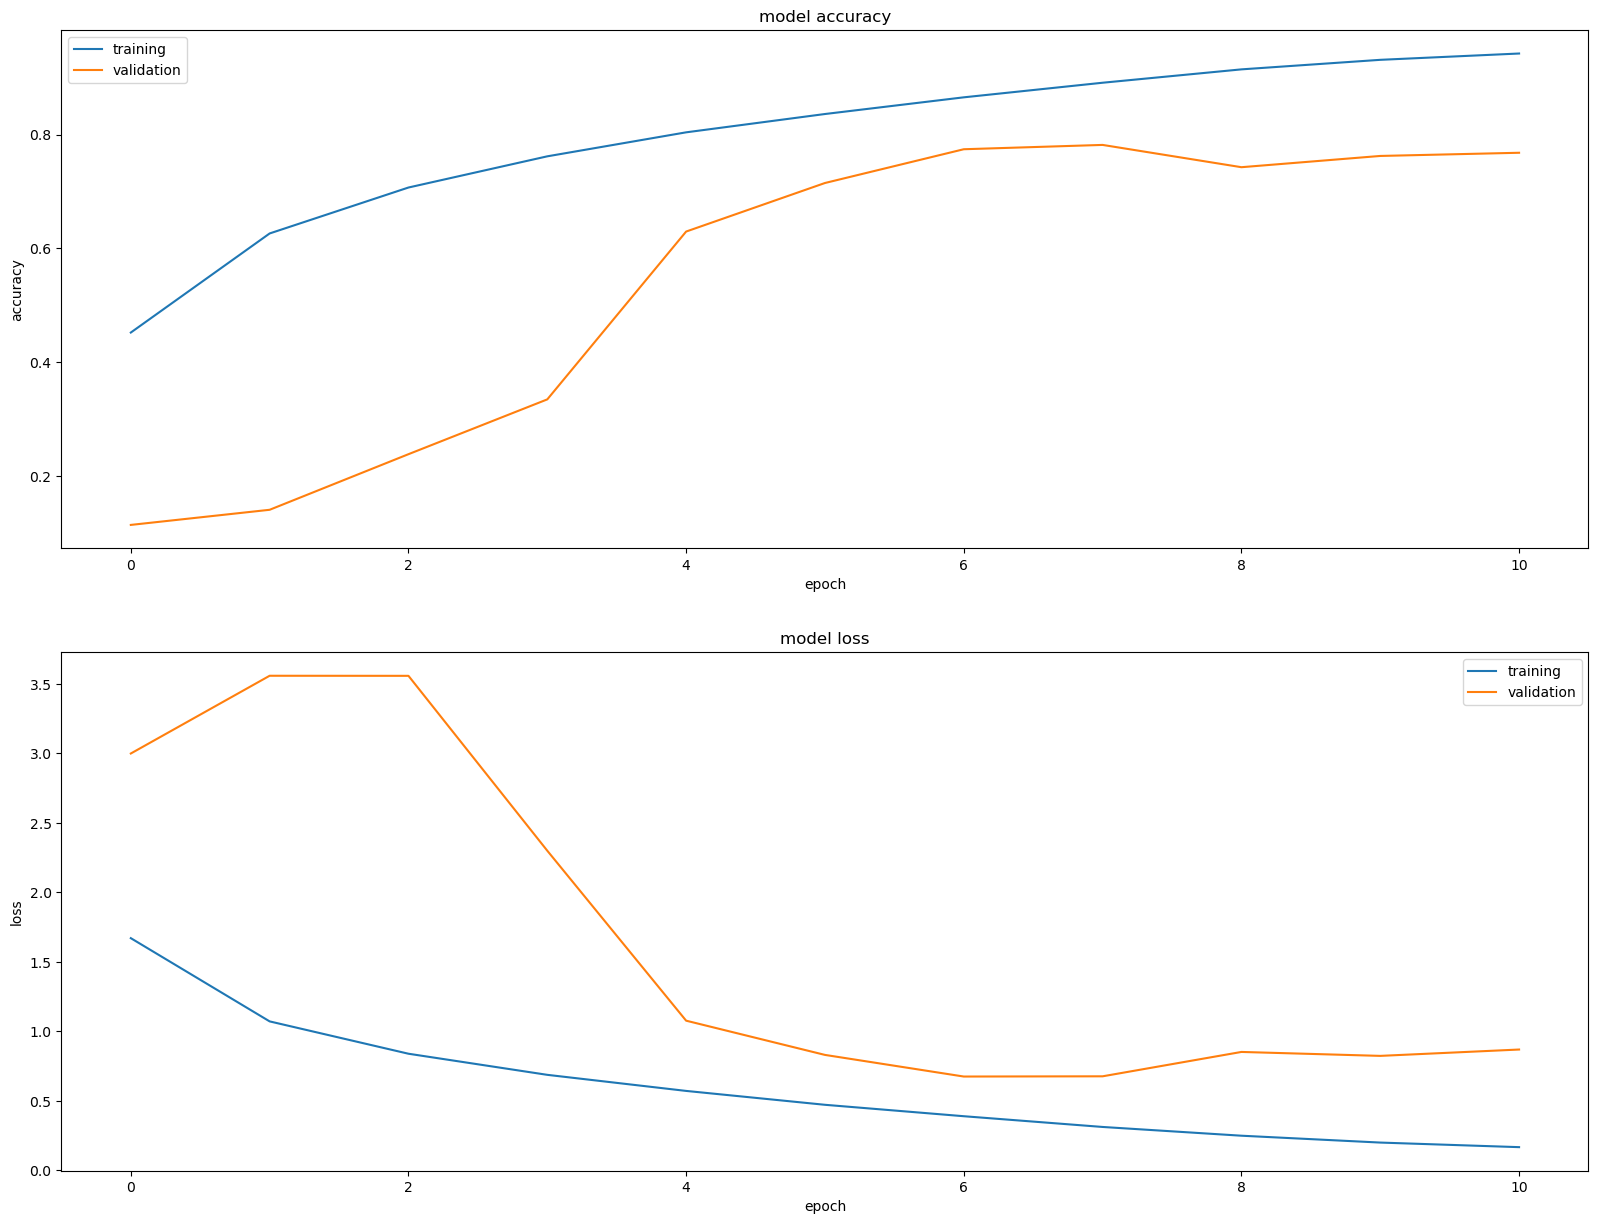

In [64]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_16.history['accuracy'], history_16.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_16.history['loss'], history_16.history['val_loss'], 'loss', 212)

### Confusion Matrix (exp 16)

In [65]:
pred_16 = model_16.predict(x_test_norm)
pred_16 = np.argmax(pred_16, axis=1)

In [66]:
print_validation_report(y_test, pred_16)

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      1000
           1       0.87      0.90      0.89      1000
           2       0.60      0.74      0.66      1000
           3       0.70      0.43      0.54      1000
           4       0.77      0.68      0.72      1000
           5       0.66      0.72      0.69      1000
           6       0.87      0.83      0.85      1000
           7       0.72      0.87      0.79      1000
           8       0.89      0.87      0.88      1000
           9       0.91      0.80      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.76     10000
weighted avg       0.77      0.77      0.76     10000

Accuracy Score: 0.7678
Root Mean Square Error: 1.9411336893681486


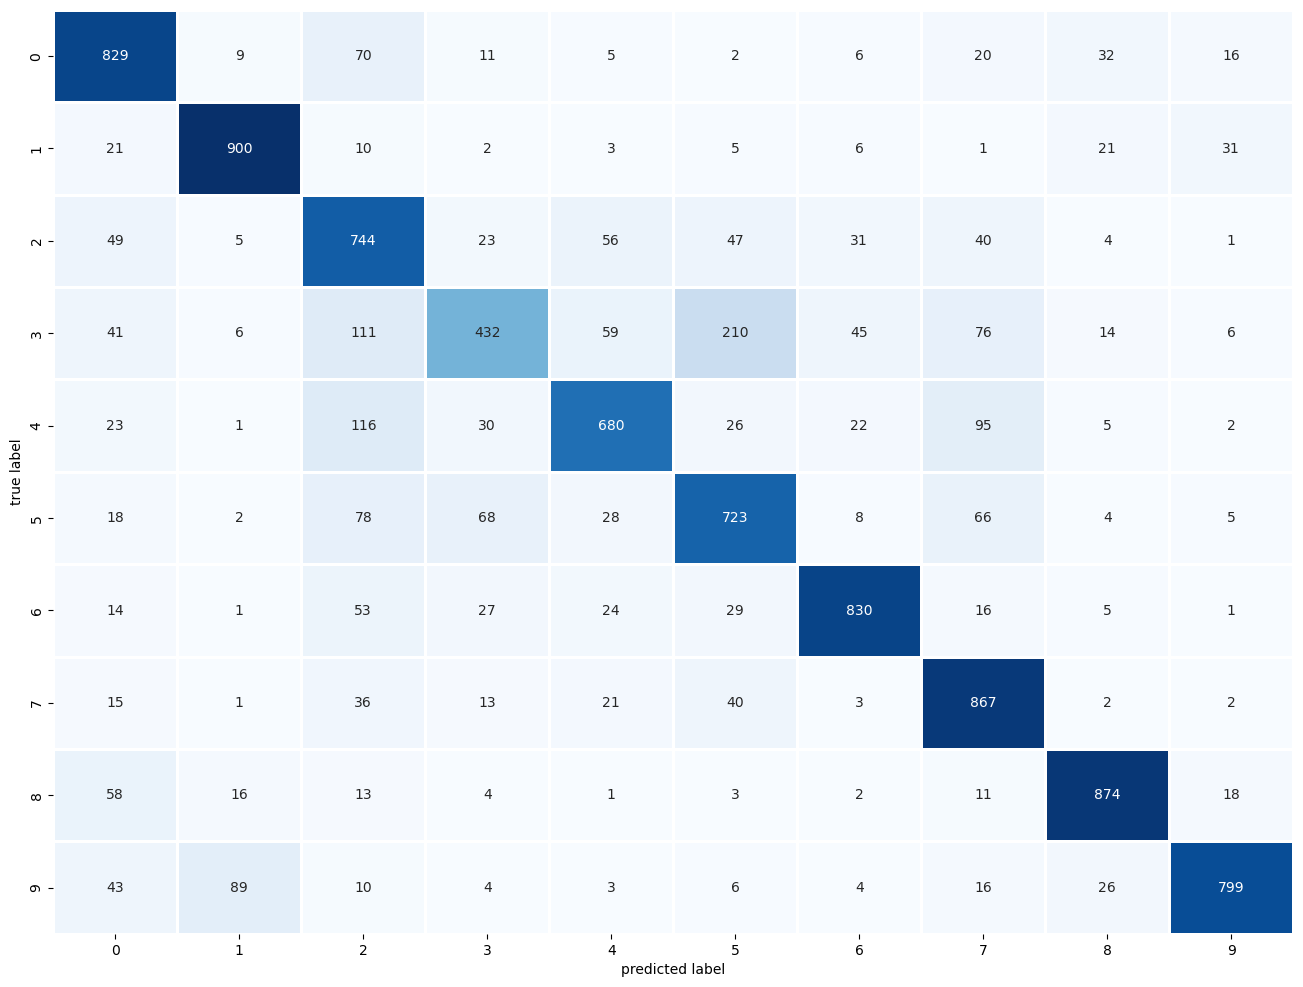

In [67]:
plot_confusion_matrix(y_test, pred_16)

# Visualize from Experiment 3
- Visualize a grid of images from the filters and max pooling layers in experiment 3

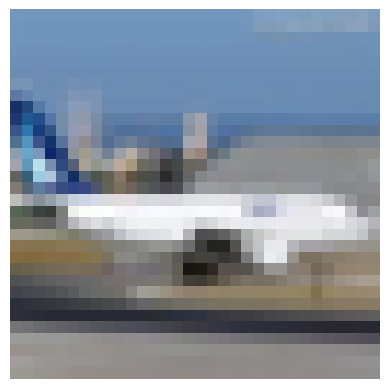

In [84]:
# preprocessing a single image
img  = x_test[90]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [91]:
# extracts the outputs of the top 6 layers:
layer_outputs = [layer.output for layer in model_3.layers[:6]]
# creates a model that will return these outputs given the model input:
activation_model = models.Model(inputs=model_3.input, outputs=layer_outputs)

In [92]:
activations = activation_model.predict(img_tensor)
len(activations)

6

In [99]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d_6',
 'max_pooling2d_6',
 'conv2d_7',
 'max_pooling2d_7',
 'flatten_3',
 'dense_6',
 'dense_7']

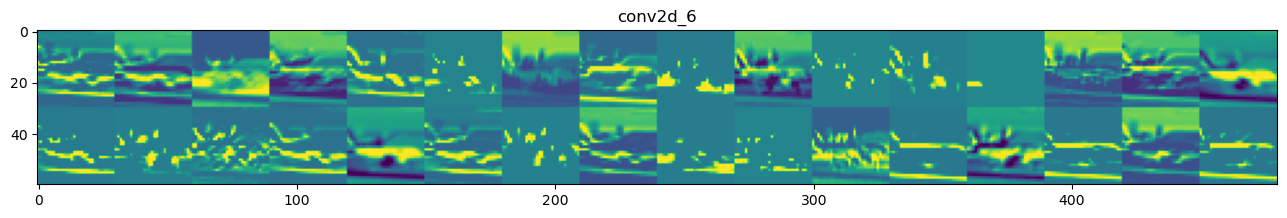

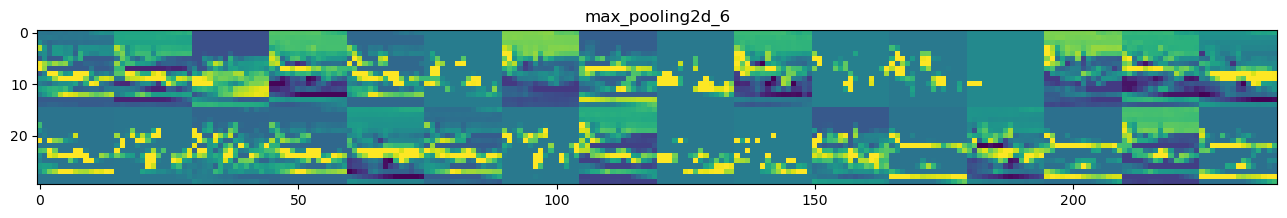

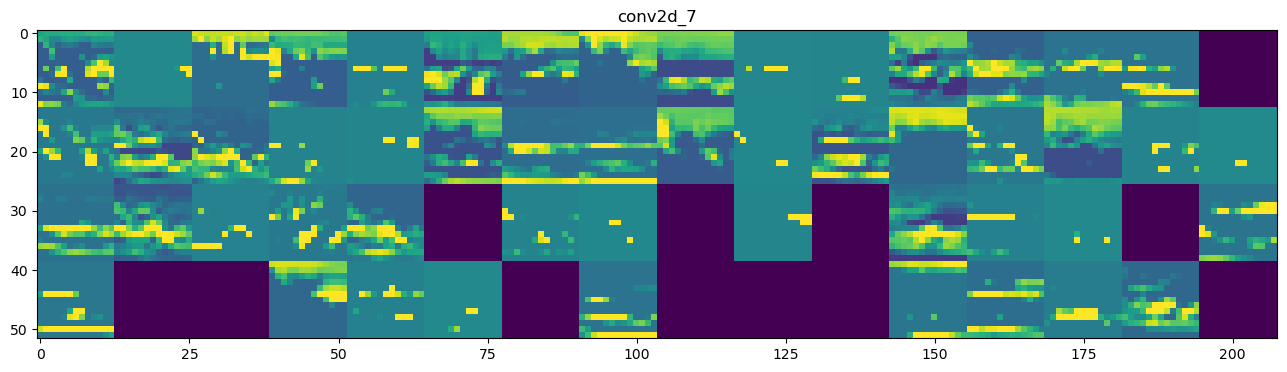

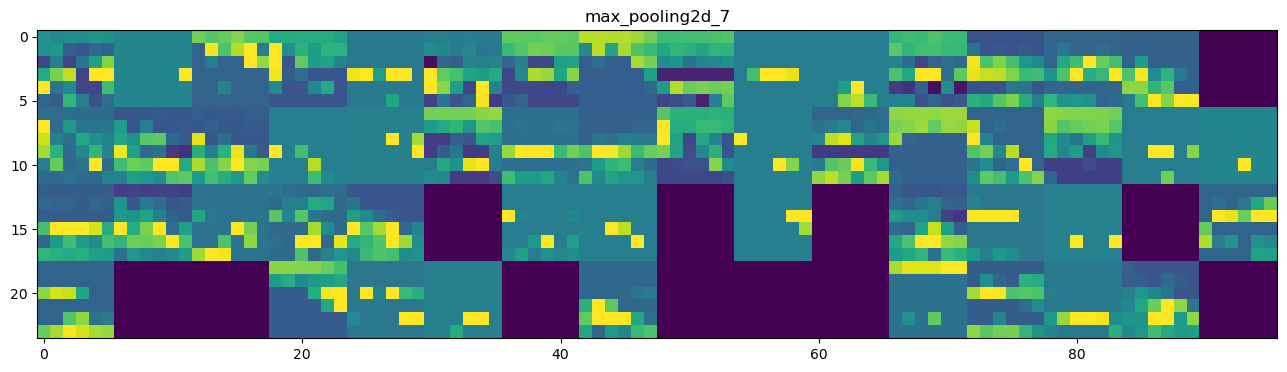

In [102]:
# can include the layer names as part of the plot
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)
    
images_per_row = 16

# Display the feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # this is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    
    # the feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]
    
    # let's tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    # Let's tile each filter into a big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                            :, :, 
                                            col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
            
    # display the grid 
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                       scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

### Visualize MODEL X through T-SNE

In [68]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model_15.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model_15.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:3250])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

### sklearn.manifold.TSNE

In [69]:
# reduce the dimension using T-SNE to visualize in a scatterplot
tsne = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.007s...
[t-SNE] Computed neighbors for 3250 samples in 0.574s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 2.463978
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.555351
[t-SNE] KL divergence after 300 iterations: 1.891329


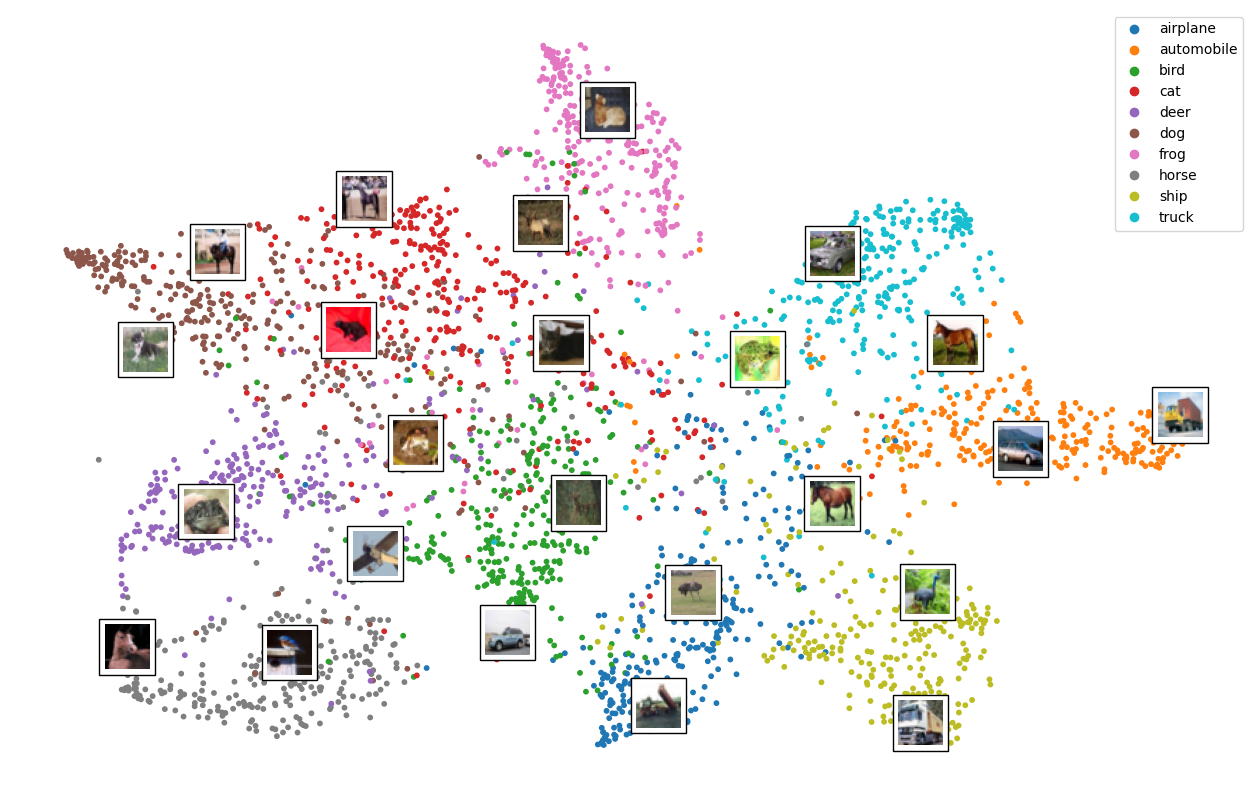

In [70]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02:       # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()